# Disease_Similarity_Benchmark: Biases

## Load Data

In [1]:
# imports

import logging, sys, os
from tqdm import tqdm
import numpy as np, pandas as pd
from tqdm.contrib.concurrent import process_map
import pickle

logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)

# variables
data_info_path = os.path.join(
    "..", "data", "DiSignAtlas", "Disease_information_Datasets.csv"
)
mesh_tree_terms_path = os.path.join("..", "data", "DiSignAtlas", "mesh_tree_terms.pkl")
mesh_ids_path = os.path.join("..", "data", "DiSignAtlas", "mesh_tree_terms.pkl")


# functions
def get_processed_ids():
    """Get processed ids
    Returns:
        list: list of processed ids
    """
    data_path = os.path.join("..", "data", "DiSignAtlas", "dsa_diff_download.processed")
    return [f.split("_")[0] for f in os.listdir(data_path)]


# Load the all genes per (human) signature


def get_signatures(dsaid, remove_duplicates=True):
    """
    Calculate signed significance for each gene in the signature.
    Args:
        - dsaid: str

    Returns:
        - gene_ids: list
            List of gene IDs
        - p_values: list
            List of p-values
        - de_values: list
            List of log2 fold changes
    """
    data_path = os.path.join(
        "..",
        "data",
        "DiSignAtlas",
        "dsa_diff_download.processed",
        f"{dsaid}_alldiff.txt",
    )

    if os.path.exists(data_path):
        df = pd.read_csv(data_path)
        n_deleted_duplicates = df.duplicated(subset=["GeneID"]).sum()

        # remove duplicate gene ids
        if remove_duplicates:
            df = df.drop_duplicates(subset=["GeneID"], keep=False)

        # drop nans if present - ideally pre-processing cleans this
        df_cleaned = df.dropna(subset=["PValue", "AdjPValue", "Log2FC"])

        genes = df_cleaned["GeneID"].tolist()
        p_values = df_cleaned["PValue"].tolist()
        adj_p_values = df_cleaned["AdjPValue"].tolist()
        log2fc = df_cleaned["Log2FC"].tolist()

        return dsaid, n_deleted_duplicates, genes, p_values, adj_p_values, log2fc
    else:
        data_path = os.path.join(
            "..",
            "data",
            "DiSignAtlas",
            "dsa_diff_download.processed",
            f"{dsaid}_whole_diff_regulation.csv",
        )

        df = pd.read_csv(data_path)
        n_deleted_duplicates = df.duplicated(subset=["GeneID"]).sum()

        # remove duplicate gene ids
        if remove_duplicates:
            df = df.drop_duplicates(subset=["geneid"], keep=False)

        # drop nans if present - ideally pre-processing cleans this
        df_cleaned = df.dropna(subset=["PValue", "AdjPValue", "Log2FC"])

        genes = df_cleaned["geneid"].tolist()
        p_values = df_cleaned["pvalue"].tolist()
        adj_p_values = df_cleaned["adjpvalue"].tolist()
        log2fc = df_cleaned["log2fc"].tolist()

        return dsaid, n_deleted_duplicates, genes, p_values, adj_p_values, log2fc


# get all entrez protein-coding human ids
def get_human_entrez_protein_coding_ids():
    """Get Human Entrez IDs
    Returns:
        list: list of human entrez ids
    """
    data_path = os.path.join("..", "data", "ncbi_gene_info", "gene_info")
    df = pd.read_csv(data_path, sep="\t", usecols=["#tax_id", "GeneID", "type_of_gene"])
    df_human = df[(df["#tax_id"] == 9606) & (df["type_of_gene"] == "protein-coding")]
    logging.info(f"Nº of Human protein coding genes: {len(df_human)}")
    return df_human["GeneID"].to_list()


# load data

processed_ids = get_processed_ids()
logging.info(f"Nº of processed ids: {len(processed_ids)}")

df_data_info = pd.read_csv(data_info_path)

df_data_info_processed = df_data_info.copy()

df_data_info_processed = df_data_info_processed[
    df_data_info_processed["dsaid"].isin(processed_ids)
]

logging.info(f"Nº of processed ids in df_data_info: {len(df_data_info_processed)}")

df_data_info_processed_filtered = df_data_info_processed[
    (df_data_info_processed["organism"] == "Homo sapiens")
    & (
        (df_data_info_processed["library_strategy"] == "Microarray")
        | (df_data_info_processed["library_strategy"] == "RNA-Seq")
    )
]
logging.info(
    f"Nº of Filtered by library (filter out single cell): {df_data_info_processed_filtered.shape}"
)

2024-05-13 14:13:29,618 - INFO - Nº of processed ids: 7191
2024-05-13 14:13:29,642 - INFO - Nº of processed ids in df_data_info: 7191
2024-05-13 14:13:29,644 - INFO - Nº of Filtered by library (filter out single cell): (7001, 12)


In [2]:
logging.info(f"Loading file {mesh_tree_terms_path}")
with open(mesh_tree_terms_path, "rb") as f:
    data = pickle.load(f)
    mesh_tree_terms = data.get("mesh_tree_terms")
    mesh_dsaids = data.get("dsaids")
    mesh_ids = data.get("mesh_ids")
    dsaids_2_mesh_tree_terms = {k: v for k, v in zip(mesh_dsaids, mesh_tree_terms)}
    dsaids_2_mesh_ids = {k: v for k, v in zip(mesh_dsaids, mesh_ids)}

dsaids_with_mesh = [k for k, v in dsaids_2_mesh_tree_terms.items() if len(v) > 0]
logging.info(f"Nº of dsaids with mesh {len(dsaids_with_mesh)}")

2024-05-13 14:13:29,765 - INFO - Loading file ../data/DiSignAtlas/mesh_tree_terms.pkl
2024-05-13 14:13:29,771 - INFO - Nº of dsaids with mesh 7790


In [3]:
# filter df by mesh presence
df_data_info_processed_filtered_mesh = df_data_info_processed_filtered[
    df_data_info_processed_filtered["dsaid"].isin(dsaids_with_mesh)
]

logging.info(f"df mesh: {df_data_info_processed_filtered_mesh.shape}")

2024-05-13 14:13:30,059 - INFO - df mesh: (5317, 12)


In [4]:
# get all entrez protein-coding human ids
human_entrez_protein_coding_ids = get_human_entrez_protein_coding_ids()

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [ ]:
thr_counts = 5
disease_2_counts = dict(df_data_info_processed_filtered["disease"].value_counts())

diseases_high_counts = [k for k, v in disease_2_counts.items() if v >= thr_counts]

logging.info(
    f"Nº of Diseases for Benchmark {len(diseases_high_counts)} / {len(disease_2_counts)}"
)

2024-05-13 13:24:53,624 - INFO - Nº of Diseases for Benchmark 276 / 1428


In [ ]:
all_diseases = df_data_info_processed_filtered["disease"].to_list()
all_dsaids = df_data_info_processed_filtered["dsaid"].to_list()

disease_2_dsaids = dict()
for k, v in tqdm(zip(all_diseases, all_dsaids)):
    if k not in disease_2_dsaids.keys():
        disease_2_dsaids[k] = list()
    disease_2_dsaids[k].append(v)

7001it [00:00, 3435227.22it/s]


In [ ]:
import pickle

path_pkl = os.path.join("..", "data", "DiSignAtlas", "signatures.pkl")

human_dsaids_processed = df_data_info_processed_filtered["dsaid"].to_list()
human_library_processed = df_data_info_processed_filtered["library_strategy"].to_list()

if not os.path.exists(path_pkl):

    signatures = process_map(
        get_signatures,
        human_dsaids_processed,
        max_workers=8,
        chunksize=10,
    )
    pickle.dump(signatures, open(path_pkl, "wb"))
    logging.info(f"Signatures saved {path_pkl}")

else:
    logging.info(f"Loading signatures from file {path_pkl}")
    signatures = pickle.load(open(path_pkl, "rb"))

2024-05-13 13:24:54,201 - INFO - Loading signatures from file ../data/DiSignAtlas/signatures.pkl


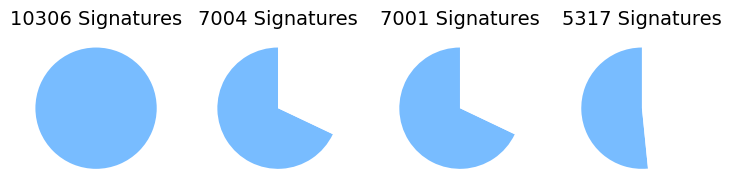

In [ ]:
import matplotlib.pyplot as plt

# Assuming values for n_step_0, n_step_1, and n_step_2 for demonstration
n_step_0 = df_data_info.shape[0]
n_step_1 = df_data_info[
    (df_data_info["organism"] == "Homo sapiens")
    & (
        (df_data_info["library_strategy"] == "RNA-Seq")
        | (df_data_info["library_strategy"] == "Microarray")
    )
].shape[0]
n_step_2 = df_data_info_processed_filtered.shape[0]
n_step_3 = len(
    set(dsaids_with_mesh) & set(df_data_info_processed_filtered["dsaid"].to_list())
)

# Define labels and sizes for the pie charts
sizes_step_0 = [n_step_0, 0]  # Initially, nothing is filtered out
sizes_step_1 = [n_step_1, n_step_0 - n_step_1]
sizes_step_2 = [n_step_2, n_step_0 - n_step_2]
sizes_step_3 = [n_step_3, n_step_0 - n_step_3]

# Define colors for the pie charts
colors = ["#78bcffff", "white"]

# Generate the pie charts without labels or percentages, only colors and titles
fig, ax = plt.subplots(1, 4, figsize=(9, 3))

ax[0].pie(sizes_step_0, colors=colors, startangle=90)
ax[0].set_title(f"{n_step_0} Signatures", fontsize=14)
ax[0].set(aspect="equal")
ax[0].set_axis_off()  # Remove borders and ticks

ax[1].pie(sizes_step_1, colors=colors, startangle=90)
ax[1].set_title(f"{n_step_1} Signatures", fontsize=14)
ax[1].set(aspect="equal")
ax[1].set_axis_off()  # Remove borders and ticks

ax[2].pie(sizes_step_2, colors=colors, startangle=90)
ax[2].set_title(f"{n_step_2} Signatures", fontsize=14)
ax[2].set(aspect="equal")
ax[2].set_axis_off()  # Remove borders and ticks

ax[3].pie(sizes_step_3, colors=colors, startangle=90)
ax[3].set_title(f"{n_step_3} Signatures", fontsize=14)
ax[3].set(aspect="equal")
ax[3].set_axis_off()  # Remove borders and ticks


plt.savefig(
    os.path.join("..", "results", "figures", "DiSignAtlas", "mesh.pre_process.png"),
    bbox_inches="tight",
    dpi=300,
)

In [ ]:
logging.info(
    f"Nº of non-redundant diseases initially: {df_data_info['disease'].nunique()}"
)
logging.info(
    f"Nº of non-redundant diseases after pre-processing: {df_data_info_processed_filtered['disease'].nunique()}"
)

2024-05-13 13:25:12,016 - INFO - Nº of non-redundant diseases initially: 1836
2024-05-13 13:25:12,017 - INFO - Nº of non-redundant diseases after pre-processing: 1428


In [ ]:
interesting_dsaids = []
n_std = list()
vector_len = list()
for i, s in enumerate(tqdm(signatures)):
    if np.any(np.array(s[5]) > 500) or np.any(np.array(s[5]) < -500):
        interesting_dsaids.append((i, s[0], max(s[5]), min(s[5])))

    # compute std
    std = np.std(signatures[i][5])
    mean = np.mean(signatures[i][5])

    n = len(
        [
            value
            for value in signatures[i][5]
            if (value > mean + 6 * std) or (value < mean - 6 * std)
        ]
    )

    vector_len.append(len(signatures[i][5]))
    n_std.append(n)

logging.info(f"Nº of dsaids w/ extreme log2fc: {len(interesting_dsaids)}")
logging.info(f"Signatures: {interesting_dsaids}")

100%|██████████| 7001/7001 [00:34<00:00, 201.25it/s]
2024-05-13 13:25:47,093 - INFO - Nº of dsaids w/ extreme log2fc: 3
2024-05-13 13:25:47,093 - INFO - Signatures: [(3379, 'DSA04659', 283010.779335352, -99319.619817649), (3380, 'DSA04660', 367171.584055279, -408566.783065797), (6416, 'DSA09547', 61042.6740428988, -355887.1218498)]


In [ ]:
# dsaid to disease
dsaid_2_disease = dict(df_data_info_processed_filtered[["dsaid", "disease"]].values)

In [ ]:
dataset_2_disease = dict()

for index, row in df_data_info_processed_filtered.iterrows():
    accession = row["accession"]  # Access the 'accession' column in the row
    disease = row["disease"]  # Access the 'disease' column in the row

    if accession not in dataset_2_disease:
        dataset_2_disease[accession] = (
            []
        )  # Initialize with an empty list if not present

    dataset_2_disease[accession].append(
        disease
    )  # Append the disease to the list for this accession

In [ ]:
# {accession} -> [[mesh terms]]
dataset_2_mesh = dict()

for index, row in df_data_info_processed_filtered.iterrows():
    accession = row["accession"]  # Access the 'accession' column in the row
    disease = row["disease"]  # Access the 'disease' column in the row
    dsaid = row["dsaid"]
    if len(dsaids_2_mesh_tree_terms.get(dsaid)) > 0:

        if accession not in dataset_2_mesh.keys():
            dataset_2_mesh[accession] = (
                []
            )  # Initialize with an empty list if not present

        dataset_2_mesh[accession].append(
            dsaids_2_mesh_tree_terms.get(dsaid)
        )  # Append the disease to the list for this accession


logging.info(
    f"Nº of datasets w/ mesh: {len(dataset_2_mesh)}/{df_data_info_processed_filtered['accession'].nunique()}"
)

2024-05-13 13:25:47,895 - INFO - Nº of datasets w/ mesh: 2745/3542


In [ ]:
# {dataset} -> [[mesh terms]]
dataset_2_disease = {
    k: v for k, v in df_data_info_processed_filtered[["dsaid", "disease"]].values
}
logging.info(f"Nº datset_2_disease {len(dataset_2_disease)}")

2024-05-13 13:25:48,079 - INFO - Nº datset_2_disease 7001


In [ ]:
#  {disease} -> [[mesh terms]]
disease_2_mesh_tree_terms = dict()

for index, row in df_data_info_processed_filtered.iterrows():
    dsaid_i = row["dsaid"]
    disease_i = row["disease"]
    if dsaid_i in dsaids_with_mesh:
        # get mesh terms
        mesh_terms = dsaids_2_mesh_tree_terms[dsaid_i]

        if disease_i not in disease_2_mesh_tree_terms.keys():
            disease_2_mesh_tree_terms[disease_i] = []
            disease_2_mesh_tree_terms[disease_i].append(mesh_terms)

        else:
            # check if mesh terms are already in the list
            if set(mesh_terms) != set(disease_2_mesh_tree_terms[disease_i][0]):
                disease_2_mesh_tree_terms[disease_i].append(mesh_terms)

In [ ]:
# {dataset} -> {disease}
dataset_2_disease = dict()
# get datasets w/ different diseases
for index, row in df_data_info_processed_filtered.iterrows():
    dsaid = row["dsaid"]
    if dsaid in dsaids_with_mesh:
        disease = row["disease"]
        accession = row["accession"]
        if accession not in dataset_2_disease.keys():
            dataset_2_disease[accession] = set()

        dataset_2_disease[accession].add(disease)

In [ ]:
# are there datasets w/ +1 diseases?
for k, v in dataset_2_disease.items():
    if len(v) > 1:
        logging.info(f"{k} : {v}")

2024-05-13 13:25:49,578 - INFO - GSE126342 : {'Congenital Myotonic Dystrophy', 'Myotonic Dystrophy Type 1'}
2024-05-13 13:25:49,578 - INFO - GSE6613 : {'Neurodegenerative Diseases', "Parkinson's Disease"}
2024-05-13 13:25:49,578 - INFO - GSE9006 : {'Type 2 Diabetes', 'Type 1 Diabetes'}
2024-05-13 13:25:49,579 - INFO - GSE185764 : {'Atopic Dermatitis', 'Psoriasis'}
2024-05-13 13:25:49,579 - INFO - GSE128470 : {'Dermatomyositis', 'Inclusion Body Myositis'}
2024-05-13 13:25:49,579 - INFO - GSE100026 : {'Progressive Chronic Myeloid Leukemia', 'Chronic Myeloid Leukemia'}
2024-05-13 13:25:49,579 - INFO - GSE100150 : {'Influenza', 'Multiple Sclerosis', 'Tuberculosis', 'Systemic-Onset Juvenile Idiopathic Arthritis', 'Sepsis', 'Kawasaki Disease', 'Chronic Obstructive Pulmonary Disease', 'Systemic Lupus Erythematosus', 'Melanoma', 'Juvenile Dermatomyositis'}
2024-05-13 13:25:49,579 - INFO - GSE100179 : {'Progressive Colorectal Carcinoma', 'Colorectal Carcinoma'}
2024-05-13 13:25:49,580 - INFO - 

In [ ]:
# are there datasets w/ +1 significantly different disease?
found_cases = set()
for k, v in dataset_2_disease.items():
    if len(v) > 1:
        for disease_1 in v:
            for disease_2 in v:
                if disease_1 != disease_2:
                    mesh_1 = disease_2_mesh_tree_terms.get(disease_1)
                    mesh_1 = [x.split(".")[0] for sublist in mesh_1 for x in sublist]
                    mesh_2 = disease_2_mesh_tree_terms.get(disease_2)
                    mesh_2 = [x.split(".")[0] for sublist in mesh_2 for x in sublist]
                    if len(set(mesh_1) & set(mesh_2)) == 0:
                        found_cases.add(k)

logging.info(
    f"Nº of datasets w/ +1 significantly different disease: {len(found_cases)}"
)

2024-05-13 13:25:49,920 - INFO - Nº of datasets w/ +1 significantly different disease: 63


In [ ]:
# inspect some cases
for k in found_cases:
    logging.info(f"{k} : {dataset_2_disease.get(k)}")
    for d in dataset_2_disease.get(k):
        logging.info(f"{d} : {disease_2_mesh_tree_terms.get(d)}")

    break

2024-05-13 13:25:50,367 - INFO - GSE139602 : {'Cirrhosis', 'Acute-On-Chronic Liver Failure'}
2024-05-13 13:25:50,367 - INFO - Cirrhosis : [['C23.550.355']]
2024-05-13 13:25:50,367 - INFO - Acute-On-Chronic Liver Failure : [['C06.552.308.500.750.249']]


In [ ]:
# chek if these diseases are present in other datasets
found_cases_check = set()
for dataset in found_cases:
    pass_filter = True
    for disease in dataset_2_disease.get(dataset):
        QUERY = f"disease == @disease and accession != @dataset"
        df_query = df_data_info_processed_filtered_mesh.query(QUERY)
        if len(df_query) < 5:
            pass_filter = False
    if pass_filter:
        found_cases_check.add(dataset)

logging.info(
    f"Nº of datasets w/ +1 significantly different disease: {len(found_cases_check)}"
)

2024-05-13 13:25:50,926 - INFO - Nº of datasets w/ +1 significantly different disease: 28


In [ ]:
"""
get dsaids for:
    a) Same dataset and different disease
    b) Same disease and different dataset
    c) Different dataset and different disease
"""

for dataset in found_cases:
    for disease in dataset_2_disease.get(dataset):
        # dsaids for diseases in the dataset
        QUERY = f"accession == @dataset and disease == @disease"
        df_query = df_data_info_processed_filtered_mesh.query(QUERY)
        dsaids_interest = df_query["dsaid"].to_list()

        # a) Same dataset and different disease
        QUERY = f"accession == @dataset and disease != @disease"
        df_query = df_data_info_processed_filtered_mesh.query(QUERY)
        dsaids_same_dataset = df_query["dsaid"].to_list()

        # generate indexes

        # b) Different dataset and same disease
        QUERY = f"disease == @disease and accession != @dataset"
        df_query = df_data_info_processed_filtered_mesh.query(QUERY)
        dsaids_same_disease = df_query["dsaid"].to_list()

        # generate indexes

        # c) Different dataset and different disease
        QUERY = f"disease != @disease and accession != @dataset"
        df_query = df_data_info_processed_filtered_mesh.query(QUERY)
        dsaids_background = df_query["dsaid"].to_list()

        # generate indexes

In [ ]:
logging.info(
    f"Nº of datasets w/ +1 significantly different disease: {len(found_cases_check)}"
)

2024-05-13 13:25:51,973 - INFO - Nº of datasets w/ +1 significantly different disease: 28


In [ ]:
# are there any diseases w/ more than one mesh terms associated?
found = False
for k in disease_2_mesh_tree_terms:
    if len(disease_2_mesh_tree_terms[k]) > 1:
        print(k, disease_2_mesh_tree_terms[k])
        found = True

if not found:
    print("No diseases w/ more than one mesh term associated")

Autism Spectrum Disorder [['F03.625.164.113'], ['F03.625.164.113.500'], ['F03.625.164.113.500']]
Limb-Girdle Muscular Dystrophy [['C05.651.534.500.280', 'C10.668.491.175.500.149', 'C16.320.577.280'], ['C05.651.534.500', 'C10.668.491.175.500', 'C16.320.577'], ['C05.651.534.500', 'C10.668.491.175.500', 'C16.320.577'], ['C05.651.534.500', 'C10.668.491.175.500', 'C16.320.577']]


In [ ]:
# are there any different diseases w/ same mesh terms associated?
diseases = list(disease_2_mesh_tree_terms.keys())
for i in range(len(diseases)):
    for j in range(i + 1, len(diseases)):
        if (
            disease_2_mesh_tree_terms[diseases[i]]
            == disease_2_mesh_tree_terms[diseases[j]]
        ):
            print(diseases[i], "&", diseases[j], disease_2_mesh_tree_terms[diseases[i]])

Congenital Myotonic Dystrophy & Myotonic Dystrophy Type 1 [['C05.651.534.500.500', 'C05.651.662.750', 'C10.574.500.547', 'C10.668.491.175.500.500', 'C10.668.491.606.750', 'C16.320.400.542', 'C16.320.577.500']]
Congenital Myotonic Dystrophy & Myotonic Dystrophy [['C05.651.534.500.500', 'C05.651.662.750', 'C10.574.500.547', 'C10.668.491.175.500.500', 'C10.668.491.606.750', 'C16.320.400.542', 'C16.320.577.500']]
Congenital Myotonic Dystrophy & Myotonic Dystrophy Type 2 [['C05.651.534.500.500', 'C05.651.662.750', 'C10.574.500.547', 'C10.668.491.175.500.500', 'C10.668.491.606.750', 'C16.320.400.542', 'C16.320.577.500']]
Myotonic Dystrophy Type 1 & Myotonic Dystrophy [['C05.651.534.500.500', 'C05.651.662.750', 'C10.574.500.547', 'C10.668.491.175.500.500', 'C10.668.491.606.750', 'C16.320.400.542', 'C16.320.577.500']]
Myotonic Dystrophy Type 1 & Myotonic Dystrophy Type 2 [['C05.651.534.500.500', 'C05.651.662.750', 'C10.574.500.547', 'C10.668.491.175.500.500', 'C10.668.491.606.750', 'C16.320.40

## Raw Data Exploration

In [ ]:
# # get values
# gene_ids = signature[2]
# p_values = signature[3]
# adj_p_values = signature[4]
# log2fc = signature[5]

In [ ]:
# # plot distribution adj p-values for different thresholds

# # variables
# thresholds = [1, 0.25, 0.1, 0.05, 0.01, 0.005, 0.001]
# adjusted = False
# human = True


# # functions
# def counts_p_values(
#     signatures,
#     threshold,
#     adjusted=True,
#     human=True,
#     human_entrez_protein_coding_ids=human_entrez_protein_coding_ids,
# ):
#     """ """
#     if adjusted:
#         data = [signature[4] for signature in signatures]
#     else:
#         data = [signature[3] for signature in signatures]
#     genes = [signature[2] for signature in signatures]
#     counts = []
#     human_entrez_protein_coding_ids = np.array(human_entrez_protein_coding_ids)
#     for dist, gene in zip(data, genes):
#         if human:
#             # filter out non-protein coding genes
#             mask_human_genes = np.isin(np.array(gene), human_entrez_protein_coding_ids)

#             count = np.sum(
#                 np.array(dist)[mask_human_genes] < threshold
#             )  # Count significant p-values
#         else:
#             count = np.sum(np.array(dist) < threshold)  # Count significant p-values
#         counts.append(count)
#     return counts


# # plot

# plot_data = [
#     counts_p_values(signatures, threshold, adjusted=adjusted, human=human)
#     for threshold in thresholds
# ]

# # Plotting
# # Calculate statistical measures for each threshold
# stats_data = {
#     "Median": [],
#     "25th Percentile": [],
#     "75th Percentile": [],
#     "5th Percentile": [],
#     "95th Percentile": [],
# }

# for threshold_data in plot_data:
#     stats_data["Median"].append(np.median(threshold_data))
#     stats_data["25th Percentile"].append(np.percentile(threshold_data, 25))
#     stats_data["75th Percentile"].append(np.percentile(threshold_data, 75))
#     stats_data["5th Percentile"].append(np.percentile(threshold_data, 5))
#     stats_data["95th Percentile"].append(np.percentile(threshold_data, 95))

# # Convert thresholds to string for plotting
# threshold_labels = [f"{threshold}" for threshold in thresholds]

# # Plotting
# fig, ax = plt.subplots(figsize=(4, 4))

# # Plot mean, quartiles, and percentiles as lines
# ax.fill_between(
#     threshold_labels,
#     stats_data["5th Percentile"],
#     stats_data["95th Percentile"],
#     color="goldenrod",
#     alpha=0.1,
# )

# ax.fill_between(
#     threshold_labels,
#     stats_data["25th Percentile"],
#     stats_data["75th Percentile"],
#     color="darkorchid",
#     alpha=0.1,
# )
# ax.plot(
#     threshold_labels,
#     stats_data["5th Percentile"],
#     "--",
#     label="5th Percentile",
#     color="goldenrod",
# )
# ax.plot(
#     threshold_labels,
#     stats_data["95th Percentile"],
#     "--",
#     label="95th Percentile",
#     color="goldenrod",
# )
# ax.plot(
#     threshold_labels, stats_data["Median"], "-o", label="Median", color="darkorchid"
# )

# ax.plot(
#     threshold_labels,
#     stats_data["25th Percentile"],
#     "--",
#     label="25th Percentile",
#     color="darkorchid",
# )
# ax.plot(
#     threshold_labels,
#     stats_data["75th Percentile"],
#     "--",
#     label="75th Percentile",
#     color="darkorchid",
# )


# # Enhancements
# title_txt = "Nº of Significant P-values Across Thresholds"
# if adjusted:
#     title_txt = "Nº of Significant Adj P-values Across Thresholds"
# if human:
#     title_txt = "Nº of Significant P-values Across Thresholds (Human Genes)"
# if human & adjusted:
#     title_txt = "Nº of Significant Adj P-values Across Thresholds (Human Genes)"

# ax.set_title(title_txt)
# ax.set_xlabel("P-value Thresholds")
# ax.set_ylabel("Count of Significant P-values")
# ax.grid(True, which="both", linestyle="--", linewidth=0.5)
# ax.legend()

# plt.xlim(0, len(thresholds) - 1)
# plt.ylim(
#     0,
# )

# file_name = "data_expl.p_values_stats"
# if human:
#     file_name += ".human"
# if adjusted:
#     file_name += ".adj_p_values"
# file_name += ".png"

# plt.savefig(
#     os.path.join("..", "results", "figures", "DiSignAtlas", file_name),
#     bbox_inches="tight",
#     dpi=300,
# )

In [ ]:
# # plot nº signatures

# # variables
# thresholds = [1, 0.25, 0.1, 0.05, 0.01, 0.005, 0.001]
# thresholds_counts = [1, 5, 50, 100, 200]
# adjusted = True
# human = True


# # functions
# def counts_p_values(
#     signatures,
#     threshold,
#     adjusted=True,
#     human=True,
#     human_entrez_protein_coding_ids=human_entrez_protein_coding_ids,
# ):
#     """ """
#     if adjusted:
#         data = [signature[4] for signature in signatures]
#     else:
#         data = [signature[3] for signature in signatures]
#     genes = [signature[2] for signature in signatures]
#     counts = []
#     human_entrez_protein_coding_ids = np.array(human_entrez_protein_coding_ids)
#     for dist, gene in zip(data, genes):
#         if human:
#             # filter out non-protein coding genes
#             mask_human_genes = np.isin(np.array(gene), human_entrez_protein_coding_ids)

#             count = np.sum(
#                 np.array(dist)[mask_human_genes] < threshold
#             )  # Count significant p-values
#         else:
#             count = np.sum(np.array(dist) < threshold)  # Count significant p-values
#         counts.append(count)
#     return counts


# # plot

# plot_data = [
#     counts_p_values(signatures, threshold, adjusted=adjusted)
#     for threshold in thresholds
# ]

# # Plotting
# # Calculate statistical measures for each threshold
# counts_data = {k: [] for k in thresholds_counts}

# for k in thresholds_counts:
#     for threshold_data in plot_data:
#         counts_data[k].append(np.sum(np.array(threshold_data) > k))

# # Convert thresholds to string for plotting
# threshold_labels = [f"{threshold}" for threshold in thresholds]

# # Plotting
# fig, ax = plt.subplots(figsize=(4, 4))
# for k, data in counts_data.items():
#     ax.plot(threshold_labels, data, "-o", label=f"{k}+ Significant Genes")

# # Enhancements
# title_txt = "Nº of Signatures w/ P-value Significant Genes"
# if adjusted:
#     title_txt = "Nº of Significant Adj P-value Significant Genes"
# ax.set_title(title_txt)
# ax.set_xlabel("P-value Thresholds")
# ax.set_ylabel("Count of Significant P-values")
# ax.grid(True, which="both", linestyle="--", linewidth=0.5)
# ax.legend()

# plt.xlim(0, len(thresholds) - 1)
# plt.ylim(
#     0,
# )

# if adjusted:
#     output_path = os.path.join(
#         "..",
#         "results",
#         "figures",
#         "DiSignAtlas",
#         "data_expl.adj_p_val.n_signatures.png",
#     )
# else:
#     output_path = os.path.join(
#         "..", "results", "figures", "DiSignAtlas", "data_expl.p_val.n_signatures.png"
#     )
# plt.savefig(
#     output_path,
#     bbox_inches="tight",
#     dpi=300,
# )

In [ ]:
# # plot nº of diseases for p-value thresholds
# # variables
# thresholds_p_vals = [1, 0.25, 0.1, 0.05, 0.01, 0.005, 0.001]
# thresholds_counts = [1, 2, 3, 5, 10]
# adjusted = True


# # functions
# def count_dsaids_p_values(
#     signatures,
#     thr_p_val,
#     thr_counts=5,
#     adjusted=True,
#     human=True,
#     human_entrez_protein_coding_ids=human_entrez_protein_coding_ids,
# ):
#     """ """
#     if adjusted:
#         data = [signature[4] for signature in signatures]
#     else:
#         data = [signature[3] for signature in signatures]
#     genes = [signature[2] for signature in signatures]
#     dsaids = [signature[0] for signature in signatures]
#     counts = list()
#     dsaids_filtered = list()
#     for dist, dsaid, gene in zip(data, dsaids, genes):
#         if human:
#             # filter out non-protein coding genes
#             mask_human_genes = np.isin(np.array(gene), human_entrez_protein_coding_ids)

#             count = np.sum(
#                 np.array(dist)[mask_human_genes] < thr_p_val
#             )  # Count significant p-values
#         else:
#             count = np.sum(np.array(dist) < thr_p_val)  # Count significant p-values
#         if count >= thr_counts:
#             counts.append(count)
#             dsaids_filtered.append(dsaid)
#     return counts, dsaids_filtered


# # define data dict
# counts_data = {k: [] for k in thresholds_counts}


# # propagate dict
# for k in tqdm(thresholds_counts):
#     for thr_p_val in thresholds_p_vals:
#         # get dsaids w/ >= x counts
#         counts, dsaids = count_dsaids_p_values(
#             signatures, thr_p_val=thr_p_val, adjusted=adjusted
#         )
#         # get diseases
#         diseases = [dsaid_2_disease[dsaid] for dsaid in dsaids]

#         # count nº of diseases
#         disease_count = [d for d in set(diseases) if diseases.count(d) >= k]

#         # append to data
#         counts_data[k].append(len(disease_count))

# # define labels
# thresholds_p_vals_labels = [f"{threshold}" for threshold in thresholds_p_vals]
# thresholds_counts_labels = [
#     f"{threshold}+ Signatures" for threshold in thresholds_counts
# ]

In [ ]:
# fig, ax = plt.subplots(figsize=(4, 4))
# for k, data in counts_data.items():
#     ax.plot(thresholds_p_vals_labels, data, "-o", label=f"{k}+ Signatures")

# # Enhancements
# title_txt = "Nº of Diseases w/ +5 Significant P-value Genes"
# if adjusted:
#     title_txt = "Nº of Diseases w/ +5 Significant Adj P-value Genes"
# ax.set_title(title_txt)
# ax.set_xlabel("P-value Thresholds")
# ax.set_ylabel("Count Diseases")
# ax.grid(True, which="both", linestyle="--", linewidth=0.5)
# ax.legend()

# plt.xlim(0, len(thresholds) - 1)
# plt.ylim(
#     0,
# )

# if adjusted:
#     output_path = os.path.join(
#         "..",
#         "results",
#         "figures",
#         "DiSignAtlas",
#         "data_expl.adj_p_val.n_diseases.png",
#     )
# else:
#     output_path = os.path.join(
#         "..", "results", "figures", "DiSignAtlas", "data_expl.p_val.n_diseases.png"
#     )
# plt.savefig(
#     output_path,
#     bbox_inches="tight",
#     dpi=300,
# )

## Define Sparsity & Matrix Dimensions

In [ ]:
""" Define Sparsity & Matrix Dimensions

Structure:
    1. Import, Variables and Functions
    2. Get the most common gene ids
    3. Get the dsaids with the most common gene ids
    4. Create the data matrix
"""

# Imports, Variables and Functions
# imports

from collections import Counter

# variabels
sparsity = "HS"
sparsity_perc_sign_thr = {"LS": 0.8878, "HS": 0.25}
sparsity_perc_genes_thr = {"LS": 0.95, "HS": 0.5}
assert sparsity in ["LS", "HS"], "Err Sparsity not recognized"


# functions
def get_diff_dsaids(dsaids, dsaids_human):
    """Get human dataset ids which are different
    Arguments:
        - dsaids_human (list): dsaids of interest
        - dsaids (list): dsaids which are human
    Returns:
        - dsaids _diff_subsample (list): same nº as dsaids of interest,
        but different ones
    """
    import random

    N = len(dsaids)
    dsaids_diff = list(set(dsaids_human) - set(dsaids))
    dsaids_diff_subsample = random.sample(
        dsaids_diff,
        k=N,
    )
    logging.info(f"Sampled {len(dsaids_diff_subsample)} random different dsaids")
    return dsaids_diff_subsample


# 2. Get the most common gene ids
# Map all human protein-coding genes to the signatures
all_gene_ids = [s for signature in signatures for s in set(signature[2])]
counts_all_gene_ids = Counter(all_gene_ids)

counts_all_gene_ids_protein_coding = dict()
for k, v in counts_all_gene_ids.items():
    if k in human_entrez_protein_coding_ids:
        counts_all_gene_ids_protein_coding[k] = v

# Get the sorted counts of protein-coding genes
sorted_counts_all_gene_ids_protein_coding = [
    (k, v)
    for k, v in sorted(
        counts_all_gene_ids_protein_coding.items(),
        key=lambda item: item[1],
        reverse=True,
    )
]

# Get depending on the sparsity the most common gene ids of interest
most_common_gene_ids = [
    k
    for k, v in counts_all_gene_ids_protein_coding.items()
    if v >= int(sparsity_perc_sign_thr.get(sparsity) * len(signatures))
]

logging.info(
    f"{sparsity} Most common gene ids: {len(most_common_gene_ids)} for {sparsity} >= {int(sparsity_perc_sign_thr.get(sparsity) * len(signatures))} / {len(signatures)}"
)

# sort gene ids
most_common_gene_ids = sorted(most_common_gene_ids)


# 3. Get the dsaids with the most common gene ids
# dsaids w/ gene ids
# loop through signatures and get dsaids with an intersection against
# the most common gene ids above or equal to a threshold
dsaids_common_gene_ids = [
    s[0]
    for s in signatures
    if len(set(s[2]).intersection(most_common_gene_ids))
    >= int(len(most_common_gene_ids) * sparsity_perc_genes_thr.get(sparsity))
]

dsaids_filtered_mesh = [d for d in dsaids_common_gene_ids if d in dsaids_with_mesh]

logging.info(
    f"Nº of dsaids w/ common gene ids {sparsity}: {len(dsaids_common_gene_ids)}"
)

logging.info(
    f"Nº of dsaids w/ common gene ids & mesh tree terms {len(dsaids_filtered_mesh)}"
)

# 4. Create the data matrix
# create data matrix
data_matrix = np.zeros((len(dsaids_filtered_mesh), len(most_common_gene_ids)))

logging.info(f"Data matrix {sparsity} shape: {data_matrix.shape}")

2024-05-13 13:26:14,849 - INFO - HS Most common gene ids: 18561 for HS >= 1750 / 7001
2024-05-13 13:26:21,405 - INFO - Nº of dsaids w/ common gene ids HS: 6513
2024-05-13 13:26:21,405 - INFO - Nº of dsaids w/ common gene ids & mesh tree terms 4936
2024-05-13 13:26:21,406 - INFO - Data matrix HS shape: (4936, 18561)


In [ ]:
import sys


def sizeof_fmt(num, suffix="B"):
    """by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified"""
    for unit in ["", "Ki", "Mi", "Gi", "Ti", "Pi", "Ei", "Zi"]:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, "Yi", suffix)


for name, size in sorted(
    ((name, sys.getsizeof(value)) for name, value in list(locals().items())),
    key=lambda x: -x[1],
)[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                  all_gene_ids: 1008.0 MiB
                   data_matrix: 699.0 MiB
                  df_data_info:  8.9 MiB
        df_data_info_processed:  6.3 MiB
df_data_info_processed_filtered:  6.1 MiB
df_data_info_processed_filtered_mesh:  4.7 MiB
                      df_query:  4.7 MiB
           counts_all_gene_ids:  2.5 MiB
counts_all_gene_ids_protein_coding: 576.1 KiB
      dsaids_2_mesh_tree_terms: 288.1 KiB


In [ ]:
from scipy import stats

In [ ]:
stats.false_discovery_control

<function scipy.stats._morestats.false_discovery_control(ps, *, axis=0, method='bh')>

### Compute Matrix

In [ ]:
# imports
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# variables
metric_evaluated = "iLINCS.100"

d_default_value = {
    "PValue": 0.0,
    "AdjPValue": 1.0,
    "Log2FC": 0.0,
    "ReAdjPValue": 0.0,
    "iLINCS.100": 0.0,
    "iLINCS.200": 0.0,
    "iLINCS.all": 0.0,
    "iLINCS.ReAdj": 0.0,
    "Ranking.AdjPValue": 0.0,
    "Ranking.Log2FC": 0.0,
    "Significant.Log2FC": 0.0,
    "Significant.Log2FC.ReAdj": 0.0,
    "Filtered.Log2FC": 0.0,
}

variance_thr = 0.0
de_genes_thr = 30

assert metric_evaluated in [
    "PValue",
    "AdjPValue",
    "Log2FC",
    "ReAdjPValue",
    "iLINCS.100",
    "iLINCS.200",
    "iLINCS.all",
    "iLINCS.ReAdj",
    "Ranking.AdjPValue",
    "Ranking.Log2FC",
    "Significant.Log2FC",
    "Filtered.Log2FC",
    "Significant.Log2FC.ReAdj",
], "Err metric not found"


# functions


def filter_information(reference, labels, values):
    """Filter information by reference
    Args:
        - reference (list): list of reference ids
        - labels (list): list of labe{sparsity}
        - values (list): list of values
    Returns:
        - labels (np.array): np.array of labels
        - values (np.array): np.array of values
    """
    reference = np.array(reference)
    labels = np.array(labels)
    values = np.array(values)
    mask = np.isin(labels, reference)
    return labels[mask], values[mask]


def sort_values(reference, labels, values, default_value=np.nan):
    """Sort values by reference"""

    values = np.array(values)
    d = dict(zip(labels, values))
    return [d.get(k, default_value) for k in reference]


def adjust_p_values(reference, labels, values, method="fdr_bh"):
    values = np.array(values)
    d = dict(zip(labels, values))

    # common labels between reference and labels
    common_labels = list(set(reference).intersection(set(labels)))

    # get values
    values = [d[k] for k in common_labels]

    if method == "fdr_bh":
        # adjust p-values
        adjusted_values = stats.false_discovery_control(values)

    # possible other methods (?)

    return common_labels, adjusted_values


def compute_signed_significance(p_values, log2fcs):
    """
    Calculate signed significance for each gene in the signature.
    Args:
    - dsaid: str

    Returns:
    - signed_significance: list of tupples
    - d_signed_significance: list of tupples
    """
    p_values = np.array(p_values)
    log2fcs = np.array(log2fcs)

    assert len(p_values) == len(log2fcs), "Err p_values and log2fcs not same length"
    signed_significance = list()
    for p_value, logfc in zip(p_values, log2fcs):
        # P Value should neve be 0
        if p_value == 0:
            p_value = min(p_values[p_values != 0])
        # chek if p_value is nan
        if not np.isnan(p_value):
            sign = np.sign(logfc)
            ss = sign * (-np.log10(p_value))
            signed_significance.append(ss)
        if np.isnan(p_value):
            raise ValueError("Log2FC is nan")
    return np.array(signed_significance)


def compute_extreme_signed_significance(signed_significance, genes, k=100):
    """
    Compute Extreme Signed Significance for top & bottom k ss genes, rest
    are assigned value of 0.

    Arguments:
    - signed_significance (np.array): list of signed significance

    - genes (np.array): list of gene ids

    - k: int()
        Top/Bottom k genes.

    Returns:
    - genes: list of gene ids
    - extreme_signed_significance: list of tupples
        List of gene ids and signed significance
    """
    # check if there are nans in the signed significance
    signed_significance_no_nan = signed_significance[~np.isnan(signed_significance)]
    signed_significance_nan = signed_significance[np.isnan(signed_significance)]

    genes_no_nan = genes[~np.isnan(signed_significance)]
    genes_nan = genes[np.isnan(signed_significance)]

    # Sort the signed_significance_no_nan in ascending order and get sorted indices
    sorted_indices = np.argsort(signed_significance_no_nan)

    # Apply sorting to both signed_significance_no_nan and genes_no_nan
    sorted_signed_significance_no_nan = signed_significance_no_nan[sorted_indices]
    sorted_genes_no_nan = genes_no_nan[sorted_indices]

    # Initialize a mask for all values as False (indicating all will be set to 0)
    mask = np.zeros(sorted_signed_significance_no_nan.shape, dtype=bool)

    # if there are 0s in the top or bottom 100 then they will be still 0's
    # after the mask

    if k:
        # Set True for the top 100 (smallest) and bottom 100 (largest) values in ascending order
        mask[:k] = True  # Smallest values
        mask[-k:] = True  # Largest values before NaNs

        # Apply the mask, setting values not in the top or bottom 100 to 0
        sorted_signed_significance_no_nan[~mask] = 0

    # Concatenate with NaN parts
    final_signed_significance = np.concatenate(
        [sorted_signed_significance_no_nan, signed_significance_nan]
    )
    final_genes = np.concatenate([sorted_genes_no_nan, genes_nan])
    return final_genes, final_signed_significance


def compute_ranking_log2fc(values, n, threshold=0.5):
    """Compute ranking
    Arguments:
        - values (numpy): array of values
        - n (int): nº of top values
    Returns:
        - ranking (numpy): array of ranking

    """
    # initialize ranking values
    ranking = np.zeros(len(values))

    # get sorted indexes
    sorted_indexes = np.argsort(values)

    # assign values to n top values
    for counter, i in enumerate(sorted_indexes[-n:]):
        if values[i] > threshold:
            # from 1 to n
            ranking[i] = 1 + counter

    # assign values to n bottom values
    for counter, i in enumerate(sorted_indexes[:n]):
        if values[i] < -threshold:
            # from -n to -1
            ranking[i] = -n + counter

    return ranking


def compute_ranking_log2fc(values, n, threshold=0.5):
    """Compute ranking
    Arguments:
        - values (numpy): array of values
        - n (int): nº of top values
    Returns:
        - ranking (numpy): array of ranking

    """
    # initialize ranking values
    ranking = np.zeros(len(values))

    # get sorted indexes
    sorted_indexes = np.argsort(values)

    # assign values to n top values
    for counter, i in enumerate(sorted_indexes[-n:]):
        if values[i] > threshold:
            # from 1 to n
            ranking[i] = 1 + counter

    # assign values to n bottom values
    for counter, i in enumerate(sorted_indexes[:n]):
        if values[i] < -threshold:
            # from -n to -1
            ranking[i] = -n + counter

    return ranking


def compute_ranking_adj_pvalue(values, n, threshold=0.05):
    """Compute ranking
    Arguments:
        - values (numpy): array of values
        - n (int): nº of top values
    Returns:
        - ranking (numpy): array of ranking

    """
    # initialize ranking values
    ranking = np.zeros(len(values))

    # get sorted indexes
    sorted_indexes = np.argsort(values)

    # assign values to n bottom values
    for counter, i in enumerate(sorted_indexes[:n]):
        if values[i] < threshold:
            # from -n to -1
            ranking[i] = n - counter

    return ranking


def get_significant_log2fc(
    log2fc, adj_p_values, thr_log2fc=0, thr_adj_p_values=0.05, normalize=False
):
    """Get significant log2fc
    Arguments:
        - log2fc (list): list of log2fc
        - adj_p_values (list): list of adj_p_values
        - thr_log2fc (float): threshold for log2fc
        - thr_adj_p_values (float): threshold for adj_p_values
    Returns:
        - significant_log2fc (list): list of significant log2fc
    """
    if normalize:
        # to do
        pass
    else:
        significant_log2fc = list()
        for i in range(len(log2fc)):
            if (abs(log2fc[i]) >= thr_log2fc) and (adj_p_values[i] <= thr_adj_p_values):
                significant_log2fc.append(log2fc[i])
            else:
                significant_log2fc.append(np.nan)
        return np.array(significant_log2fc)


def get_filtered_log2fc(log2fc, winsorize_limit=0.001):
    """Get filtered log2fc
    Returns:
        - log2fc (list): list of log2fc
    """
    # imports
    from scipy.stats.mstats import winsorize
    import numpy as np

    # using scikit-learn's MinMaxScaler
    from sklearn.preprocessing import MinMaxScaler

    # Winsorizing data
    log2fc_winsorized = winsorize(np.array(log2fc), limits=winsorize_limit).data

    # Convert masked array to numpy array
    log2fc_winsorized = np.array(log2fc_winsorized.data)
    # Create a MinMaxScaler object with range [-1, 1]
    scaler = MinMaxScaler(feature_range=(-1, 1))

    # Normalize the data
    # Reshape data for the scaler
    log2fc_normalized = scaler.fit_transform(log2fc_winsorized.reshape(-1, 1))
    return log2fc_normalized.flatten()


# matrix w/ common gene ids
zero_variance_dsaids_all_genes = list()
zero_variance_dsaids_specific_genes = list()
zero_significant_dsaids = list()
dsaids_matrix = list()
rows_filled = 0
if metric_evaluated.startswith("iLINCS"):
    n_ess = list()

for i, dsaid_specific in enumerate(tqdm(dsaids_filtered_mesh)):
    if dsaid_specific == "DSA04660":
        continue
    # get index of dsaid
    idx = human_dsaids_processed.index(dsaid_specific)

    # retrieve signature
    signature = signatures[idx]

    # quality check
    assert signatures[idx][0] == dsaid_specific, "Err not matching dsaid"

    # get values
    gene_ids = signature[2]
    p_values = signature[3]
    adj_p_values = signature[4]
    log2fc = signature[5]

    # check variance for all genes
    if (np.var(adj_p_values) == variance_thr) or (np.var(log2fc) == variance_thr):
        zero_variance_dsaids_all_genes.append(dsaid_specific)
        continue

    # sort values
    if metric_evaluated == "AdjPValue":
        sorted_values = sort_values(
            reference=most_common_gene_ids,
            labels=gene_ids,
            values=adj_p_values,
        )
    elif metric_evaluated == "Log2FC":
        sorted_values = sort_values(
            reference=most_common_gene_ids,
            labels=gene_ids,
            values=log2fc,
        )

    elif metric_evaluated == "PValue":
        sorted_values = sort_values(
            reference=most_common_gene_ids,
            labels=gene_ids,
            values=p_values,
        )

    elif metric_evaluated == "ReAdjPValue":

        common_gene_ids, re_adj_p_values = adjust_p_values(
            reference=most_common_gene_ids, labels=gene_ids, values=p_values
        )

        sorted_values = sort_values(
            reference=most_common_gene_ids,
            labels=gene_ids,
            values=p_values,
        )

    elif metric_evaluated.startswith("iLINCS"):
        """Wer are computing the extreme signed significance for
        those genes of interest. Not for all genes. This is a decision
        which is arbitrary. Justification is that we are interested in
        the scope of genes of interest.
        """

        if metric_evaluated == "iLINCS.ReAdj":
            # re-adjust p-values
            common_gene_ids, re_adj_p_values = adjust_p_values(
                reference=most_common_gene_ids, labels=gene_ids, values=p_values
            )

            # order log2fc same order as adj_p_values
            d_log2fc = dict(zip(gene_ids, log2fc))
            ordered_log2fc = [d_log2fc.get(id) for id in common_gene_ids]

            # re-define variables for later
            log2fc = ordered_log2fc
            adj_p_values = re_adj_p_values
            gene_ids = common_gene_ids

        # filter adj_p_values
        filtered_gene_ids, filtered_adj_p_values = filter_information(
            reference=most_common_gene_ids, labels=gene_ids, values=adj_p_values
        )

        # filter log2fc
        filtered_gene_ids, filtered_log2fc = filter_information(
            reference=most_common_gene_ids, labels=gene_ids, values=log2fc
        )

        # compute signed significance
        signed_significance = compute_signed_significance(
            filtered_adj_p_values, filtered_log2fc
        )

        k_ilincs = (
            False
            if metric_evaluated == "iLINCS.all" or metric_evaluated == "iLINCS.ReAdj"
            else int(metric_evaluated.split(".")[1])
        )

        # compute extreme signed significance
        gene_ids_ess, ess = compute_extreme_signed_significance(
            signed_significance=signed_significance,
            genes=filtered_gene_ids,
            k=k_ilincs,
        )

        # sort values
        sorted_values = sort_values(
            reference=most_common_gene_ids,
            labels=gene_ids_ess,
            values=ess,
        )

    if metric_evaluated == "Ranking.AdjPValue":

        # compute ranking
        ranking = compute_ranking_adj_pvalue(adj_p_values, n=200, threshold=0.05)

        sorted_values = sort_values(
            reference=most_common_gene_ids,
            labels=gene_ids,
            values=ranking,
        )

    if metric_evaluated == "Ranking.Log2FC":

        # compute ranking
        ranking = compute_ranking_log2fc(log2fc, n=100, threshold=0.5)

        sorted_values = sort_values(
            reference=most_common_gene_ids,
            labels=gene_ids,
            values=ranking,
        )

    if metric_evaluated == "Significant.Log2FC":

        # compute ranking
        significant_log2fc = get_significant_log2fc(
            log2fc, adj_p_values, thr_log2fc=0, thr_adj_p_values=0.05, normalize=False
        )

        if np.any(significant_log2fc) < -1:
            break

        sorted_values = sort_values(
            reference=most_common_gene_ids,
            labels=gene_ids,
            values=significant_log2fc,
        )

    if metric_evaluated == "Significant.Log2FC.ReAdj":
        common_gene_ids, re_adj_p_values = adjust_p_values(
            reference=most_common_gene_ids, labels=gene_ids, values=p_values
        )

        # order log2fc same order as adj_p_values
        d_log2fc = dict(zip(gene_ids, log2fc))
        ordered_log2fc = [d_log2fc.get(id) for id in common_gene_ids]

        # get significant log2fc
        significant_log2fc = get_significant_log2fc(
            ordered_log2fc,
            re_adj_p_values,
            thr_log2fc=0,
            thr_adj_p_values=0.05,
            normalize=False,
        )

        sorted_values = sort_values(
            reference=most_common_gene_ids,
            labels=common_gene_ids,
            values=significant_log2fc,
        )

    if metric_evaluated == "Filtered.Log2FC":
        # compute filtered log2fc
        filtered_log2fc = get_filtered_log2fc(log2fc, winsorize_limit=0.001)

        sorted_values = sort_values(
            reference=most_common_gene_ids,
            labels=gene_ids,
            values=filtered_log2fc,
        )

    # check variance for specific genes
    # check if there are significant genes here
    if len(np.array(sorted_values)[~np.isnan(sorted_values)]) == 0:
        zero_significant_dsaids.append(dsaid_specific)
        continue

    if np.var(np.array(sorted_values)[~np.isnan(sorted_values)]) == variance_thr:
        zero_variance_dsaids_specific_genes.append(dsaid_specific)

        continue

    # check nº of extreme signed significance genes
    if metric_evaluated.startswith("iLINCS"):
        ess_no_nan = ess[~np.isnan(ess)]
        if np.array(ess_no_nan, dtype="bool").sum() <= de_genes_thr:
            continue

    # fill rows with data
    for j, value in enumerate(sorted_values):
        data_matrix[rows_filled, j] = value

    # if it passes check ! !
    rows_filled += 1
    dsaids_matrix.append(dsaid_specific)


# remove rows not filled
data_matrix = data_matrix[:rows_filled, :]
logging.info(f"Data matrix {sparsity} shape: {data_matrix.shape}")


# report how many dsaids have zero variance
logging.info(
    f"{sparsity} Zero variance dsaids all genes: {len(zero_variance_dsaids_all_genes)}"
)
logging.info(
    f"{sparsity} Zero variance dsaids specific genes: {len(zero_variance_dsaids_specific_genes)}"
)

# check zero variance genes
count = 0
for j in range(data_matrix.shape[1]):
    if np.var(data_matrix[:, j]) == 0:
        count += 1
assert count == 0, "Err zero variance genes"

# check zero variance dsaids
count = 0
for i in range(data_matrix.shape[0]):
    if np.var(data_matrix[i]) == 0:
        count += 1
assert count == 0, "Err zero variance dsaids"

# check de genes in iLINCS processing
for row in range(data_matrix.shape[0]):
    if data_matrix[row, :].astype(bool).sum() <= de_genes_thr:
        raise ValueError(f"{sparsity} Err nº of DE genes <= {de_genes_thr}")

# mask where there are nans
nan_mask = np.isnan(data_matrix)

# assign nans default value
data_matrix[nan_mask] = d_default_value.get(metric_evaluated)

100%|██████████| 4936/4936 [00:37<00:00, 131.05it/s]
2024-05-13 13:27:00,216 - INFO - Data matrix HS shape: (4916, 18561)
2024-05-13 13:27:00,216 - INFO - HS Zero variance dsaids all genes: 15
2024-05-13 13:27:00,217 - INFO - HS Zero variance dsaids specific genes: 4


In [ ]:
df_matrix = df_data_info_processed_filtered[
    df_data_info_processed_filtered["dsaid"].isin(dsaids_matrix)
]

logging.info(f"Nº signatures {df_matrix.shape[0]}")
logging.info(f"Nº unique diseases {df_matrix['disease'].nunique()}")

2024-05-13 13:27:01,570 - INFO - Nº signatures 4916
2024-05-13 13:27:01,570 - INFO - Nº unique diseases 802


In [ ]:
metric_evaluated = "iLINCS" if metric_evaluated == "iLINCS.100" else metric_evaluated

### Diagnostic plots

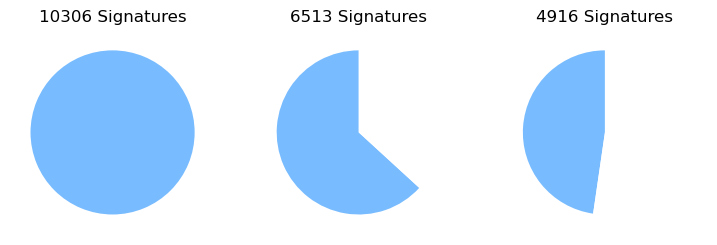

In [ ]:
import matplotlib.pyplot as plt

# Assuming values for n_step_0, n_step_1, and n_step_2 for demonstration
n_step_0 = df_data_info.shape[0]
n_step_1 = len(dsaids_common_gene_ids)
n_step_2 = len(dsaids_matrix)

# Define labels and sizes for the pie charts
sizes_step_0 = [n_step_0, 0]  # Initially, nothing is filtered out
sizes_step_1 = [n_step_1, n_step_0 - n_step_1]
sizes_step_2 = [n_step_2, n_step_0 - n_step_2]

# Define colors for the pie charts
colors = ["#78bcffff", "white"]

# Generate the pie charts without labels or percentages, only colors and titles
fig, ax = plt.subplots(1, 3, figsize=(9, 3))

ax[0].pie(sizes_step_0, colors=colors, startangle=90)
ax[0].set_title(f"{n_step_0} Signatures")
ax[0].set(aspect="equal")
ax[0].set_axis_off()  # Remove borders and ticks

ax[1].pie(sizes_step_1, colors=colors, startangle=90)
ax[1].set_title(f"{n_step_1} Signatures")
ax[1].set(aspect="equal")
ax[1].set_axis_off()  # Remove borders and ticks

ax[2].pie(sizes_step_2, colors=colors, startangle=90)
ax[2].set_title(f"{n_step_2} Signatures")
ax[2].set(aspect="equal")
ax[2].set_axis_off()  # Remove borders and ticks

plt.savefig(
    os.path.join(
        "..", "results", "figures", "DiSignAtlas", f"mesh.data_process.{sparsity}.png"
    ),
    bbox_inches="tight",
    dpi=300,
)

In [ ]:
# get diseases of interest
dsaid_2_disease = dict(df_data_info_processed_filtered[["dsaid", "disease"]].values)


count_diseases = Counter([dsaid_2_disease[dsaid] for dsaid in dsaids_filtered_mesh])
diseases_to_check = [k for k, v in count_diseases.items() if v >= 5]
logging.info(f"Nº of most common diseases in df: {len(diseases_to_check)}")

# get disease to dsaids of interest
disease_2_dsaid_filtered = dict()

all_diseases = df_data_info_processed_filtered["disease"].to_list()
all_dsaids = df_data_info_processed_filtered["dsaid"].to_list()

# loop through all diseases
for disease, dsaid in zip(all_diseases, all_dsaids):
    # loop through diseases of interest
    # if disease in diseases_to_check:
    # check if dsaids are in matrix ids
    if dsaid in dsaids_matrix:
        if disease not in disease_2_dsaid_filtered.keys():
            disease_2_dsaid_filtered[disease] = list()
        disease_2_dsaid_filtered[disease].append(dsaid)


most_common_diseases = [k for k, v in disease_2_dsaid_filtered.items() if len(v) >= 5]

logging.info(f"Nº of most common diseases in matrix: {len(most_common_diseases)}")

2024-05-13 13:27:04,985 - INFO - Nº of most common diseases in df: 209
2024-05-13 13:27:05,163 - INFO - Nº of most common diseases in matrix: 209


In [ ]:
# # get mesh ids of interest
# count_mesh_ids = Counter(
#     [dsaids_2_mesh_ids[dsaid][0] for dsaid in dsaids_filtered_mesh]
# )
# diseases_to_check = [k for k, v in count_mesh_ids.items() if v >= 5]
# logging.info(f"Nº of most common diseases: {len(diseases_to_check)}")

# # get disease to dsaids of interest
# mesh_id_2_dsaid_filtered = dict()

# all_diseases = df_data_info_processed_filtered["disease"].to_list()
# all_dsaids = df_data_info_processed_filtered["dsaid"].to_list()
# all_mesh_ids = [dsaids_2_mesh_ids[dsaid] for dsaid in all_dsaids]

# # loop through all mesh ids
# for mesh_id, dsaid in zip(all_mesh_ids, all_dsaids):
#     # loop through diseases of interest
#     # if disease in diseases_to_check:
#     # check if dsaids are in matrix ids
#     if dsaid in dsaids_matrix:
#         if disease not in mesh_id_2_dsaid_filtered.keys():
#             mesh_id_2_dsaid_filtered[mesh_id[0]] = list()
#         mesh_id_2_dsaid_filtered[mesh_id[0]].append(dsaid)


# most_common_mesh_ids = [k for k, v in mesh_id_2_dsaid_filtered.items() if len(v) >= 5]

# logging.info(f"Size disease to dsaids: {len(most_common_mesh_ids)}")

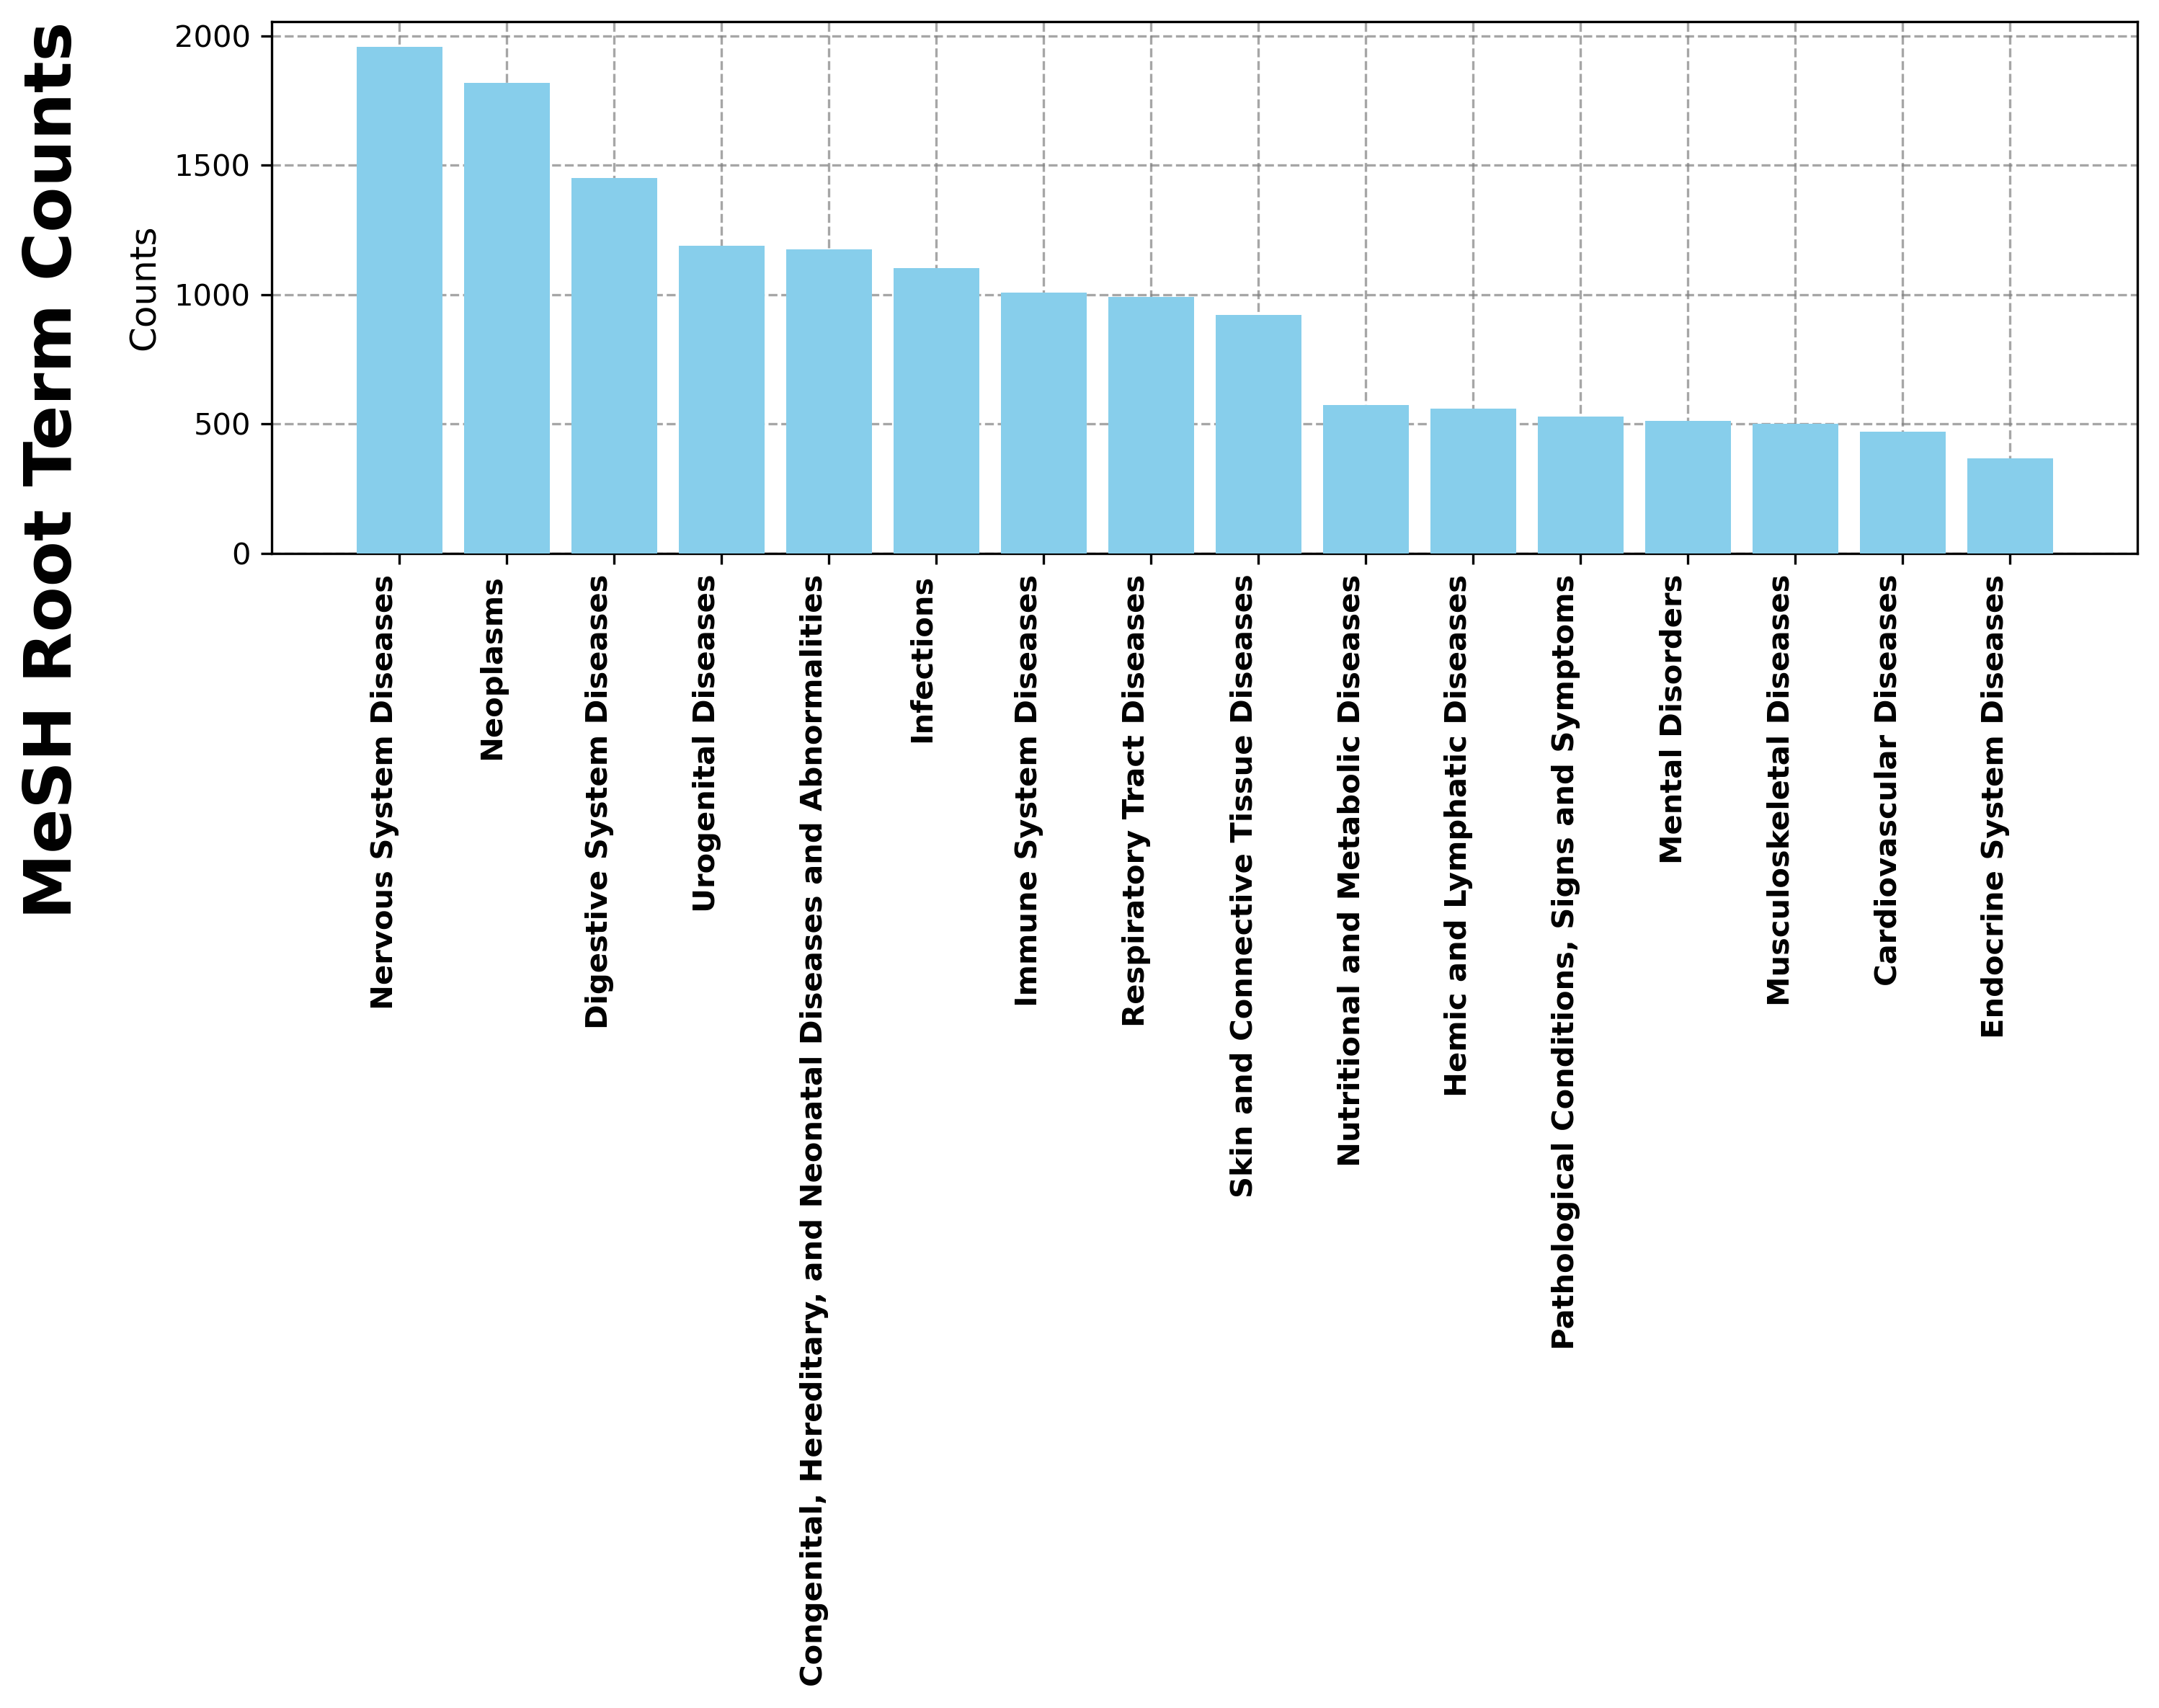

In [ ]:
import xml.etree.ElementTree as ET


mesh_file_path = "../data/MeSH/desc2023.xml"


def build_mesh_term_tree_number_mapping(mesh_xml_file_path: str) -> dict:
    """
    Build a mapping of MeSH terms to their tree numbers from the MeSH XML file.

    Parameters:
    - mesh_xml_file_path (str): The file path to the MeSH XML file.

    Returns:
    - dict: A dictionary where keys are MeSH terms and values are lists of associated tree numbers.
    """
    tree = ET.parse(mesh_xml_file_path)
    root = tree.getroot()

    mesh_term_2_symbol = dict()
    mesh_symbol_2_term = dict()
    for descriptor in root.findall("DescriptorRecord"):
        term = descriptor.find("DescriptorName/String").text
        tree_numbers = [
            tree_number.text
            for tree_number in descriptor.findall("TreeNumberList/TreeNumber")
        ]
        for tree_number in tree_numbers:
            mesh_symbol_2_term[tree_number] = term
        mesh_term_2_symbol[term] = tree_numbers

    return mesh_term_2_symbol, mesh_symbol_2_term


mesh_term_2_symbol, mesh_symbol_2_term = build_mesh_term_tree_number_mapping(
    mesh_file_path
)
from collections import Counter

# Extract root terms

root_terms = [
    term.split(".")[0]
    for k, sublist in dsaids_2_mesh_tree_terms.items()
    for term in sublist
    if k in dsaids_matrix
]


# Count the occurrences of each root category

root_category_counts = Counter(root_terms)


# Result of the root category counting

root_category_counts
import matplotlib.pyplot as plt

sorted_root_categories = sorted(
    root_category_counts.items(), key=lambda x: x[1], reverse=True
)

labels, values = zip(*sorted_root_categories)

labels = [mesh_symbol_2_term.get(k) for k in labels]

# Create the bar plot
fig, ax = plt.subplots(figsize=(10, 8), dpi=300)
plt.bar(labels[:16], values[:16], color="skyblue", zorder=3)

# Manually add a title-like text above the y-axis label
ax.text(
    -0.1,
    1,
    "MeSH Root Term Counts",
    fontsize=22,
    transform=ax.transAxes,
    fontweight="bold",
    va="top",
    ha="right",
    rotation=90,
)

plt.ylabel("Counts", fontsize=12)

# Add grid lines with a white background
ax.set_facecolor("white")
plt.grid(color="grey", linestyle="--", alpha=0.7, zorder=1)

# Set the spines to invisible
for spine in ax.spines.values():
    spine.set_color("0")

# Rotate the category labels for better readability
plt.xticks(rotation=90, ha="right", fontsize=10, fontweight="bold")

plt.tight_layout()
plt.savefig(
    os.path.join(
        "..",
        "results",
        "figures",
        "DiSignAtlas",
        "mesh.diseases.{metric_evaluated}.png",
    ),
    bbox_inches="tight",
    dpi=300,
)

### Compute Similarities

In [ ]:
# imports
from tqdm import tqdm
from scipy.spatial.distance import cdist
from scipy.spatial.distance import pdist, squareform
import random

# variables
k_top = 1
k_percent = 0.2


#  functions
def generate_pairs_2_lists(interest_idxs, rest_idxs, bootstrap=False):
    """Generate pairs of indexes for a given list of indexes
    Arguments:
        - interest_idxs (list): list of indexes
        - rest_idxs (list): list of indexes
    Yields:
        - list: list of pairs of indexes
    """
    for idx_interest in interest_idxs:
        if bootstrap:
            rest_idxs = np.empty(len(interest_idxs) * 100, dtype=int)
            for i in range(100):
                _sample = np.random.choice(
                    rest_idxs, size=len(interest_idxs), replace=True
                )
                rest_idxs[i : (i + 1) * len(interest_idxs)] = _sample
        for idx_other in rest_idxs:
            if idx_interest != idx_other:
                if bootstrap:
                    yield np.array([idx_interest, idx_other], dtype=int)


def generate_pairs_1_list(interest_idxs, unique=True):
    """Generate pairs of indexes for a given list of indexes

    Generators are designed to be memory-efficient by generating
    items one at a time and not keeping them in memory. This means
    they do not have a length or size property like lists or arrays.

    Arguments:
        - interest_idxs (list): list of indexes
    Yields:
        - list: list of pairs of indexes

    """
    if not unique:
        for idx_i, element_i in enumerate(interest_idxs):
            for idx_j, element_j in enumerate(interest_idxs):
                if idx_i != idx_j:
                    yield np.array([element_i, element_j], dtype=int)
    if unique:
        for idx_i, element_i in enumerate(interest_idxs):
            for element_j in interest_idxs[idx_i + 1 :]:
                yield np.array([element_i, element_j], dtype=int)


def get_rest_indexes(interest_idxs, all_indexes, proportion=100):
    """Get rest indexes
    Arguments:
        - interest_idxs (list): list of indexes of interest
        - all_indexes (list): list of all indexes
        - n_random_indexes (int): nº of random indexes
    Returns:
        - random_rest_indexes (list): list of random indexes
    """
    import numpy as np

    # Get subset of indexes for rest
    all_rest_indexes = all_indexes - set(interest_idxs)

    # n_random_indexes
    n_random_indexes = (
        len(interest_idxs) * proportion
        if len(interest_idxs) * proportion < len(all_rest_indexes)
        else len(all_rest_indexes)
    )

    # random indexes withtout replacement - appear once
    random_rest_indexes = np.random.choice(
        list(all_rest_indexes), size=n_random_indexes, replace=False
    )

    return random_rest_indexes


def compute_euclidean_distance(data_matrix_1, data_matrix_2=None):
    """Compute Euclidean Distance
    Arguments:
        - data_matrix_1 (numpy): First matrix of values.
        - data_matrix_2 (numpy, optional): Second matrix of values. If not None, distances are computed between pairs of data_matrix_1 and data_matrix_2.
    Returns:
        - distance_values (numpy.ndarray): Array of Euclidean distance values.
    """
    if data_matrix_2 is not None:
        # Compute distances between data_matrix_1 and data_matrix_2
        distance_matrix = cdist(data_matrix_1, data_matrix_2, metric="euclidean")
    else:
        # Compute pairwise distances within data_matrix_1
        distance_matrix = pdist(data_matrix_1, metric="euclidean")
        # Convert to square form to make it consistent with the cdist output
        distance_matrix = squareform(distance_matrix)

    # Extract the upper triangular part of the correlation matrix, excluding the diagonal
    upper_triangular_indices = np.triu_indices_from(distance_matrix, k=1)
    distance_values = distance_matrix[upper_triangular_indices]

    return distance_values


def compute_cosine_distance(data_matrix_1, data_matrix_2=None):
    """Compute Cosine Distance
    Arguments:
        - data_matrix_1 (numpy): First matrix of values.
        - data_matrix_2 (numpy, optional): Second matrix of values. If not None, distances are computed between pairs of data_matrix_1 and data_matrix_2.
    Returns:
        - distance_values (numpy.ndarray): Array of cosine distance values.
    """
    if data_matrix_2 is not None:
        # Compute distances between data_matrix_1 and data_matrix_2
        distance_matrix = cdist(data_matrix_1, data_matrix_2, metric="cosine")
    else:
        # Compute pairwise distances within data_matrix_1
        distance_matrix = pdist(data_matrix_1, metric="cosine")
        # Convert to square form to make it consistent with the cdist output
        distance_matrix = squareform(distance_matrix)

    # Extract the upper triangular part of the correlation matrix, excluding the diagonal
    upper_triangular_indices = np.triu_indices_from(distance_matrix, k=1)
    distance_values = distance_matrix[upper_triangular_indices]

    return distance_values


def compute_pearson_correlation(data_matrix_1, data_matrix_2=None):
    """Compute Pearson Correlation
    Arguments:
        - matrix (numpy): matrix of values
    Returns:
        - correlation_values (list): correlation list
    """
    # Compute correlation matrix
    if data_matrix_2 is not None:
        correlation_matrix = np.corrcoef(data_matrix_1, data_matrix_2)
        correlation_matrix = correlation_matrix[
            : data_matrix_1.shape[0], data_matrix_1.shape[0] :
        ]
    else:
        correlation_matrix = np.corrcoef(data_matrix_1)

    # Extract the upper triangular part of the correlation matrix, excluding the diagonal
    upper_triangular_indices = np.triu_indices_from(correlation_matrix, k=1)
    correlation_values = correlation_matrix[upper_triangular_indices]
    return correlation_values


def check_old_method_correlation(dsaids_interest, data_matrix):
    """Check old method
    Arguments:
        - dsais_interest (list): list of dsais
    Returns:
        - correlation_values (list): correlation list
    """
    # idxs of interest
    interest_idxs = np.array([dsaids_matrix.index(d) for d in dsaids_interest])

    # matrix interest
    matrix_interest = data_matrix[interest_idxs]
    # Pearson Correlation
    correlation_matrix = np.corrcoef(matrix_interest)

    # Extract the upper triangular part of the correlation matrix, excluding the diagonal
    upper_triangular_indices = np.triu_indices_from(correlation_matrix, k=1)
    correlation_values = correlation_matrix[upper_triangular_indices]
    return np.mean(correlation_values)


def check_old_method_cosine(dsaids_interest, data_matrix):
    """Check old method
    Arguments:
        - dsais_interest (list): list of dsais
    Returns:
        - correlation_values (list): correlation list
    """
    # idxs of interest
    interest_idxs = np.array([dsaids_matrix.index(d) for d in dsaids_interest])

    # matrix interest
    matrix_interest = data_matrix[interest_idxs]

    # Compute pairwise distances within data_matrix_1
    distance_matrix = pdist(matrix_interest, metric="cosine")
    # Convert to square form to make it consistent with the cdist output
    distance_matrix = squareform(distance_matrix)

    # Extract the upper triangular part of the correlation matrix, excluding the diagonal
    upper_triangular_indices = np.triu_indices_from(distance_matrix, k=1)
    distance_values = distance_matrix[upper_triangular_indices]

    return np.mean(distance_values)


def check_old_method_euclidean(dsaids_interest, data_matrix):
    """Check old method
    Arguments:
        - dsais_interest (list): list of dsais
    Returns:
        - correlation_values (list): correlation list
    """
    # idxs of interest
    interest_idxs = np.array([dsaids_matrix.index(d) for d in dsaids_interest])

    # matrix interest
    matrix_interest = data_matrix[interest_idxs]

    # Compute pairwise distances within data_matrix_1
    distance_matrix = pdist(matrix_interest, metric="euclidean")
    # Convert to square form to make it consistent with the cdist output
    distance_matrix = squareform(distance_matrix)

    # Extract the upper triangular part of the correlation matrix, excluding the diagonal
    upper_triangular_indices = np.triu_indices_from(distance_matrix, k=1)
    distance_values = distance_matrix[upper_triangular_indices]

    return np.mean(distance_values)


# compute metrics ONCE - after all we have to do is retrieve data
# pearson correlation
matrix_pearson_correlation = np.corrcoef(data_matrix)

# euclidean distance
_matrix_euclidean_distance = pdist(data_matrix, metric="euclidean")
matrix_euclidean_distance = squareform(_matrix_euclidean_distance)
# cosine distance
_matrix_cosine_distance = pdist(data_matrix, metric="cosine")
matrix_cosine_distance = squareform(_matrix_cosine_distance)

### Plot t-SNE Bias Overview

In [ ]:
df_matrix["accession"].value_counts()[:10]

accession
GSE55276     39
GSE55277     39
GSE93577     25
GSE137108    20
GSE93987     18
GSE66407     16
GSE39411     16
GSE154377    15
GSE216026    14
GSE47927     14
Name: count, dtype: int64

/tmp/ipykernel_227316/2278588174.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap(


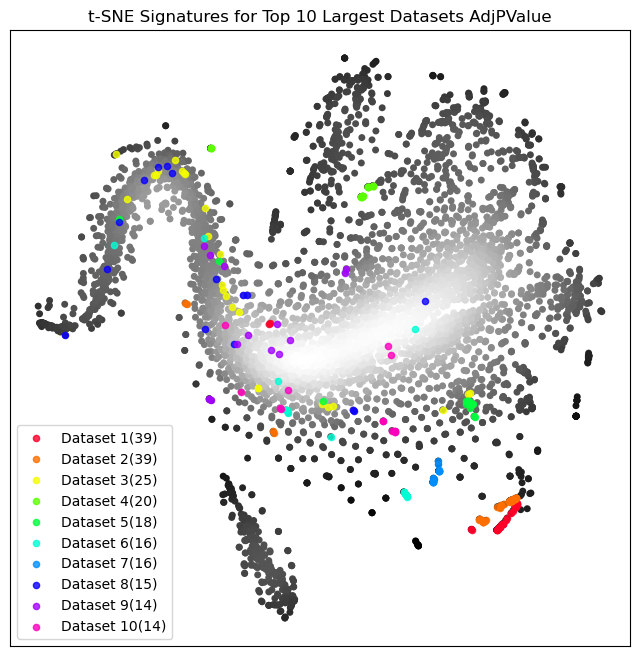

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from scipy.stats import gaussian_kde


# Function to generate N distinct colors using a colormap
def generate_n_colors(n):
    colormap = plt.cm.get_cmap(
        "gist_rainbow", n
    )  # 'viridis' is a good colormap for distinct colors
    colors = colormap(np.linspace(0, 1, n))
    return colors


# Example: Generate 10 distinct colors
n_colors = 10
colors = generate_n_colors(n_colors)

dts = df_matrix["accession"].value_counts()[:10].keys()

# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=2, random_state=0, perplexity=30, learning_rate=10)
embedded_data = tsne.fit_transform(data_matrix)


# Standardize the t-SNE embeddings (important for density calculation)
scaler = StandardScaler()
scaled_embedded_data = scaler.fit_transform(embedded_data)

# Calculate the density of points in the t-SNE space using Gaussian KDE
bandwidth = 0.3  # Bandwidth parameter for KDE
kde = gaussian_kde(scaled_embedded_data.T, bw_method=bandwidth)
density = kde(scaled_embedded_data.T)

# Create a scatter plot with colors based on local density
plt.figure(figsize=(8, 8))
scatter = plt.scatter(
    embedded_data[:, 0],
    embedded_data[:, 1],
    c=density,
    cmap="grey",
    s=25,
    edgecolor="none",
)

# specific indexes
d_disease_2_index = dict()
for i, dt in enumerate(dts):
    # dsaids w/ diseases of interest
    QUERY = f"accession == @dt"
    dsaids_interest = df_matrix.query(QUERY)["dsaid"].to_list()

    # Extract the specific vectors using the list of indexes
    interest_idxs = np.array([dsaids_matrix.index(d) for d in dsaids_interest])

    plt.scatter(
        embedded_data[interest_idxs, 0],
        embedded_data[interest_idxs, 1],
        color=colors[i],
        label=f"Dataset {i+1}({len(interest_idxs)})",
        s=20,
        alpha=0.8,
    )

plt.legend()
# plt.colorbar(scatter, label="Local Density")
plt.title(f"t-SNE Signatures for Top 10 Largest Datasets {metric_evaluated}")
# plt.xlabel("t-SNE Dimension 1")
# plt.ylabel("t-SNE Dimension 2")
plt.xticks([])
plt.yticks([])

plt.savefig(
    os.path.join(
        "..",
        "results",
        "figures",
        "DiSignAtlas",
        f"tsne.{sparsity}.top_datasets.{metric_evaluated}.png",
    ),
    dpi=300,
    bbox_inches="tight",
)

/tmp/ipykernel_227316/4210651750.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap(


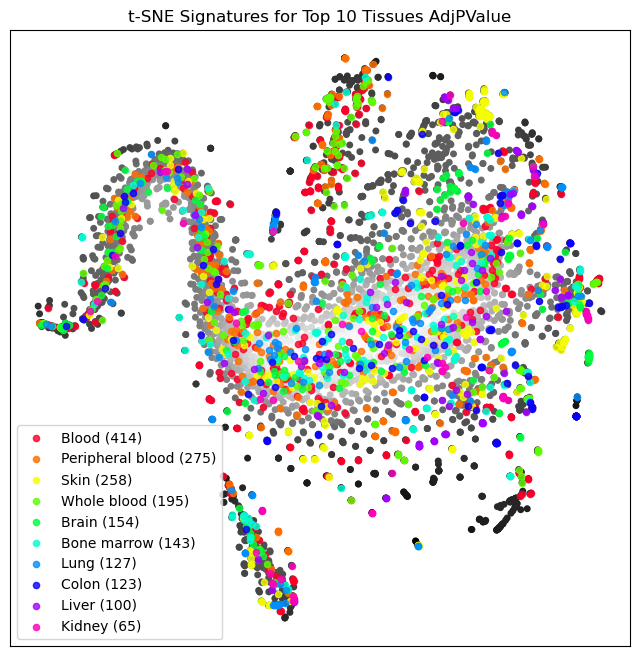

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from scipy.stats import gaussian_kde


# Function to generate N distinct colors using a colormap
def generate_n_colors(n):
    colormap = plt.cm.get_cmap(
        "gist_rainbow", n
    )  # 'viridis' is a good colormap for distinct colors
    colors = colormap(np.linspace(0, 1, n))
    return colors


# Example: Generate 10 distinct colors
n_colors = 10
colors = generate_n_colors(n_colors)

ts = df_matrix["tissue"].value_counts()[:10].keys()

# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=2, random_state=0, perplexity=30, learning_rate=10)
embedded_data = tsne.fit_transform(data_matrix)


# Standardize the t-SNE embeddings (important for density calculation)
scaler = StandardScaler()
scaled_embedded_data = scaler.fit_transform(embedded_data)

# Calculate the density of points in the t-SNE space using Gaussian KDE
bandwidth = 0.3  # Bandwidth parameter for KDE
kde = gaussian_kde(scaled_embedded_data.T, bw_method=bandwidth)
density = kde(scaled_embedded_data.T)

# Create a scatter plot with colors based on local density
plt.figure(figsize=(8, 8))
scatter = plt.scatter(
    embedded_data[:, 0],
    embedded_data[:, 1],
    c=density,
    cmap="grey",
    s=25,
    edgecolor="none",
)

# specific indexes
d_disease_2_index = dict()
for i, t in enumerate(ts):
    # dsaids w/ diseases of interest
    QUERY = f"tissue == @t"
    dsaids_interest = df_matrix.query(QUERY)["dsaid"].to_list()

    # Extract the specific vectors using the list of indexes
    interest_idxs = np.array([dsaids_matrix.index(d) for d in dsaids_interest])

    plt.scatter(
        embedded_data[interest_idxs, 0],
        embedded_data[interest_idxs, 1],
        color=colors[i],
        label=f"{t} ({len(interest_idxs)})",
        s=20,
        alpha=0.8,
    )

plt.legend()
# plt.colorbar(scatter, label="Local Density")
plt.title(f"t-SNE Signatures for Top 10 Tissues {metric_evaluated}")
# plt.xlabel("t-SNE Dimension 1")
# plt.ylabel("t-SNE Dimension 2")
plt.xticks([])
plt.yticks([])

plt.savefig(
    os.path.join(
        "..",
        "results",
        "figures",
        "DiSignAtlas",
        f"tsne.{sparsity}.top_tissues.{metric_evaluated}.png",
    ),
    dpi=300,
    bbox_inches="tight",
)

### Same Dataset different diseases vs Different datasets same disease

In [ ]:
"""Same Dataset different disease vs different dataset same disease
# a. Get dataset cases 
# b. Get similarity metrics
# c. Plot similarity metrics
"""

'Same Dataset different disease vs different dataset same disease\n# a. Get dataset cases \n# b. Get similarity metrics\n# c. Plot similarity metrics\n'

#### a. Get dataset cases

In [ ]:
# get df for matrix dsaids
df_matrix = df_data_info_processed_filtered[
    df_data_info_processed_filtered["dsaid"].isin(dsaids_matrix)
]

In [ ]:
# {dataset} -> {disease}
dataset_2_disease = dict()
for index, row in df_matrix.iterrows():
    dsaid = row["dsaid"]
    disease = row["disease"]
    accession = row["accession"]
    if dsaid in dsaids_matrix:
        if accession not in dataset_2_disease.keys():
            dataset_2_disease[accession] = set()

        dataset_2_disease[accession].add(disease)

In [ ]:
#  {disease} -> [[mesh terms]]
disease_2_mesh_tree_terms = dict()

for index, row in df_matrix.iterrows():
    dsaid_i = row["dsaid"]
    disease_i = row["disease"]
    if dsaid_i in dsaids_matrix:
        # get mesh terms
        mesh_terms = dsaids_2_mesh_tree_terms[dsaid_i]

        if disease_i not in disease_2_mesh_tree_terms.keys():
            disease_2_mesh_tree_terms[disease_i] = []
            disease_2_mesh_tree_terms[disease_i].append(mesh_terms)

        else:
            # check if mesh terms are already in the list
            if set(mesh_terms) != set(disease_2_mesh_tree_terms[disease_i][0]):
                disease_2_mesh_tree_terms[disease_i].append(mesh_terms)

In [ ]:
# get datesets w/ +1 significantly different disease
found_cases = set()
for k, v in dataset_2_disease.items():
    if len(v) > 1:
        for disease_1 in set(v):
            for disease_2 in v:
                if disease_1 != disease_2:
                    mesh_1 = disease_2_mesh_tree_terms.get(disease_1)
                    mesh_1 = [x.split(".")[0] for sublist in mesh_1 for x in sublist]
                    mesh_2 = disease_2_mesh_tree_terms.get(disease_2)
                    mesh_2 = [x.split(".")[0] for sublist in mesh_2 for x in sublist]
                    if len(set(mesh_1) & set(mesh_2)) == 0:
                        found_cases.add(k)

logging.info(
    f"Nº of datasets w/ +1 significantly different disease: {len(found_cases)}"
)

2024-05-13 13:31:31,867 - INFO - Nº of datasets w/ +1 significantly different disease: 59


In [ ]:
def flatten(list_of_lists):
    """Flatten a list of lists into a single list."""
    return [item for sublist in list_of_lists for item in sublist]


def check_related_root(disease_1, disease_2):
    mesh_1 = disease_2_mesh_tree_terms.get(disease_1)
    mesh_2 = disease_2_mesh_tree_terms.get(disease_2)

    mesh_1 = [x.split(".")[0] for x in flatten(mesh_1)]
    mesh_2 = [x.split(".")[0] for x in flatten(mesh_2)]

    if len(mesh_1) > 0 and len(mesh_2) > 0:
        if len(set(mesh_1) & set(mesh_2)) == 0:
            return False
        else:
            return True
    else:
        return False

In [ ]:
# filter datasets which have diseases which appear +5 times
# in other datasets
found_cases_check = set()
found_cases_diseases = dict()
for dataset in tqdm(df_matrix["accession"].unique()):
    pass_filter = False
    QUERY = f"accession == @dataset"
    df_query = df_matrix.query(QUERY)
    disease_counts = df_query["disease"].value_counts()
    diseases = disease_counts[disease_counts >= 2].index.tolist()
    if len(diseases) > 0:
        for disease in diseases:
            QUERY_2 = f"disease == @disease and accession != @dataset"
            df_query_2 = df_matrix.query(QUERY_2)
            if len(df_query_2) >= 2:
                if dataset not in found_cases_diseases.keys():
                    found_cases_diseases[dataset] = list()
                    found_cases_diseases[dataset].append(disease)
                pass_filter = True
    if pass_filter:
        found_cases_check.add(dataset)

logging.info(
    f"Nº of datasets w/ +1 significantly different disease: {len(found_cases_check)}"
)

100%|██████████| 2560/2560 [00:02<00:00, 908.93it/s]
2024-05-13 13:31:35,256 - INFO - Nº of datasets w/ +1 significantly different disease: 769


In [ ]:
df_query_2

,dsaid,accession,platform,deg_count,disease,diseaseid,tissue,data_source,library_strategy,organism,control_case_sample_count,definition


In [ ]:
# filter datasets which have diseases which appear +5 times
# in other datasets
found_cases_check = set()
found_cases_diseases = dict()
for dataset in tqdm(df_matrix["accession"].unique()):
    pass_filter = False
    # Filter diseases w/ 2+ occurrences
    QUERY = f"accession == @dataset"
    df_query = df_matrix.query(QUERY)
    disease_counts = df_query["disease"].value_counts()
    diseases = disease_counts[disease_counts >= 2].index.tolist()

    for disease in diseases:
        # Filter diseases w/ 1+ sign. different diseases
        QUERY_2 = f"disease != @disease and accession == @dataset"
        df_query_2 = df_matrix.query(QUERY_2)
        for disease_2 in df_query_2["disease"].unique():
            if not check_related_root(disease, disease_2):
                QUERY_3 = f"disease == @disease and accession != @dataset"
                df_query_3 = df_matrix.query(QUERY_3)
                if len(df_query_3) >= 2:
                    if dataset not in found_cases_diseases.keys():
                        found_cases_diseases[dataset] = list()
                        found_cases_diseases[dataset].append(disease)
                    pass_filter = True
    if pass_filter:
        found_cases_check.add(dataset)

logging.info(
    f"Nº of datasets w/ +1 significantly different disease: {len(found_cases_check)}"
)

100%|██████████| 2560/2560 [00:02<00:00, 898.08it/s]
2024-05-13 13:31:38,510 - INFO - Nº of datasets w/ +1 significantly different disease: 26


In [ ]:
df_matrix[df_matrix["accession"] == list(found_cases_check)[0]]

,dsaid,accession,platform,deg_count,disease,diseaseid,tissue,data_source,library_strategy,organism,control_case_sample_count,definition
3178,DSA03179,GSE139602,GPL13667,1000,Cirrhosis,C1623038,Liver,GEO,Microarray,Homo sapiens,6|8,MSH:Any pathological condition where fibrous c...
3179,DSA03180,GSE139602,GPL13667,1000,Cirrhosis,C1623038,Liver,GEO,Microarray,Homo sapiens,6|12,MSH:Any pathological condition where fibrous c...
3180,DSA03181,GSE139602,GPL13667,1000,Acute-On-Chronic Liver Failure,C3850141,Liver,GEO,Microarray,Homo sapiens,6|8,EFO:Acute-on-chronic liver failure (ACLF) is a...


In [ ]:
check_related_root("Chronic Myeloid Leukemia", "Acute Myeloid Leukemia (Aml-M2)")

True

#### b. Get similarity metrics

In [ ]:
def generate_matrix_idxs(interest_idxs, rest_idxs=None, bootstrap=False):
    """Generate pairs of indexes for a given list of indexes
    Arguments:
        - interest_idxs (list): list of indexes
        - rest_idxs (list): list of indexes
    Yields:
        - list: list of pairs of indexes
    """

    if rest_idxs is None:  # generate idxs agains itself
        matrix = np.empty((len(interest_idxs), len(interest_idxs) - 1, 2), dtype=int)
        rest_idxs = interest_idxs
    else:
        matrix = np.empty((len(interest_idxs), len(rest_idxs), 2), dtype=int)

    if bootstrap:
        # this is bc when we compare same samples we
        # remove itself - so we do the same here
        n_sample_idxs = len(interest_idxs)
        matrix = np.empty((len(interest_idxs), n_sample_idxs * 100, 2), dtype=int)
        # generate bootstrap indexes
        sample_idxs = np.empty(n_sample_idxs * 100, dtype=int)
        for i in range(100):
            _sample = np.random.choice(rest_idxs, size=n_sample_idxs, replace=True)
            sample_idxs[i * n_sample_idxs : (i + 1) * n_sample_idxs] = _sample

        # redefine rest indexes
        rest_idxs = sample_idxs

    for i, idx_interest in enumerate(interest_idxs):
        j = 0
        for idx_other in rest_idxs:
            if idx_interest != idx_other:  # in case that it is the same list
                matrix[i, j] = [idx_interest, idx_other]
                j += 1
    return matrix

In [ ]:
corr_sameDS_sameDZ = list()
corr_sameDS_diffDZ = list()
corr_diffDS_sameDZ = list()

cosine_sameDS_sameDZ = list()
cosine_sameDS_diffDZ = list()
cosine_diffDS_sameDZ = list()

euc_sameDS_sameDZ = list()
euc_sameDS_diffDZ = list()
euc_diffDS_sameDZ = list()

found_cases_check = list(found_cases_check)
break_true = False
d_how_much = dict()
d_how_much["sameDS_sameDZ"] = list()
d_how_much["diffDS_sameDZ"] = list()
d_how_much["sameDS_diffDZ"] = list()
comparisons = list()
n_cases = 0
for dataset in tqdm(found_cases_check):
    # get diseases
    QUERY = f"accession == @dataset"
    df_query = df_matrix.query(QUERY)

    disease_counts = df_query["disease"].value_counts()
    diseases = found_cases_diseases.get(dataset)

    # define variabels
    corr_sameDS_sameDZ_DZ = list()
    corr_sameDS_diffDZ_DZ = list()
    corr_diffDS_sameDZ_DZ = list()

    cosine_sameDS_sameDZ_DZ = list()
    cosine_sameDS_diffDZ_DZ = list()
    cosine_diffDS_sameDZ_DZ = list()

    euc_sameDS_sameDZ_DZ = list()
    euc_sameDS_diffDZ_DZ = list()
    euc_diffDS_sameDZ_DZ = list()

    # loop through diseases
    for disease in diseases:
        n_cases += 1
        # define variables
        corr_sameDS_sameDZ_DS = list()
        corr_sameDS_diffDZ_DS = list()
        corr_diffDS_sameDZ_DS = list()

        cosine_sameDS_sameDZ_DS = list()
        cosine_sameDS_diffDZ_DS = list()
        cosine_diffDS_sameDZ_DS = list()

        euc_sameDS_sameDZ_DS = list()
        euc_sameDS_diffDZ_DS = list()
        euc_diffDS_sameDZ_DS = list()

        # get same DS same DZ
        QUERY = f"disease == @disease and accession == @dataset"
        df_query = df_matrix.query(QUERY)
        sameDS_sameDZ_dsaid = df_query["dsaid"].to_list()

        # get diff DS same DZ
        QUERY = f"disease != @disease and accession == @dataset"
        df_query = df_matrix.query(QUERY)
        diffDS_sameDZ_dsaid = list()
        for disease_2 in df_query["disease"].to_list():
            if not check_related_root(disease, disease_2):
                passed_dsaids = df_query[df_query["disease"] == disease_2][
                    "dsaid"
                ].to_list()
                diffDS_sameDZ_dsaid.extend(passed_dsaids)
                comparisons.append([disease, disease_2])
        if len(diffDS_sameDZ_dsaid) == 0:
            break

        # get same DS diff DZ
        QUERY = f"disease == @disease and accession != @dataset"
        df_query = df_matrix.query(QUERY)
        sameDS_diffDZ_dsaid = df_query["dsaid"].to_list()

        # get diff DS diff DZ
        QUERY = f"disease != @disease and accession != @dataset"
        df_query = df_matrix.query(QUERY)
        diffDS_diffDZ_dsaid = df_query["dsaid"].to_list()

        d_how_much["sameDS_sameDZ"].append(len(sameDS_sameDZ_dsaid))
        d_how_much["diffDS_sameDZ"].append(len(diffDS_sameDZ_dsaid))
        d_how_much["sameDS_diffDZ"].append(len(sameDS_diffDZ_dsaid))

        # get indexes
        sameDS_sameDZ_idx = np.array(
            [dsaids_matrix.index(d) for d in sameDS_sameDZ_dsaid]
        )
        diffDS_sameDZ_idx = np.array(
            [dsaids_matrix.index(d) for d in diffDS_sameDZ_dsaid]
        )
        sameDS_diffDZ_idx = np.array(
            [dsaids_matrix.index(d) for d in sameDS_diffDZ_dsaid]
        )
        diffDS_diffDZ_idx = np.array(
            [dsaids_matrix.index(d) for d in diffDS_diffDZ_dsaid]
        )

        # generate pair indexes
        sameDS_sameDZ_idxs = generate_matrix_idxs(sameDS_sameDZ_idx, bootstrap=False)
        diffDS_sameDZ_idxs = generate_matrix_idxs(
            sameDS_sameDZ_idx, diffDS_sameDZ_idx, bootstrap=False
        )
        sameDS_diffDZ_idxs = generate_matrix_idxs(
            sameDS_sameDZ_idx, sameDS_diffDZ_idx, bootstrap=False
        )
        background_idxs_pairs = generate_matrix_idxs(
            sameDS_sameDZ_idx, diffDS_diffDZ_idx, bootstrap=False
        )

        # get values sameDS_sameDZ
        for i, row_interest in enumerate(sameDS_sameDZ_idxs):
            # get & store values
            corr_sameDS_sameDZ_DS.append(
                matrix_pearson_correlation[row_interest[:, 0], row_interest[:, 1]]
            )
            cosine_sameDS_sameDZ_DS.append(
                matrix_cosine_distance[row_interest[:, 0], row_interest[:, 1]]
            )
            euc_sameDS_sameDZ_DS.append(
                matrix_euclidean_distance[row_interest[:, 0], row_interest[:, 1]]
            )

        # store values
        corr_sameDS_sameDZ_DZ.append(corr_sameDS_sameDZ_DS)
        cosine_sameDS_sameDZ_DZ.append(cosine_sameDS_sameDZ_DS)
        euc_sameDS_sameDZ_DZ.append(euc_sameDS_sameDZ_DS)

        # get values diffDS_sameDZ
        for i, row_interest in enumerate(diffDS_sameDZ_idxs):
            # get & store values
            corr_diffDS_sameDZ_DS.append(
                matrix_pearson_correlation[row_interest[:, 0], row_interest[:, 1]]
            )
            cosine_diffDS_sameDZ_DS.append(
                matrix_cosine_distance[row_interest[:, 0], row_interest[:, 1]]
            )
            euc_diffDS_sameDZ_DS.append(
                matrix_euclidean_distance[row_interest[:, 0], row_interest[:, 1]]
            )

        # store values
        corr_diffDS_sameDZ_DZ.append(corr_diffDS_sameDZ_DS)
        cosine_diffDS_sameDZ_DZ.append(cosine_diffDS_sameDZ_DS)
        euc_diffDS_sameDZ_DZ.append(euc_diffDS_sameDZ_DS)

        # get values sameDS_diffDZ
        for i, row_interest in enumerate(sameDS_diffDZ_idxs):
            # get & store values
            corr_sameDS_diffDZ_DS.append(
                matrix_pearson_correlation[row_interest[:, 0], row_interest[:, 1]]
            )

            cosine_sameDS_diffDZ_DS.append(
                matrix_cosine_distance[row_interest[:, 0], row_interest[:, 1]]
            )
            euc_sameDS_diffDZ_DS.append(
                matrix_euclidean_distance[row_interest[:, 0], row_interest[:, 1]]
            )

        # store values

        corr_sameDS_diffDZ_DZ.append(corr_sameDS_diffDZ_DS)
        cosine_sameDS_diffDZ_DZ.append(cosine_sameDS_diffDZ_DS)
        euc_sameDS_diffDZ_DZ.append(euc_sameDS_diffDZ_DS)

    # store values
    corr_sameDS_sameDZ.append(corr_sameDS_sameDZ_DZ)
    cosine_sameDS_sameDZ.append(cosine_sameDS_sameDZ_DZ)
    euc_sameDS_sameDZ.append(euc_sameDS_sameDZ_DZ)

    corr_sameDS_diffDZ.append(corr_sameDS_diffDZ_DZ)
    cosine_sameDS_diffDZ.append(cosine_sameDS_diffDZ_DZ)
    euc_sameDS_diffDZ.append(euc_sameDS_diffDZ_DZ)

    corr_diffDS_sameDZ.append(corr_diffDS_sameDZ_DZ)
    cosine_diffDS_sameDZ.append(cosine_diffDS_sameDZ_DZ)
    euc_diffDS_sameDZ.append(euc_diffDS_sameDZ_DZ)

100%|██████████| 26/26 [00:03<00:00,  8.11it/s]


In [ ]:
comparisons

[['Cirrhosis', 'Acute-On-Chronic Liver Failure'],
 ['Coeliac Disease', 'Multiple Sclerosis'],
 ['Coeliac Disease', 'Multiple Sclerosis'],
 ['Coeliac Disease', 'Systemic Lupus Erythematosus'],
 ['Coeliac Disease', 'Systemic Lupus Erythematosus'],
 ['Sepsis', 'Juvenile Dermatomyositis'],
 ['Sepsis', 'Kawasaki Disease'],
 ['Sepsis', 'Melanoma'],
 ['Sepsis', 'Multiple Sclerosis'],
 ['Sepsis', 'Systemic Lupus Erythematosus'],
 ['Sepsis', 'Systemic-Onset Juvenile Idiopathic Arthritis'],
 ['Q Fever', 'Chronic Fatigue Syndrome'],
 ['Sepsis', 'Anaphylaxis'],
 ['Sepsis', 'Anaphylaxis'],
 ['Acute Myeloid Leukemia', 'Myelodysplastic Syndrome'],
 ['Breast Cancer', 'Sepsis'],
 ['Breast Cancer', 'Sepsis'],
 ['Sarcoidosis', 'Pneumonia'],
 ['Sarcoidosis', 'Tuberculosis'],
 ['Atherosclerosis', 'Systemic Lupus Erythematosus'],
 ['Atherosclerosis', 'Systemic Lupus Erythematosus'],
 ['Type 1 Diabetes', 'Bacterial Pneumonia'],
 ['Common Variable Immunodeficiency', 'Coeliac Disease'],
 ['Cirrhosis', 'Acute-O

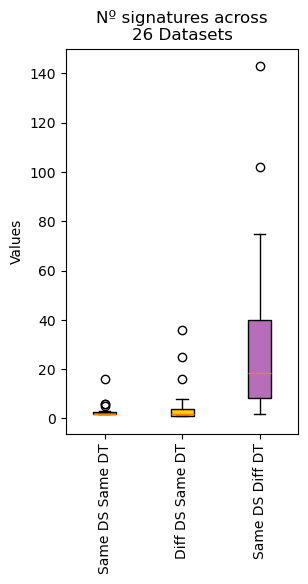

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Extracting the data into variables
v1 = d_how_much["sameDS_sameDZ"]
v2 = d_how_much["diffDS_sameDZ"]
v3 = d_how_much["sameDS_diffDZ"]

# Specified labels and colors for the boxplots
labels = ["Same DS Same DT", "Diff DS Same DT", "Same DS Diff DT"]
colors = {0: "#7ABA7A", 1: "#FFCC00", 2: "#B76EB8"}

# Creating the boxplots with specific labels and colors
fig, ax = plt.subplots(figsize=(3, 5))
bplot = ax.boxplot([v1, v2, v3], patch_artist=True)

# Coloring each box
for patch, color in zip(bplot["boxes"], colors.values()):
    patch.set_facecolor(color)

# Setting labels for each boxplot
ax.set_xticklabels(labels, rotation=90)


# Adding titles and labels
ax.set_title(f"Nº signatures across\n{len(v1)} Datasets")
ax.set_ylabel("Values")

# Showing the plot
plt.savefig(
    os.path.join(
        "..",
        "results",
        "figures",
        "DiSignAtlas",
        f"boxplot.how_much.{metric_evaluated}.png",
    ),
    dpi=300,
    bbox_inches="tight",
)

In [ ]:
found_cases_diseases.get(dataset)

['Chronic Mucocutaneous Candidiasis']

In [ ]:
corr_diffDS_sameDZ[4]

[[array([0.07728013, 0.08751896, 0.07728013, 0.08751896]),
  array([0.07756883, 0.07683896, 0.07756883, 0.07683896])]]

#### c. Plot similarity metrics

In [ ]:
# imports
from scipy.stats import ks_2samp


# functions
def create_composite_histogram_dz_ds(distributions, bin_edges):
    """
    Create a composite histogram from multiple distributions.

    Parameters:
    - distributions: List of arrays, each representing a distribution of points.
    - bin_edges: Array of bin edges to use for all histograms.

    Returns:
    - composite_histogram: The composite histogram (sum of normalized histograms).
    """
    # Initialize an array to hold the sum of all normalized histograms
    counts_composite_histogram = np.zeros_like(bin_edges[:-1], dtype=float)

    # Iterate over each distribution
    for dist_dz in distributions:
        for dist_ds in dist_dz:
            # dist_values = dist.flatten()
            dist_values = flatten(dist_ds)
            # Calculate the histogram for this distribution
            counts, _ = np.histogram(dist_values, bins=bin_edges)

            # Normalize the histogram by the number of points in the distribution
            normalized_counts = counts / len(dist_values)

            # Add the normalized histogram to the composite histogram
            counts_composite_histogram += normalized_counts

    return counts_composite_histogram


def create_composite_histogram(distributions, bin_edges):
    """
    Create a composite histogram from multiple distributions.

    Parameters:
    - distributions: List of arrays, each representing a distribution of points.
    - bin_edges: Array of bin edges to use for all histograms.

    Returns:
    - composite_histogram: The composite histogram (sum of normalized histograms).
    """
    # Initialize an array to hold the sum of all normalized histograms
    counts_composite_histogram = np.zeros_like(bin_edges[:-1], dtype=float)

    # Iterate over each distribution
    for dist in distributions:
        # dist_values = dist.flatten()
        dist_values = flatten(flatten(dist))
        # Calculate the histogram for this distribution
        counts, _ = np.histogram(dist_values, bins=bin_edges)

        # Normalize the histogram by the number of points in the distribution
        normalized_counts = counts / len(dist_values)

        # Add the normalized histogram to the composite histogram
        counts_composite_histogram += normalized_counts

    return counts_composite_histogram


def format_p_value_std(mean, std):
    """Format the mean and standard deviation. Append an asterisk if mean < 0.05."""
    formatted_mean = f"{mean:.4e}" if mean < 0.0001 else f"{mean:.4f}"
    formatted_std = f"{std:.4e}" if std < 0.0001 else f"{std:.4f}"
    return f"{formatted_mean}±{formatted_std}" + ("*" if mean < 0.05 else "")


def plot_metrics(
    values_list,
    ks_values_list,
    labels,
    vector_type,
    metric_list,
    cap_value=None,
    save=True,
    sparsity="HS",
    dz_ds=False,
):

    # define variables

    colors = {0: "#7ABA7A", 1: "#FFCC00", 2: "#B76EB8"}
    metric, filtering = metric_list
    title_txt = f"{metric} {filtering} {vector_type} "
    e_max = 10
    e_step = 0.5
    if cap_value is not None:
        title_txt = f"{metric} {filtering} {vector_type} (capped)"
        e_max = cap_value
        e_step = cap_value / 100
    fixed_bins_dict = {
        "p_correlation": np.arange(-1, 1.01, 0.05),
        "cosine": np.arange(0, 2.01, 0.05),
        "euclidean": np.arange(0, e_max, e_step),
    }

    fixed_bins = fixed_bins_dict.get(metric)

    plt.figure(figsize=(4.5, 4.5))

    # loop through values
    for i in range(len(values_list)):
        # define values
        values = values_list[i]
        label = labels[i]
        color = colors[i]

        alpha = 0.5

        # compute normalized density counts for each distribution

        if dz_ds:
            counts = create_composite_histogram_dz_ds(values, fixed_bins)
        else:
            counts = create_composite_histogram(values, fixed_bins)
        bin_centers = 0.5 * (fixed_bins[1:] + fixed_bins[:-1])

        # Spline Interpolation for connecting midpoints
        spline = make_interp_spline(bin_centers, counts, k=1)  # k=3 for cubic spline
        fine_bin_centers = np.linspace(bin_centers.min(), bin_centers.max(), 300)
        fine_counts = spline(fine_bin_centers)

        # Plot interpolated line
        plt.plot(
            fine_bin_centers,
            fine_counts,
            color=color,
            label=label,
            linewidth=2.5,
        )
        plt.fill_between(fine_bin_centers, fine_counts, alpha=alpha, color=color)

    title_txt = title_txt[:35] + "..." if len(title_txt) > 40 else title_txt

    formatted_parts = [format_p_value_std(mean, std) for mean, std in ks_values_list]

    # Constructing the full title
    title = (
        "Same DS same DT vs diff DS same DT: {}\n"
        "Same DS same DT vs same DS diff DT: {}"
    ).format(*formatted_parts)
    plt.title(title, fontsize=10)
    plt.suptitle(title_txt, y=0.95)
    plt.legend()
    plt.xlabel(f"{vector_type} {metric} {filtering}")
    plt.xlim(np.min(fixed_bins), np.max(fixed_bins))
    plt.ylim(
        0,
    )
    plt.ylabel("Density")
    plt.grid(linestyle="--")
    plt.tight_layout()

    if save:
        plt.savefig(
            os.path.join(
                "..",
                "results",
                "figures",
                "DiSignAtlas",
                f"{metric}{filtering}.dataset_vs_disease.mesh.{sparsity}.{vector_type}.png",
            ),
            dpi=300,
            bbox_inches="tight",
        )


def flatten(list_of_lists):
    """Flatten a list of lists into a single list."""
    return [item for sublist in list_of_lists for item in sublist]


def get_ks_statistics_subsamples_all(
    list_matrix_1, list_matrix_2, resampling_1=False, resampling_2=True
):
    """Get KS Statistics All
    Arguments:
        - list_matrix_1 (list): list of matrices
        - list_matrix_2 (list): list of matrices
    Returns:
        - ks_p_values_mean (float): mean p-values
        - ks_p_values_std (float): std p-values
    """
    ks_p_values_means = list()
    # we want to evaluate diseases which are contained in the dataset!

    for i in range(len(list_matrix_1)):
        # mean of statistics within a diseases
        if resampling_1 & resampling_2:
            ks_p_values_mean_disease = np.mean(
                [
                    ks_2samp(s_p_1, s_p_2.flatten())[0]
                    for (s_p_1, s_p_2) in zip(list_matrix_1[i], list_matrix_2[i])
                ]
            )
        elif resampling_2 & (not resampling_1):
            p_1 = list_matrix_1[i].flatten()
            ks_p_values_mean_disease = np.mean(
                [ks_2samp(p_1, s_p_2.flatten())[0] for s_p_2 in list_matrix_2[i]]
            )
        elif (not resampling_1) & (not resampling_2):
            # p_1 = list_matrix_1[i].flatten()
            # p_2 = list_matrix_2[i].flatten()
            p_1 = flatten(list_matrix_1[i])
            p_2 = flatten(list_matrix_2[i])
            ks_p_values_mean_disease = ks_2samp(p_1, p_2)[0]

        ks_p_values_means.append(ks_p_values_mean_disease)

    ks_p_values_mean_of_means = np.mean(ks_p_values_means)
    ks_p_values_std_of_means = np.std(ks_p_values_means)

    return ks_p_values_mean_of_means, ks_p_values_std_of_means

In [ ]:
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
from matplotlib.colors import LinearSegmentedColormap, to_rgba_array
from scipy.interpolate import make_interp_spline
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
from matplotlib.colors import LinearSegmentedColormap, to_rgba_array
from scipy.interpolate import make_interp_spline


def get_ks_statistics_all(list_matrix_1, list_matrix_2, numpy=True):
    """Get KS Statistics All
    Arguments:
        - list_matrix_1 (list): list of matrices
        - list_matrix_2 (list): list of matrices
    Returns:
        - ks_p_values_mean (float): mean p-values
        - ks_p_values_std (float): std p-values
    """
    if numpy:
        ks_p_values_mean = np.mean(
            [
                ks_2samp(p_1.flatten(), p_2.flatten())[1]
                for p_1, p_2 in zip(list_matrix_1, list_matrix_2)
            ]
        )
        ks_p_values_std = np.std(
            [
                ks_2samp(p_1.flatten(), p_2.flatten())[1]
                for p_1, p_2 in zip(list_matrix_1, list_matrix_2)
            ]
        )
    else:
        # flatten
        list_matrix_1 = [x for sublist in list_matrix_1 for x in sublist]
        list_matrix_2 = [x for sublist in list_matrix_2 for x in sublist]

        ks_p_values_mean = np.mean(
            [ks_2samp(p_1, p_2)[1] for p_1, p_2 in zip(list_matrix_1, list_matrix_2)]
        )
        ks_p_values_std = np.std(
            [ks_2samp(p_1, p_2)[1] for p_1, p_2 in zip(list_matrix_1, list_matrix_2)]
        )
    return ks_p_values_mean, ks_p_values_std

##### c.1 Pearson Correlation

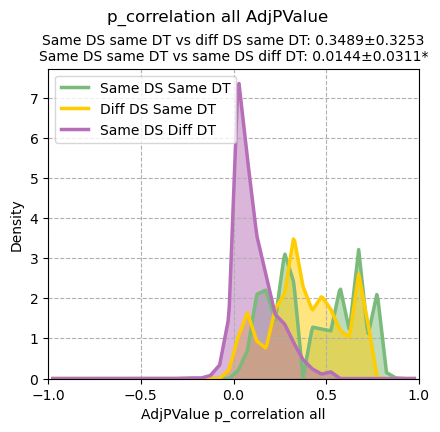

In [ ]:
value_1, value_2, value_3 = corr_sameDS_sameDZ, corr_diffDS_sameDZ, corr_sameDS_diffDZ


# get ks_values

values_list = [value_1, value_2, value_3]

ks_p_mean = list()
for i in range(len(value_1)):
    for j in range(len(value_1[i])):
        ks_p = ks_2samp(flatten(value_1[i][j]), flatten(value_2[i][j]))[1]
        ks_p_mean.append(ks_p)

ks_1_mean, ks_1_std = np.mean(ks_p_mean), np.std(ks_p_mean)


ks_p_mean = list()
for i in range(len(value_1)):
    for j in range(len(value_1[i])):
        ks_p = ks_2samp(flatten(value_1[i][j]), flatten(value_3[i][j]))[1]
        ks_p_mean.append(ks_p)

ks_2_mean, ks_2_std = np.mean(ks_p_mean), np.std(ks_p_mean)

ks_values_list = [[ks_1_mean, ks_1_std], [ks_2_mean, ks_2_std], [0, 0]]

labels = [
    "Same DS Same DT",
    "Diff DS Same DT",
    "Same DS Diff DT",
]

plot_metrics(
    values_list=values_list,
    ks_values_list=ks_values_list,
    labels=labels,
    vector_type=metric_evaluated,
    metric_list=["p_correlation", "all"],
    save=True,
    dz_ds=True,
)

##### c.2 Cosine Distance

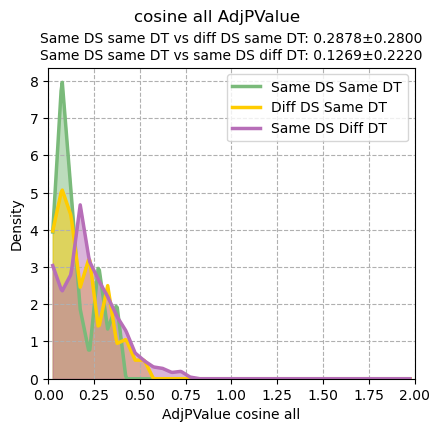

In [ ]:
value_1, value_2, value_3 = (
    cosine_sameDS_sameDZ,
    cosine_diffDS_sameDZ,
    cosine_sameDS_diffDZ,
)


# get ks_values

values_list = [value_1, value_2, value_3]

ks_p_mean = list()
for i in range(len(value_1)):
    for j in range(len(value_1[i])):
        ks_p = ks_2samp(flatten(value_1[i][j]), flatten(value_2[i][j]))[1]
        ks_p_mean.append(ks_p)

ks_1_mean, ks_1_std = np.mean(ks_p_mean), np.std(ks_p_mean)


ks_p_mean = list()
for i in range(len(value_1)):
    for j in range(len(value_1[i])):
        ks_p = ks_2samp(flatten(value_1[i][j]), flatten(value_3[i][j]))[1]
        ks_p_mean.append(ks_p)

ks_2_mean, ks_2_std = np.mean(ks_p_mean), np.std(ks_p_mean)

ks_values_list = [[ks_1_mean, ks_1_std], [ks_2_mean, ks_2_std], [0, 0]]

labels = [
    "Same DS Same DT",
    "Diff DS Same DT",
    "Same DS Diff DT",
]

plot_metrics(
    values_list=values_list,
    ks_values_list=ks_values_list,
    labels=labels,
    vector_type=metric_evaluated,
    metric_list=["cosine", "all"],
    save=True,
    dz_ds=True,
)

##### c.3 Euclidean Distance

In [ ]:
# define values
step = 25
cap_val = (
    500
    if 500 < np.max(matrix_euclidean_distance)
    else np.max(matrix_euclidean_distance) + 1
)


# Function to cap values at a specific limit
def cap_values_at_limit(values, limit):
    return np.where(values > limit, limit, values)

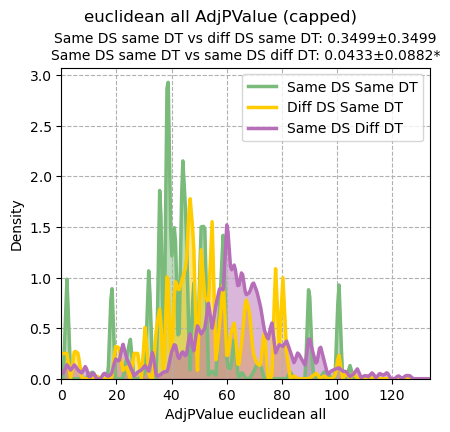

In [ ]:
value_1, value_2, value_3 = (
    euc_sameDS_sameDZ,
    euc_diffDS_sameDZ,
    euc_sameDS_diffDZ,
)


# get ks_values

values_list = [value_1, value_2, value_3]

ks_p_mean = list()
for i in range(len(value_1)):
    for j in range(len(value_1[i])):
        ks_p = ks_2samp(flatten(value_1[i][j]), flatten(value_2[i][j]))[1]
        ks_p_mean.append(ks_p)

ks_1_mean, ks_1_std = np.mean(ks_p_mean), np.std(ks_p_mean)


ks_p_mean = list()
for i in range(len(value_1)):
    for j in range(len(value_1[i])):
        ks_p = ks_2samp(flatten(value_1[i][j]), flatten(value_3[i][j]))[1]
        ks_p_mean.append(ks_p)

ks_2_mean, ks_2_std = np.mean(ks_p_mean), np.std(ks_p_mean)

ks_values_list = [[ks_1_mean, ks_1_std], [ks_2_mean, ks_2_std], [0, 0]]

labels = [
    "Same DS Same DT",
    "Diff DS Same DT",
    "Same DS Diff DT",
]

plot_metrics(
    values_list=values_list,
    ks_values_list=ks_values_list,
    labels=labels,
    vector_type=metric_evaluated,
    metric_list=["euclidean", "all"],
    save=True,
    dz_ds=True,
    cap_value=cap_val,
)

/tmp/ipykernel_44752/3747618093.py:8: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hc.linkage(DF_dism, method="average")


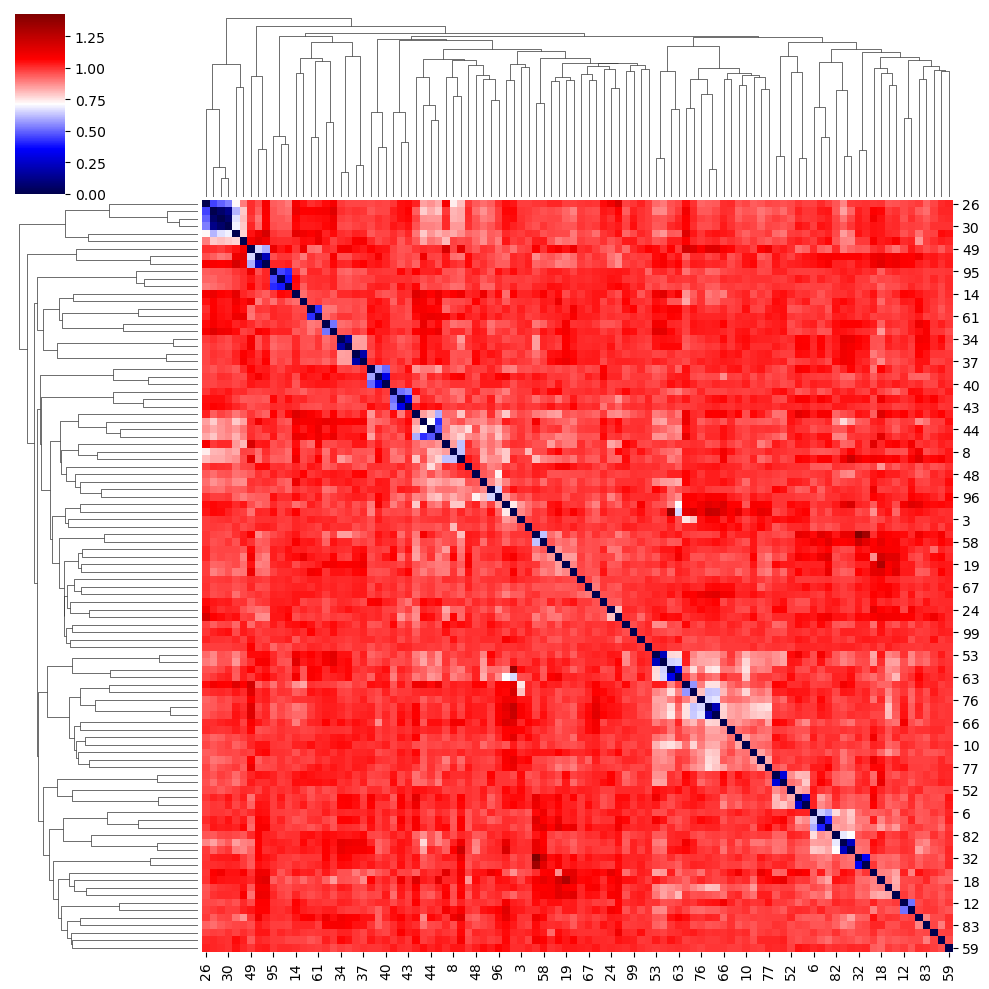

In [ ]:
import pandas as pd, seaborn as sns
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
from sklearn.datasets import load_iris

# sns.set(font="monospace")

DF_dism = matrix_cosine_distance[:100, :100]
linkage = hc.linkage(DF_dism, method="average")

# Create a cluster map
g = sns.clustermap(DF_dism, row_linkage=linkage, col_linkage=linkage, cmap="seismic")

In [ ]:
# Extract labels for a given number of clusters, for example, 3 clusters
from scipy.cluster.hierarchy import fcluster

cluster_labels = fcluster(linkage, 3, criterion="maxclust")

In [ ]:
list(cluster_labels).count(1)

36

In [ ]:
for x in corr_sameDS_sameDZ:
    print(flatten(flatten(x)))

[0.09252383427468831, 0.10941923623097109, 0.19170671423648514, 0.10381040291453143, 0.09252383427468831, 0.15546885774677272, 0.24441529824114658, 0.05785720413238599, 0.10941923623097109, 0.15546885774677272, 0.24870570130302938, 0.09194139087640524, 0.19170671423648517, 0.2444152982411466, 0.24870570130302935, 0.12820209785141548, 0.10381040291453145, 0.057857204132385986, 0.09194139087640525, 0.12820209785141548, -0.007714606290446033, -0.001071549219388153, 0.040810398731468744, 0.023979424947876856, -0.007714606290446032, 0.2362119024447427, 0.22877741998956994, 0.04260850073092879, -0.001071549219388153, 0.2362119024447427, 0.45363211270389336, 0.06585533120017975, 0.04081039873146875, 0.2287774199895699, 0.45363211270389336, 0.0673171591804893, 0.023979424947876853, 0.04260850073092879, 0.06585533120017975, 0.06731715918048932, 0.020670668928109332, -0.04010915548008778, -0.07247493380895663, 0.027768183492164752, 0.020670668928109332, 0.14678417301216154, 0.16953776680798172, 

### Same Dataset Correlation

#### a. Get cases

In [ ]:
# how many datasets do we have w/ 5+ signatures
def get_top_datasets(df_matrix):
    """Get top datasets
    Arguments:
        - df_matrix (pd.DataFrame): dataframe
    Returns:
        - top_datasets (list): list of datasets
    """
    top_datasets = list()
    for dataset in df_matrix["accession"].unique():
        QUERY = f"accession == @dataset"
        df_query = df_matrix.query(QUERY)
        if len(df_query) >= 5:
            top_datasets.append(dataset)
    return top_datasets


# get top datasets
top_datasets = get_top_datasets(df_matrix)

logging.info(f"Nº of datasets w/ 5+ signatures: {len(top_datasets)}")

2024-04-25 13:07:38,610 - INFO - Nº of datasets w/ 5+ signatures: 125


In [ ]:
# how many datasets do we have w/ 5+ signatures
def get_top_datasets(df_matrix):
    """Get top datasets
    Arguments:
        - df_matrix (pd.DataFrame): dataframe
    Returns:
        - top_datasets (list): list of datasets
    """
    top_datasets = list()
    for dataset in df_matrix["accession"].unique():
        QUERY = f"accession == @dataset"
        df_query = df_matrix.query(QUERY)
        if len(df_query) >= 5:
            top_datasets.append(dataset)
    return top_datasets


# get top datasets
top_datasets = get_top_datasets(df_matrix)

logging.info(f"Nº of datasets w/ 5+ signatures: {len(top_datasets)}")

In [ ]:
df_matrix.query(QUERY)

,dsaid,accession,platform,deg_count,disease,diseaseid,tissue,data_source,library_strategy,organism,control_case_sample_count,definition
3,DSA00004,GSE224022,GPL16791,1000,Retinoblastoma,C0035335,Retina,GEO,RNA-Seq,Homo sapiens,4|5,DO:A retinal cell cancer and malignant neoplas...
4,DSA00005,GSE126342,GPL11154,1000,Congenital Myotonic Dystrophy,C0410226,Skeletal muscle,GEO,RNA-Seq,Homo sapiens,9|11,MONDO:An inherited progressive disorder affect...
5,DSA00006,GSE126342,GPL11154,1000,Myotonic Dystrophy Type 1,C0027126,Skeletal muscle,GEO,RNA-Seq,Homo sapiens,6|16,DO:A myotonic disease that is characterized by...
8,DSA00009,GSE223245,GPL33038,0,Brain Damage,C0006109,Whole blood,GEO,Microarray,Homo sapiens,4|4,MONDO:Chronic form of encephalitis.
9,DSA00010,GSE223245,GPL33038,0,Brain Damage,C0006109,Whole blood,GEO,Microarray,Homo sapiens,4|4,MONDO:Chronic form of encephalitis.
...,...,...,...,...,...,...,...,...,...,...,...,...
10300,DSA10301,GSE6008,GPL96,1000,Ovarian Tumor,C1140680,Ovary,GEO,Microarray,Homo sapiens,4|13,DO:A female reproductive organ cancer that is ...
10301,DSA10302,GSE6008,GPL96,1000,Ovarian Tumor,C1140680,Ovary,GEO,Microarray,Homo sapiens,4|41,DO:A female reproductive organ cancer that is ...
10302,DSA10303,GSE6280,GPL96,758,Kidney Tumor,C0022665,Kidney,GEO,Microarray,Homo sapiens,6|14,DO:A urinary system cancer that is located_in ...
10304,DSA10305,GSE6344,GPL96,1000,Clear Cell Ependymoma,C1384403,Kidney,GEO,Microarray,Homo sapiens,5|5,"EFO:A WHO grade II, slow growing tumor of chil..."


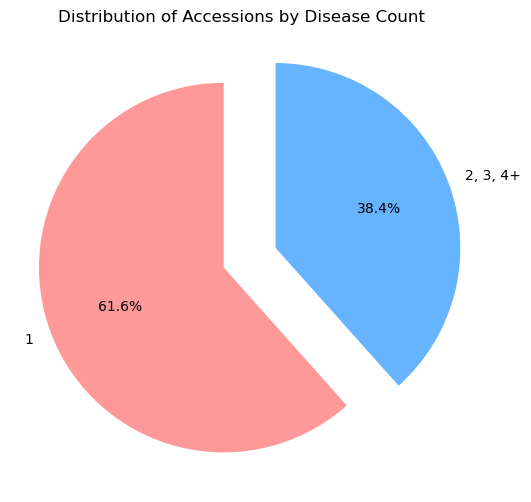

In [ ]:
QUERY = "accession in @top_datasets"
disease_count = (
    df_matrix.query(QUERY).groupby("accession")["disease"].nunique().reset_index()
)

# Categorize the counts into 1, 2, 3, 4+
disease_count["disease_category"] = pd.cut(
    disease_count["disease"],
    bins=[0, 1, 2, 3, float("inf")],
    labels=["1", "2", "3", "4+"],
    right=True,
)

# Count the number of accessions in each category
category_counts = disease_count["disease_category"].value_counts().sort_index()

# Combine categories '2', '3', '4+' into one group
combined_categories_count = category_counts["2":].sum()
final_counts = [category_counts["1"], combined_categories_count]
labels = ["1", "2, 3, 4+"]

# Define colors and explode settings
colors = ["#ff9999", "#66b3ff"]
explode = (0.1, 0.2)  # explode both, with category '1' less than '2, 3, 4+'

# Plotting the pie chart
plt.figure(figsize=(8, 6))
plt.pie(
    final_counts,
    labels=labels,
    autopct="%1.1f%%",
    startangle=90,
    colors=colors,
    explode=explode,
)
plt.title("Distribution of Accessions by Disease Count")
plt.show()

In [ ]:
disease_count

,accession,disease,disease_category
0,E-MTAB-10318,2,2
1,E-MTAB-1791,3,3
2,E-MTAB-5464,2,2
3,E-MTAB-6018,1,1
4,E-MTAB-7406,1,1
...,...,...,...
120,GSE92506,1,1
121,GSE93577,1,1
122,GSE93776,1,1
123,GSE93987,3,3


#### b. Get similarity metrics

In [ ]:
bootstrap = True
n_diseases = len(top_datasets)

correlation_values_dataset_all = list()
correlation_values_non_dataset_all = list()

cosine_values_dataset_all = list()
cosine_values_non_dataset_all = list()

euclidean_values_dataset_all = list()
euclidean_values_non_dataset_all = list()

# get values
quality_check = random.choice(list(range(len(top_datasets))))
logging.info(f"Quality check: {quality_check} {top_datasets[quality_check]}")

all_indexes = set(range(data_matrix.shape[0]))

for count, dataset in enumerate(tqdm(top_datasets)):  # loop through diseases of dataset
    # dsaids w/ diseases of dataset
    QUERY = f"accession == @dataset"
    dsaids_dataset = df_matrix.query(QUERY)["dsaid"].to_list()

    related_dsaids = list()
    non_dataset_dsaids = list()

    # Extract the specific vectors using the list of indexes
    dataset_idxs = [dsaids_matrix.index(d) for d in dsaids_dataset]

    # dataset indexes pairs
    """We have a list of lists in which we have
    for each disease signature of dataset (row of a matrix) a list in which 
    we will have all the combination of pairs"""

    n_dataset = len(dataset_idxs)

    # compute how many pairs we will have
    n_dataset_unique = int(n_dataset * (n_dataset - 1) / 2)
    n_dataset_all = int(n_dataset * n_dataset)

    dataset_idxs_pairs = np.empty((n_dataset, n_dataset - 1, 2), dtype=int)
    dataset_idxs_pairs_unique = np.empty((n_dataset_unique, 2), dtype=int)

    # generate pairs (all vs all)
    matrix_dataset_idxs_pairs = generate_matrix_idxs(dataset_idxs, bootstrap=False)

    # define matrix to store values
    matrix_correlation_values_dataset = np.empty(
        (n_dataset, n_dataset - 1), dtype=float
    )

    matrix_cosine_values_dataset = np.empty((n_dataset, n_dataset - 1), dtype=float)

    matrix_euclidean_values_dataset = np.empty((n_dataset, n_dataset - 1), dtype=float)

    # itereate through all dataset signatures
    for i, row_dataset in enumerate(matrix_dataset_idxs_pairs):
        # get values
        correlation_values_dataset = matrix_pearson_correlation[
            row_dataset[:, 0], row_dataset[:, 1]
        ]
        cosine_values_dataset = matrix_cosine_distance[
            row_dataset[:, 0], row_dataset[:, 1]
        ]
        euclidean_values_dataset = matrix_euclidean_distance[
            row_dataset[:, 0], row_dataset[:, 1]
        ]

        # store values
        matrix_correlation_values_dataset[i] = correlation_values_dataset
        matrix_cosine_values_dataset[i] = cosine_values_dataset
        matrix_euclidean_values_dataset[i] = euclidean_values_dataset

    # get non dataset indexes
    rest_dsaids = list(set(dsaids_matrix) - set(dsaids_dataset))

    # get idx position related and non_dataset
    non_dataset_idxs = [dsaids_matrix.index(d) for d in rest_dsaids]

    # get nº
    n_non_dataset = len(non_dataset_idxs)

    # generate matrix indexes pairs
    matrix_non_dataset_idxs_pairs = generate_matrix_idxs(
        dataset_idxs, non_dataset_idxs, bootstrap=bootstrap
    )

    # define matrix to store values
    n_columns = (n_dataset) * 100 if bootstrap else n_non_dataset
    matrix_correlation_values_non_dataset = np.empty(
        (n_dataset, n_columns), dtype=float
    )
    matrix_cosine_values_non_dataset = np.empty((n_dataset, n_columns), dtype=float)
    matrix_euclidean_values_non_dataset = np.empty((n_dataset, n_columns), dtype=float)

    # iterate through all dataset signature pairs to find top closest
    for idx, row_non_dataset in enumerate(matrix_non_dataset_idxs_pairs):

        # get correlation values
        correlation_values_non_dataset = matrix_pearson_correlation[
            row_non_dataset[:, 0], row_non_dataset[:, 1]
        ]
        cosine_values_non_dataset = matrix_cosine_distance[
            row_non_dataset[:, 0], row_non_dataset[:, 1]
        ]
        euclidean_values_non_dataset = matrix_euclidean_distance[
            row_non_dataset[:, 0], row_non_dataset[:, 1]
        ]

        # get matrix to store values
        matrix_correlation_values_non_dataset[idx] = correlation_values_non_dataset
        matrix_cosine_values_non_dataset[idx] = cosine_values_non_dataset
        matrix_euclidean_values_non_dataset[idx] = euclidean_values_non_dataset

    # store all computed values
    correlation_values_dataset_all.append(matrix_correlation_values_dataset)
    correlation_values_non_dataset_all.append(matrix_correlation_values_non_dataset)

    cosine_values_dataset_all.append(matrix_cosine_values_dataset)
    cosine_values_non_dataset_all.append(matrix_cosine_values_non_dataset)

    euclidean_values_dataset_all.append(matrix_euclidean_values_dataset)
    euclidean_values_non_dataset_all.append(matrix_euclidean_values_non_dataset)

assert (
    len(top_datasets)
    == len(correlation_values_dataset_all)
    == len(correlation_values_non_dataset_all)
), "Err something wrong with the length of the lists"

2024-04-25 12:32:35,200 - INFO - Quality check: 27 GSE1297
100%|██████████| 125/125 [01:04<00:00,  1.93it/s]


#### c. Plot similarity metrics

In [ ]:
# functions
# imports
from scipy.stats import ks_2samp


# functions
def create_composite_histogram(distributions, bin_edges):
    """
    Create a composite histogram from multiple distributions.

    Parameters:
    - distributions: List of arrays, each representing a distribution of points.
    - bin_edges: Array of bin edges to use for all histograms.

    Returns:
    - composite_histogram: The composite histogram (sum of normalized histograms).
    """
    # Initialize an array to hold the sum of all normalized histograms
    counts_composite_histogram = np.zeros_like(bin_edges[:-1], dtype=float)

    # Iterate over each distribution
    for dist in distributions:
        # dist_values = dist.flatten()
        dist_values = [x for sublist in dist for x in sublist]
        # Calculate the histogram for this distribution
        counts, _ = np.histogram(dist_values, bins=bin_edges)

        # Normalize the histogram by the number of points in the distribution
        normalized_counts = counts / len(dist_values)

        # Add the normalized histogram to the composite histogram
        counts_composite_histogram += normalized_counts

    return counts_composite_histogram


def plot_metrics(
    values_list,
    ks_values_list,
    labels,
    vector_type,
    metric_list,
    cap_value=None,
    save=True,
    sparsity="HS",
):

    # define variables

    colors = {0: "#FF7F50", 1: "#AFEAAA", 2: "#1E90FF"}
    metric, filtering = metric_list
    title_txt = f"{metric} {filtering} {vector_type} "
    e_max = 10
    e_step = 0.5
    if cap_value is not None:
        title_txt = f"{metric} {filtering} {vector_type} (capped)"
        e_max = cap_value
        e_step = cap_value / 100
    fixed_bins_dict = {
        "p_correlation": np.arange(-1, 1, 0.05),
        "cosine": np.arange(0, 2, 0.05),
        "euclidean": np.arange(0, e_max, e_step),
    }

    fixed_bins = fixed_bins_dict.get(metric)
    print(metric)
    print(fixed_bins)
    plt.figure(figsize=(4.5, 3))

    # loop through values
    for i in range(len(values_list)):
        # define values
        values = values_list[i]
        label = labels[i]
        color = colors[i]

        alpha = 0.5
        if i == 0:
            alpha = 1

        # compute normalized density counts for each distribution
        counts = create_composite_histogram(values, fixed_bins)

        bin_centers = 0.5 * (fixed_bins[1:] + fixed_bins[:-1])

        # Spline Interpolation for connecting midpoints
        spline = make_interp_spline(bin_centers, counts, k=1)  # k=3 for cubic spline
        fine_bin_centers = np.linspace(bin_centers.min(), bin_centers.max(), 300)
        fine_counts = spline(fine_bin_centers)

        # Plot interpolated line
        plt.plot(
            fine_bin_centers,
            fine_counts,
            color=color,
            label=label,
            linewidth=2.5,
        )
        plt.fill_between(fine_bin_centers, fine_counts, alpha=alpha, color=color)

    title_txt = title_txt[:35] + "..." if len(title_txt) > 40 else title_txt
    plt.title(
        "Same Dataset vs Different Dataset KS p-value:%.4f±%.4f"
        % (
            ks_values_list[0][0],
            ks_values_list[0][1],
        ),
        fontsize=10,
    )
    plt.suptitle(title_txt, y=0.95)
    plt.legend()
    plt.xlabel(f"{vector_type} {metric} {filtering}")
    plt.xlim(np.min(fixed_bins), np.max(fixed_bins))
    plt.ylim(
        0,
    )
    plt.ylabel("Density")
    plt.grid(linestyle="--")
    plt.tight_layout()

    if save:
        plt.savefig(
            os.path.join(
                "..",
                "results",
                "figures",
                "DiSignAtlas",
                f"{metric}{filtering}.dataset_vs_rest.mesh.{sparsity}.{vector_type}.png",
            ),
            dpi=300,
            bbox_inches="tight",
        )


def flatten(list_of_lists):
    """Flatten a list of lists into a single list."""
    return [item for sublist in list_of_lists for item in sublist]


def get_ks_statistics_subsamples_all(
    list_matrix_1, list_matrix_2, resampling_1=False, resampling_2=True
):
    """Get KS Statistics All
    Arguments:
        - list_matrix_1 (list): list of matrices
        - list_matrix_2 (list): list of matrices
    Returns:
        - ks_p_values_mean (float): mean p-values
        - ks_p_values_std (float): std p-values
    """
    ks_p_values_means = list()
    # we want to evaluate diseases which are contained in the dataset!

    for i in range(len(list_matrix_1)):
        # mean of statistics within a diseases
        if resampling_1 & resampling_2:
            ks_p_values_mean_disease = np.mean(
                [
                    ks_2samp(s_p_1, s_p_2.flatten())[0]
                    for (s_p_1, s_p_2) in zip(list_matrix_1[i], list_matrix_2[i])
                ]
            )
        elif resampling_2 & (not resampling_1):
            p_1 = list_matrix_1[i].flatten()
            ks_p_values_mean_disease = np.mean(
                [ks_2samp(p_1, s_p_2.flatten())[0] for s_p_2 in list_matrix_2[i]]
            )
        elif (not resampling_1) & (not resampling_2):
            p_1 = list_matrix_1[i].flatten()
            p_2 = list_matrix_2[i].flatten()
            ks_p_values_mean_disease = ks_2samp(p_1, p_2)[0]

        ks_p_values_means.append(ks_p_values_mean_disease)

    ks_p_values_mean_of_means = np.mean(ks_p_values_means)
    ks_p_values_std_of_means = np.std(ks_p_values_means)

    return ks_p_values_mean_of_means, ks_p_values_std_of_means


def get_top_k(array, k, percent=False, reverse=False):
    """Get top k values
    Arguments:
        - array (numpy): array of values
        - k_percent (float): percentage of top k values
    Returns:
        - top_k_values (numpy): array of top k values
    """
    if percent:
        k = round(k * array.shape[0])
    if reverse:
        indices = np.argsort(array)[:k]
        bottom_k_values_from_indices = array[indices]
        return bottom_k_values_from_indices
    else:
        indices = np.argsort(array)[-k:]
        top_k_values_from_indices = array[indices]
        return top_k_values_from_indices

2024-04-25 12:33:39,893 - INFO - Nº of values: 125 125


p_correlation
[-1.0000000e+00 -9.5000000e-01 -9.0000000e-01 -8.5000000e-01
 -8.0000000e-01 -7.5000000e-01 -7.0000000e-01 -6.5000000e-01
 -6.0000000e-01 -5.5000000e-01 -5.0000000e-01 -4.5000000e-01
 -4.0000000e-01 -3.5000000e-01 -3.0000000e-01 -2.5000000e-01
 -2.0000000e-01 -1.5000000e-01 -1.0000000e-01 -5.0000000e-02
  8.8817842e-16  5.0000000e-02  1.0000000e-01  1.5000000e-01
  2.0000000e-01  2.5000000e-01  3.0000000e-01  3.5000000e-01
  4.0000000e-01  4.5000000e-01  5.0000000e-01  5.5000000e-01
  6.0000000e-01  6.5000000e-01  7.0000000e-01  7.5000000e-01
  8.0000000e-01  8.5000000e-01  9.0000000e-01  9.5000000e-01]


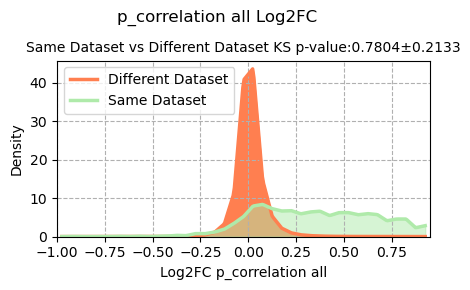

In [ ]:
# pearson correlation all
# Correlation values mean with
value_1 = correlation_values_dataset_all
value_2 = correlation_values_non_dataset_all
logging.info(f"Nº of values: {len(value_1)} {len(value_2)}")

# Compute KS statistics
ks_p_values_mean, ks_p_values_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_1,
    list_matrix_2=value_2,
    resampling_1=False,
    resampling_2=True,
)


# Define plotting variables
values_list = [value_2, value_1]
ks_values_list = [
    [ks_p_values_mean, ks_p_values_std],
]

labels = ["Different Dataset", "Same Dataset"]

plot_metrics(
    values_list=values_list,
    ks_values_list=ks_values_list,
    labels=labels,
    vector_type=metric_evaluated,
    metric_list=["p_correlation", "all"],
    save=True,
)

2024-04-25 12:34:31,351 - INFO - Nº of values: 125 125


p_correlation
[-1.0000000e+00 -9.5000000e-01 -9.0000000e-01 -8.5000000e-01
 -8.0000000e-01 -7.5000000e-01 -7.0000000e-01 -6.5000000e-01
 -6.0000000e-01 -5.5000000e-01 -5.0000000e-01 -4.5000000e-01
 -4.0000000e-01 -3.5000000e-01 -3.0000000e-01 -2.5000000e-01
 -2.0000000e-01 -1.5000000e-01 -1.0000000e-01 -5.0000000e-02
  8.8817842e-16  5.0000000e-02  1.0000000e-01  1.5000000e-01
  2.0000000e-01  2.5000000e-01  3.0000000e-01  3.5000000e-01
  4.0000000e-01  4.5000000e-01  5.0000000e-01  5.5000000e-01
  6.0000000e-01  6.5000000e-01  7.0000000e-01  7.5000000e-01
  8.0000000e-01  8.5000000e-01  9.0000000e-01  9.5000000e-01]


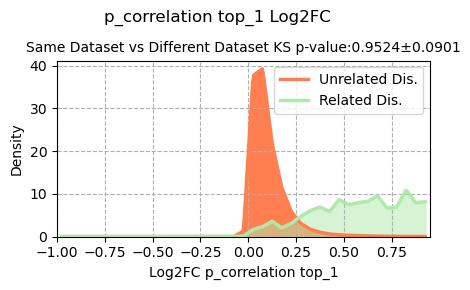

In [ ]:
# pearson correlation top_1
# define values
top_k = 1

value_1 = list()
for matrix in correlation_values_dataset_all:
    _matrix_values = np.empty((matrix.shape[0], top_k))
    # iterate through rows
    for i in range(matrix.shape[0]):
        _matrix_values[i] = get_top_k(matrix[i, :], k=top_k, percent=False)
    value_1.append(_matrix_values)

value_2 = list()
for matrix in correlation_values_non_dataset_all:
    _matrix_values = np.empty((matrix.shape[0], top_k * 100))
    # iterate through rows
    for i in range(matrix.shape[0]):
        # iterate through samples
        for j in range(100):
            sample = np.array_split(matrix[i, :], 100)[j]
            _matrix_values[i, j * top_k : (1 + j) * top_k] = get_top_k(
                sample, k=top_k, percent=False
            )
    value_2.append(_matrix_values)


logging.info(f"Nº of values: {len(value_1)} {len(value_2)}")

# define statistics

ks_p_values_mean, ks_p_values_std = get_ks_statistics_subsamples_all(
    value_1, value_2, resampling_1=False, resampling_2=True
)

# Define plotting variables
values_list = [value_2, value_1]
ks_values_list = [
    [ks_p_values_mean, ks_p_values_std],
]

labels = ["Unrelated Dis.", "Related Dis.", "Same Dis."]

plot_metrics(
    values_list=values_list,
    ks_values_list=ks_values_list,
    labels=labels,
    vector_type=metric_evaluated,
    metric_list=["p_correlation", "top_1"],
    save=True,
)

### Same Dataset 2+ disease

#### a. Get cases

In [ ]:
# how many datasets do we have w/ 5+ signatures
def get_top_datasets(df_matrix):
    """Get top datasets
    Arguments:
        - df_matrix (pd.DataFrame): dataframe
    Returns:
        - top_datasets (list): list of datasets
    """
    top_datasets = list()
    for dataset in df_matrix["accession"].unique():
        QUERY = f"accession == @dataset"
        df_query = df_matrix.query(QUERY)
        if (len(df_query) >= 5) & (len(df_query["disease"].unique()) >= 2):
            top_datasets.append(dataset)
    return top_datasets


# get top datasets
top_datasets = get_top_datasets(df_matrix)

logging.info(f"Nº of datasets w/ 5+ signatures 2+ diseases: {len(top_datasets)}")

2024-04-25 12:34:40,886 - INFO - Nº of datasets w/ 5+ signatures 2+ diseases: 48


#### b. Get similarity metrics

In [ ]:
bootstrap = True
n_diseases = len(top_datasets)

correlation_values_dataset_all = list()
correlation_values_non_dataset_all = list()

cosine_values_dataset_all = list()
cosine_values_non_dataset_all = list()

euclidean_values_dataset_all = list()
euclidean_values_non_dataset_all = list()

# get values
quality_check = random.choice(list(range(len(top_datasets))))
logging.info(f"Quality check: {quality_check} {top_datasets[quality_check]}")

all_indexes = set(range(data_matrix.shape[0]))

for count, dataset in enumerate(tqdm(top_datasets)):  # loop through diseases of dataset
    # dsaids w/ diseases of dataset
    QUERY = f"accession == @dataset"
    dsaids_dataset = df_matrix.query(QUERY)["dsaid"].to_list()

    related_dsaids = list()
    non_dataset_dsaids = list()

    # Extract the specific vectors using the list of indexes
    dataset_idxs = [dsaids_matrix.index(d) for d in dsaids_dataset]

    # dataset indexes pairs
    """We have a list of lists in which we have
    for each disease signature of dataset (row of a matrix) a list in which 
    we will have all the combination of pairs"""

    n_dataset = len(dataset_idxs)

    # compute how many pairs we will have
    n_dataset_unique = int(n_dataset * (n_dataset - 1) / 2)
    n_dataset_all = int(n_dataset * n_dataset)

    dataset_idxs_pairs = np.empty((n_dataset, n_dataset - 1, 2), dtype=int)
    dataset_idxs_pairs_unique = np.empty((n_dataset_unique, 2), dtype=int)

    # generate pairs (all vs all)
    matrix_dataset_idxs_pairs = generate_matrix_idxs(dataset_idxs, bootstrap=False)

    # define matrix to store values
    matrix_correlation_values_dataset = np.empty(
        (n_dataset, n_dataset - 1), dtype=float
    )

    matrix_cosine_values_dataset = np.empty((n_dataset, n_dataset - 1), dtype=float)

    matrix_euclidean_values_dataset = np.empty((n_dataset, n_dataset - 1), dtype=float)

    # itereate through all dataset signatures
    for i, row_dataset in enumerate(matrix_dataset_idxs_pairs):
        # get values
        correlation_values_dataset = matrix_pearson_correlation[
            row_dataset[:, 0], row_dataset[:, 1]
        ]
        cosine_values_dataset = matrix_cosine_distance[
            row_dataset[:, 0], row_dataset[:, 1]
        ]
        euclidean_values_dataset = matrix_euclidean_distance[
            row_dataset[:, 0], row_dataset[:, 1]
        ]

        # store values
        matrix_correlation_values_dataset[i] = correlation_values_dataset
        matrix_cosine_values_dataset[i] = cosine_values_dataset
        matrix_euclidean_values_dataset[i] = euclidean_values_dataset

    # get non dataset indexes
    rest_dsaids = list(set(dsaids_matrix) - set(dsaids_dataset))

    # get idx position related and non_dataset
    non_dataset_idxs = [dsaids_matrix.index(d) for d in rest_dsaids]

    # get nº
    n_non_dataset = len(non_dataset_idxs)

    # generate matrix indexes pairs
    matrix_non_dataset_idxs_pairs = generate_matrix_idxs(
        dataset_idxs, non_dataset_idxs, bootstrap=bootstrap
    )

    # define matrix to store values
    n_columns = (n_dataset) * 100 if bootstrap else n_non_dataset
    matrix_correlation_values_non_dataset = np.empty(
        (n_dataset, n_columns), dtype=float
    )
    matrix_cosine_values_non_dataset = np.empty((n_dataset, n_columns), dtype=float)
    matrix_euclidean_values_non_dataset = np.empty((n_dataset, n_columns), dtype=float)

    # iterate through all dataset signature pairs to find top closest
    for idx, row_non_dataset in enumerate(matrix_non_dataset_idxs_pairs):

        # get correlation values
        correlation_values_non_dataset = matrix_pearson_correlation[
            row_non_dataset[:, 0], row_non_dataset[:, 1]
        ]
        cosine_values_non_dataset = matrix_cosine_distance[
            row_non_dataset[:, 0], row_non_dataset[:, 1]
        ]
        euclidean_values_non_dataset = matrix_euclidean_distance[
            row_non_dataset[:, 0], row_non_dataset[:, 1]
        ]

        # get matrix to store values
        matrix_correlation_values_non_dataset[idx] = correlation_values_non_dataset
        matrix_cosine_values_non_dataset[idx] = cosine_values_non_dataset
        matrix_euclidean_values_non_dataset[idx] = euclidean_values_non_dataset

    # store all computed values
    correlation_values_dataset_all.append(matrix_correlation_values_dataset)
    correlation_values_non_dataset_all.append(matrix_correlation_values_non_dataset)

    cosine_values_dataset_all.append(matrix_cosine_values_dataset)
    cosine_values_non_dataset_all.append(matrix_cosine_values_non_dataset)

    euclidean_values_dataset_all.append(matrix_euclidean_values_dataset)
    euclidean_values_non_dataset_all.append(matrix_euclidean_values_non_dataset)

assert (
    len(top_datasets)
    == len(correlation_values_dataset_all)
    == len(correlation_values_non_dataset_all)
), "Err something wrong with the length of the lists"

2024-04-25 12:34:40,925 - INFO - Quality check: 17 GSE154377
100%|██████████| 48/48 [00:24<00:00,  1.93it/s]


#### c. Plot similarity metrics

In [ ]:
# functions
# imports
from scipy.stats import ks_2samp


# functions
def create_composite_histogram(distributions, bin_edges):
    """
    Create a composite histogram from multiple distributions.

    Parameters:
    - distributions: List of arrays, each representing a distribution of points.
    - bin_edges: Array of bin edges to use for all histograms.

    Returns:
    - composite_histogram: The composite histogram (sum of normalized histograms).
    """
    # Initialize an array to hold the sum of all normalized histograms
    counts_composite_histogram = np.zeros_like(bin_edges[:-1], dtype=float)

    # Iterate over each distribution
    for dist in distributions:
        # dist_values = dist.flatten()
        dist_values = [x for sublist in dist for x in sublist]
        # Calculate the histogram for this distribution
        counts, _ = np.histogram(dist_values, bins=bin_edges)

        # Normalize the histogram by the number of points in the distribution
        normalized_counts = counts / len(dist_values)

        # Add the normalized histogram to the composite histogram
        counts_composite_histogram += normalized_counts

    return counts_composite_histogram


def plot_metrics(
    values_list,
    ks_values_list,
    labels,
    vector_type,
    metric_list,
    cap_value=None,
    save=True,
    sparsity="HS",
):

    # define variables

    colors = {0: "#FF7F50", 1: "#AFEAAA", 2: "#1E90FF"}
    metric, filtering = metric_list
    title_txt = f"{metric} {filtering} {vector_type} "
    e_max = 10
    e_step = 0.5
    if cap_value is not None:
        title_txt = f"{metric} {filtering} {vector_type} (capped)"
        e_max = cap_value
        e_step = cap_value / 100
    fixed_bins_dict = {
        "p_correlation": np.arange(-1, 1, 0.05),
        "cosine": np.arange(0, 2, 0.05),
        "euclidean": np.arange(0, e_max, e_step),
    }

    fixed_bins = fixed_bins_dict.get(metric)
    print(metric)
    print(fixed_bins)
    plt.figure(figsize=(4.5, 3))

    # loop through values
    for i in range(len(values_list)):
        # define values
        values = values_list[i]
        label = labels[i]
        color = colors[i]

        alpha = 0.5
        if i == 0:
            alpha = 1

        # compute normalized density counts for each distribution
        counts = create_composite_histogram(values, fixed_bins)

        bin_centers = 0.5 * (fixed_bins[1:] + fixed_bins[:-1])

        # Spline Interpolation for connecting midpoints
        spline = make_interp_spline(bin_centers, counts, k=1)  # k=3 for cubic spline
        fine_bin_centers = np.linspace(bin_centers.min(), bin_centers.max(), 300)
        fine_counts = spline(fine_bin_centers)

        # Plot interpolated line
        plt.plot(
            fine_bin_centers,
            fine_counts,
            color=color,
            label=label,
            linewidth=2.5,
        )
        plt.fill_between(fine_bin_centers, fine_counts, alpha=alpha, color=color)

    title_txt = title_txt[:35] + "..." if len(title_txt) > 40 else title_txt
    plt.title(
        "Same Dataset vs Different Dataset KS p-value:%.4f±%.4f"
        % (
            ks_values_list[0][0],
            ks_values_list[0][1],
        ),
        fontsize=10,
    )
    plt.suptitle(title_txt, y=0.95)
    plt.legend()
    plt.xlabel(f"{vector_type} {metric} {filtering}")
    plt.xlim(np.min(fixed_bins), np.max(fixed_bins))
    plt.ylim(
        0,
    )
    plt.ylabel("Density")
    plt.grid(linestyle="--")
    plt.tight_layout()

    if save:
        plt.savefig(
            os.path.join(
                "..",
                "results",
                "figures",
                "DiSignAtlas",
                f"{metric}{filtering}.dataset_vs_rest.mesh.{sparsity}.{vector_type}.png",
            ),
            dpi=300,
            bbox_inches="tight",
        )


def flatten(list_of_lists):
    """Flatten a list of lists into a single list."""
    return [item for sublist in list_of_lists for item in sublist]


def get_ks_statistics_subsamples_all(
    list_matrix_1, list_matrix_2, resampling_1=False, resampling_2=True
):
    """Get KS Statistics All
    Arguments:
        - list_matrix_1 (list): list of matrices
        - list_matrix_2 (list): list of matrices
    Returns:
        - ks_p_values_mean (float): mean p-values
        - ks_p_values_std (float): std p-values
    """
    ks_p_values_means = list()
    # we want to evaluate diseases which are contained in the dataset!

    for i in range(len(list_matrix_1)):
        # mean of statistics within a diseases
        if resampling_1 & resampling_2:
            ks_p_values_mean_disease = np.mean(
                [
                    ks_2samp(s_p_1, s_p_2.flatten())[0]
                    for (s_p_1, s_p_2) in zip(list_matrix_1[i], list_matrix_2[i])
                ]
            )
        elif resampling_2 & (not resampling_1):
            p_1 = list_matrix_1[i].flatten()
            ks_p_values_mean_disease = np.mean(
                [ks_2samp(p_1, s_p_2.flatten())[0] for s_p_2 in list_matrix_2[i]]
            )
        elif (not resampling_1) & (not resampling_2):
            p_1 = list_matrix_1[i].flatten()
            p_2 = list_matrix_2[i].flatten()
            ks_p_values_mean_disease = ks_2samp(p_1, p_2)[0]

        ks_p_values_means.append(ks_p_values_mean_disease)

    ks_p_values_mean_of_means = np.mean(ks_p_values_means)
    ks_p_values_std_of_means = np.std(ks_p_values_means)

    return ks_p_values_mean_of_means, ks_p_values_std_of_means


def get_top_k(array, k, percent=False, reverse=False):
    """Get top k values
    Arguments:
        - array (numpy): array of values
        - k_percent (float): percentage of top k values
    Returns:
        - top_k_values (numpy): array of top k values
    """
    if percent:
        k = round(k * array.shape[0])
    if reverse:
        indices = np.argsort(array)[:k]
        bottom_k_values_from_indices = array[indices]
        return bottom_k_values_from_indices
    else:
        indices = np.argsort(array)[-k:]
        top_k_values_from_indices = array[indices]
        return top_k_values_from_indices

2024-04-25 12:35:05,891 - INFO - Nº of values: 48 48


p_correlation
[-1.0000000e+00 -9.5000000e-01 -9.0000000e-01 -8.5000000e-01
 -8.0000000e-01 -7.5000000e-01 -7.0000000e-01 -6.5000000e-01
 -6.0000000e-01 -5.5000000e-01 -5.0000000e-01 -4.5000000e-01
 -4.0000000e-01 -3.5000000e-01 -3.0000000e-01 -2.5000000e-01
 -2.0000000e-01 -1.5000000e-01 -1.0000000e-01 -5.0000000e-02
  8.8817842e-16  5.0000000e-02  1.0000000e-01  1.5000000e-01
  2.0000000e-01  2.5000000e-01  3.0000000e-01  3.5000000e-01
  4.0000000e-01  4.5000000e-01  5.0000000e-01  5.5000000e-01
  6.0000000e-01  6.5000000e-01  7.0000000e-01  7.5000000e-01
  8.0000000e-01  8.5000000e-01  9.0000000e-01  9.5000000e-01]


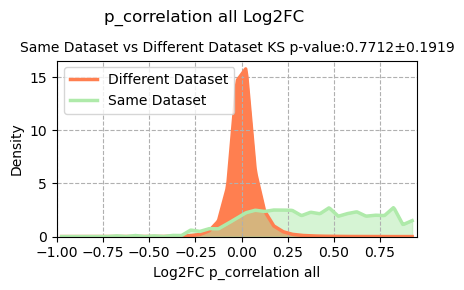

In [ ]:
# pearson correlation all
# Correlation values mean with
value_1 = correlation_values_dataset_all
value_2 = correlation_values_non_dataset_all
logging.info(f"Nº of values: {len(value_1)} {len(value_2)}")

# Compute KS statistics
ks_p_values_mean, ks_p_values_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_1,
    list_matrix_2=value_2,
    resampling_1=False,
    resampling_2=True,
)


# Define plotting variables
values_list = [value_2, value_1]
ks_values_list = [
    [ks_p_values_mean, ks_p_values_std],
]

labels = ["Different Dataset", "Same Dataset"]

plot_metrics(
    values_list=values_list,
    ks_values_list=ks_values_list,
    labels=labels,
    vector_type=metric_evaluated,
    metric_list=["p_correlation", "all"],
    save=True,
)

# REST

In [ ]:
related_dsaids = []
for dsaid in dsaids_filtered_mesh:
    if dsaid in dsaids_2_mesh_tree_terms.keys():
        related_dsaids.extend(dsaids_2_mesh_tree_terms[dsaid])
unrrelated_dsaids = []

In [ ]:
# def check_related_dsaids(, related_dsaids):

all_related_dsaids = list()
all_unrelated_dsaids = list()
# check that all same diseases are related through mesh terms
for count, disease in enumerate(
    tqdm(most_common_diseases)
):  # loop through diseases of interest
    # dsaids w/ diseases of interest
    related_dsaids = list()
    unrrelated_dsaids = list()
    dsaids_interest = disease_2_dsaid_filtered.get(disease)
    for dsaid in dsaids_interest:
        _dsaids_interest = dsaids_interest.copy()
        _dsaids_interest.remove(dsaid)
        _dsaids_interest_mesh_terms = list(
            {
                mesh_term
                for d in _dsaids_interest
                for mesh_term in dsaids_2_mesh_tree_terms.get(d, [])
            }
        )
        _dsaids_interest_mesh_terms = [d for d in _dsaids_interest_mesh_terms]

        dsaid_mesh_terms = dsaids_2_mesh_tree_terms.get(dsaid, [])
        dsaid_mesh_terms = [d for d in dsaid_mesh_terms]
        # check if they are related
        switch = False
        for dsaid_mesh_term in dsaid_mesh_terms:
            if dsaid_mesh_term in _dsaids_interest_mesh_terms:
                switch = True
                break
        if switch:
            related_dsaids.append(dsaid)
        else:
            unrrelated_dsaids.append(dsaid)

    all_related_dsaids.append(related_dsaids)
    all_unrelated_dsaids.append(unrrelated_dsaids)

100%|██████████| 209/209 [00:00<00:00, 1754.70it/s]


In [ ]:
[a for a, b in zip(most_common_diseases, all_unrelated_dsaids) if len(b) > 0]

[]

In [ ]:
dsaids = disease_2_dsaid_filtered.get("Depression")
for dsaid in dsaids:
    print(dsaid, dsaids_2_mesh_tree_terms.get(dsaid, []))

DSA00787 ['F03.600.300']
DSA03519 ['F03.600.300']
DSA03522 ['F03.600.300']
DSA04490 ['F03.600.300']
DSA06870 ['F03.600.300']


In [ ]:
def check_common_mesh_terms(list_1, list_2, level=1):
    """Check Common Mesh Terms
    Arguments:
        - list_1 (list): list of mesh terms
        - list_2 (list): list of mesh terms
    Returns:
        - (bool): True if common mesh terms
    """
    list_1 = [".".join(l.split(".")[:level]) for l in list_1]
    list_2 = [".".join(l.split(".")[:level]) for l in list_2]
    if len(set(list_1).intersection(set(list_2))) > 0:
        return True
    else:
        return False


all_related_dsaids = list()
all_unrelated_dsaids = list()
# check that all same diseases are related through mesh terms
for count, disease in enumerate(
    tqdm(most_common_diseases)
):  # loop through diseases of interest
    # dsaids w/ diseases of interest
    related_dsaids = list()
    unrrelated_dsaids = list()
    dsaids_interest = disease_2_dsaid_filtered.get(disease)
    _dsaids_interest_mesh_terms = list(
        {
            mesh_term
            for d in dsaids_interest
            for mesh_term in dsaids_2_mesh_tree_terms.get(d, [])
        }
    )
    # get ids of interest
    _dsaids_interest_mesh_terms = [d for d in _dsaids_interest_mesh_terms]

    # get ids of rest
    _rest_dsaids = list(set(dsaids_filtered_mesh) - set(dsaids_interest))

    # classify rest of ids into related or unrelated
    for dsaid in _rest_dsaids:
        dsaid_mesh_terms = dsaids_2_mesh_tree_terms.get(dsaid, [])
        dsaid_mesh_terms = [d for d in dsaid_mesh_terms]
        # check if they are related
        if check_common_mesh_terms(
            list_1=_dsaids_interest_mesh_terms, list_2=dsaid_mesh_terms
        ):
            related_dsaids.append(dsaid)
        else:
            unrrelated_dsaids.append(dsaid)

    all_related_dsaids.append(related_dsaids)
    all_unrelated_dsaids.append(unrrelated_dsaids)

100%|██████████| 209/209 [00:10<00:00, 19.77it/s]


In [ ]:
bootstrap = True
n_diseases = len(most_common_diseases)

correlation_values_interest_all = list()
correlation_values_related_all = list()
correlation_values_unrelated_all = list()

cosine_values_interest_all = list()
cosine_values_related_all = list()
cosine_values_unrelated_all = list()

euclidean_values_interest_all = list()
euclidean_values_related_all = list()
euclidean_values_unrelated_all = list()

# get values
quality_check = random.choice(list(range(len(most_common_diseases))))
logging.info(f"Quality check: {quality_check} {most_common_diseases[quality_check]}")

all_indexes = set(range(data_matrix.shape[0]))

for count, disease in enumerate(
    tqdm(most_common_diseases)
):  # loop through diseases of interest
    # dsaids w/ diseases of interest
    dsaids_interest = disease_2_dsaid_filtered.get(disease)

    related_dsaids = list()
    unrelated_dsaids = list()

    # get mesh terms
    _dsaids_interest_mesh_terms = list(
        {
            mesh_term
            for d in dsaids_interest
            for mesh_term in dsaids_2_mesh_tree_terms.get(d, [])
        }
    )

    # Extract the specific vectors using the list of indexes
    interest_idxs = [dsaids_matrix.index(d) for d in dsaids_interest]

    # interest indexes pairs
    """We have a list of lists in which we have
    for each disease signature of interest (row of a matrix) a list in which 
    we will have all the combination of pairs"""

    n_interest = len(interest_idxs)

    # compute how many pairs we will have
    n_interest_unique = int(n_interest * (n_interest - 1) / 2)
    n_interest_all = int(n_interest * n_interest)

    interest_idxs_pairs = np.empty((n_interest, n_interest - 1, 2), dtype=int)
    interest_idxs_pairs_unique = np.empty((n_interest_unique, 2), dtype=int)

    # generate pairs (all vs all)
    matrix_interest_idxs_pairs = generate_matrix_idxs(interest_idxs, bootstrap=False)

    # define matrix to store values
    matrix_correlation_values_interest = np.empty(
        (n_interest, n_interest - 1), dtype=float
    )

    matrix_cosine_values_interest = np.empty((n_interest, n_interest - 1), dtype=float)

    matrix_euclidean_values_interest = np.empty(
        (n_interest, n_interest - 1), dtype=float
    )

    # itereate through all interest signatures
    for i, row_interest in enumerate(matrix_interest_idxs_pairs):
        # get values
        correlation_values_interest = matrix_pearson_correlation[
            row_interest[:, 0], row_interest[:, 1]
        ]
        cosine_values_interest = matrix_cosine_distance[
            row_interest[:, 0], row_interest[:, 1]
        ]
        euclidean_values_interest = matrix_euclidean_distance[
            row_interest[:, 0], row_interest[:, 1]
        ]

        # store values
        matrix_correlation_values_interest[i] = correlation_values_interest
        matrix_cosine_values_interest[i] = cosine_values_interest
        matrix_euclidean_values_interest[i] = euclidean_values_interest

    # quality check
    if count == quality_check:

        # check pearson correlation
        old_value_correlation = check_old_method_correlation(
            dsaids_interest, data_matrix
        )
        assert "%.7f" % old_value_correlation == "%.7f" % np.mean(
            matrix_correlation_values_interest
        ), "Err something wrong computing correlation"

        # check cosine distance
        old_value_cosine = check_old_method_cosine(dsaids_interest, data_matrix)
        assert "%.7f" % old_value_cosine == "%.7f" % np.mean(
            matrix_cosine_values_interest
        ), "Err something wrong computing cosine"
        # check euclidean distance
        old_value_euclidean = check_old_method_euclidean(dsaids_interest, data_matrix)
        assert "%.7f" % old_value_euclidean == "%.7f" % np.mean(
            matrix_euclidean_values_interest
        ), "Err something wrong computing euclidean"

    # get rest indexes
    # get ids of rest
    _rest_dsaids = list(set(dsaids_matrix) - set(dsaids_interest))

    # classify rest of ids into related or unrelated
    for dsaid in _rest_dsaids:
        dsaid_mesh_terms = dsaids_2_mesh_tree_terms.get(dsaid, [])
        dsaid_mesh_terms = [d for d in dsaid_mesh_terms]
        # check if they are related
        if check_common_mesh_terms(
            list_1=_dsaids_interest_mesh_terms, list_2=dsaid_mesh_terms
        ):
            related_dsaids.append(dsaid)

        else:
            unrelated_dsaids.append(dsaid)

    # get idx position related and unrelated
    related_idxs = [dsaids_matrix.index(d) for d in related_dsaids]
    unrelated_idxs = [dsaids_matrix.index(d) for d in unrelated_dsaids]

    # get nº
    n_related = len(related_idxs)
    n_unrelated = len(unrelated_idxs)

    # generate matrix indexes pairs
    matrix_related_idxs_pairs = generate_matrix_idxs(
        interest_idxs, related_idxs, bootstrap=bootstrap
    )
    matrix_unrelated_idxs_pairs = generate_matrix_idxs(
        interest_idxs, unrelated_idxs, bootstrap=bootstrap
    )

    # define matrix to store values
    n_columns = (n_interest) * 100 if bootstrap else n_related
    matrix_correlation_values_related = np.empty((n_interest, n_columns), dtype=float)
    matrix_cosine_values_related = np.empty((n_interest, n_columns), dtype=float)
    matrix_euclidean_values_related = np.empty((n_interest, n_columns), dtype=float)

    # iterate through all interest signature pairs
    for idx, row_related in enumerate(matrix_related_idxs_pairs):

        # get values
        correlation_values_related = matrix_pearson_correlation[
            row_related[:, 0], row_related[:, 1]
        ]
        cosine_values_related = matrix_cosine_distance[
            row_related[:, 0], row_related[:, 1]
        ]
        euclidean_values_related = matrix_euclidean_distance[
            row_related[:, 0], row_related[:, 1]
        ]

        # store values
        matrix_correlation_values_related[idx] = correlation_values_related
        matrix_cosine_values_related[idx] = cosine_values_related
        matrix_euclidean_values_related[idx] = euclidean_values_related

    # define matrix to store values
    n_columns = (n_interest) * 100 if bootstrap else n_unrelated
    matrix_correlation_values_unrelated = np.empty((n_interest, n_columns), dtype=float)
    matrix_cosine_values_unrelated = np.empty((n_interest, n_columns), dtype=float)
    matrix_euclidean_values_unrelated = np.empty((n_interest, n_columns), dtype=float)

    # iterate through all interest signature pairs to find top closest
    for idx, row_unrelated in enumerate(matrix_unrelated_idxs_pairs):

        # get correlation values
        correlation_values_unrelated = matrix_pearson_correlation[
            row_unrelated[:, 0], row_unrelated[:, 1]
        ]
        cosine_values_unrelated = matrix_cosine_distance[
            row_unrelated[:, 0], row_unrelated[:, 1]
        ]
        euclidean_values_unrelated = matrix_euclidean_distance[
            row_unrelated[:, 0], row_unrelated[:, 1]
        ]

        # get matrix to store values
        matrix_correlation_values_unrelated[idx] = correlation_values_unrelated
        matrix_cosine_values_unrelated[idx] = cosine_values_unrelated
        matrix_euclidean_values_unrelated[idx] = euclidean_values_unrelated

    # store all computed values
    correlation_values_interest_all.append(matrix_correlation_values_interest)
    correlation_values_related_all.append(matrix_correlation_values_related)
    correlation_values_unrelated_all.append(matrix_correlation_values_unrelated)

    cosine_values_interest_all.append(matrix_cosine_values_interest)
    cosine_values_related_all.append(matrix_cosine_values_related)
    cosine_values_unrelated_all.append(matrix_cosine_values_unrelated)

    euclidean_values_interest_all.append(matrix_euclidean_values_interest)
    euclidean_values_related_all.append(matrix_euclidean_values_related)
    euclidean_values_unrelated_all.append(matrix_euclidean_values_unrelated)

assert (
    len(most_common_diseases)
    == len(correlation_values_interest_all)
    == len(correlation_values_unrelated_all)
), "Err something wrong with the length of the lists"

2024-04-25 12:35:18,416 - INFO - Quality check: 38 Colon Tumor
100%|██████████| 209/209 [03:02<00:00,  1.15it/s]


In [ ]:
dsaids_2_disease = {v: k for k, vs in disease_2_dsaid_filtered.items() for v in vs}

diseases_matrix = [dsaids_2_disease.get(d) for d in dsaids_matrix]

In [ ]:
most_common_diseases[1]

# get disease of interest
dsaids_interest = disease_2_dsaid_filtered.get(most_common_diseases[1])

index = [dsaids_matrix.index(d) for d in dsaids_interest]

# get matrix values
values = matrix_pearson_correlation[index, :]

In [ ]:
[
    a
    for a in np.where(matrix_cosine_distance[370] > 1.8, diseases_matrix, None)
    if a is not None
]

['Sepsis',
 'Acute Myeloid Leukemia',
 'Ulcerative Colitis',
 'Chronic Obstructive Pulmonary Disease']

In [ ]:
diseases_matrix[370]

'Chronic Cutaneous Lupus Erythematosus'

In [ ]:
np.where(matrix_cosine_distance > 1.8)

(array([ 370,  370,  370,  370,  552,  552,  552,  813, 1126, 1354, 1444,
        1534, 1534, 1755, 1755, 1755, 1905, 1906, 2115, 2115, 2115, 2115,
        2116, 2116, 2116, 2116, 2268, 2268, 2268, 2268, 2268, 2268, 2268,
        2268, 2526, 2527, 2527, 2528, 2529, 2529, 2529, 2530, 2530, 2531,
        2531, 3299, 3299, 3299, 3299, 3699, 3699, 3699, 3699, 3699, 3699,
        3699, 3974, 3974, 3974, 3974, 3974, 3974, 3974, 3974, 3974, 3974,
        3974, 3974, 4502, 4502, 4502, 4502, 4502, 4502, 4503, 4503, 4503,
        4503]),
 array([1534, 2268, 2529, 4502, 2115, 2116, 3974, 2268, 2268, 1444, 1354,
         370, 3974, 3299, 3699, 3974, 1906, 1905,  552, 2268, 4502, 4503,
         552, 2268, 4502, 4503,  370,  813, 1126, 2115, 2116, 3299, 3699,
        3974, 3974, 3699, 3974, 3974,  370, 3699, 3974, 3699, 3974, 3699,
        3974, 1755, 2268, 4502, 4503, 1755, 2268, 2527, 2529, 2530, 2531,
        4502,  552, 1534, 1755, 2268, 2526, 2527, 2528, 2529, 2530, 2531,
        4502, 4503,  3

In [ ]:
# garbage collection
# do a bit of cleaning here and there !
import gc

# collect garbage
cleaning = gc.collect()

cleaning

44730

<Axes: >

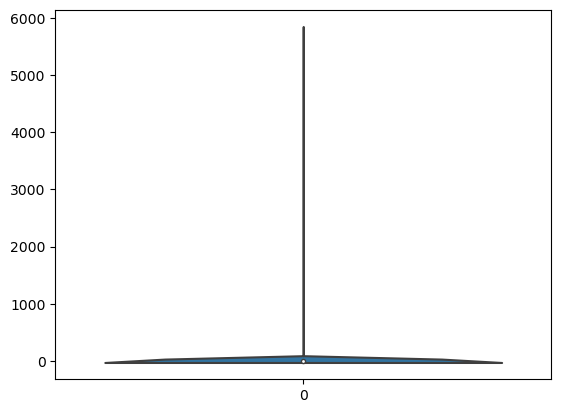

In [ ]:
sns.violinplot(np.std(data_matrix, axis=0))

### Plots

In [ ]:
# imports
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
from matplotlib.colors import LinearSegmentedColormap, to_rgba_array
from scipy.interpolate import make_interp_spline
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
from matplotlib.colors import LinearSegmentedColormap, to_rgba_array
from scipy.interpolate import make_interp_spline


# functions
def get_top_k(array, k, percent=False, reverse=False):
    """Get top k values
    Arguments:
        - array (numpy): array of values
        - k_percent (float): percentage of top k values
    Returns:
        - top_k_values (numpy): array of top k values
    """
    if percent:
        k = round(k * array.shape[0])
    if reverse:
        # Using numpy.argsort to get indices of the k top highest values
        indices = np.argsort(array)[:k]

        # # Sorting indices if you want them in the order of the corresponding values
        # sorted_indices = indices[np.argsort(array[indices])][::-1]

        # Getting the top k values using the sorted indices
        # top_k_values_from_indices = array[sorted_indices]
        bottom_k_values_from_indices = array[indices]
        return bottom_k_values_from_indices
    else:
        # Using numpy.argsort to get indices of the k top highest values
        indices = np.argsort(array)[-k:]

        # # Sorting indices if you want them in the order of the corresponding values
        # sorted_indices = indices[np.argsort(array[indices])][::-1]

        # Getting the top k values using the sorted indices
        # top_k_values_from_indices = array[sorted_indices]
        top_k_values_from_indices = array[indices]
        return top_k_values_from_indices

In [ ]:
def create_composite_histogram(distributions, bin_edges):
    """
    Create a composite histogram from multiple distributions.

    Parameters:
    - distributions: List of arrays, each representing a distribution of points.
    - bin_edges: Array of bin edges to use for all histograms.

    Returns:
    - composite_histogram: The composite histogram (sum of normalized histograms).
    """
    # Initialize an array to hold the sum of all normalized histograms
    counts_composite_histogram = np.zeros_like(bin_edges[:-1], dtype=float)

    # Iterate over each distribution
    for dist in distributions:
        dist_values = dist.flatten()
        # Calculate the histogram for this distribution
        counts, _ = np.histogram(dist_values, bins=bin_edges)

        # Normalize the histogram by the number of points in the distribution
        normalized_counts = counts / len(dist_values)

        # Add the normalized histogram to the composite histogram
        counts_composite_histogram += normalized_counts

    return counts_composite_histogram

In [ ]:
def get_ks_statistics_all(list_matrix_1, list_matrix_2):
    """Get KS Statistics All
    Arguments:
        - list_matrix_1 (list): list of matrices
        - list_matrix_2 (list): list of matrices
    Returns:
        - ks_p_values_mean (float): mean p-values
        - ks_p_values_std (float): std p-values
    """
    ks_p_values_mean = np.mean(
        [
            ks_2samp(p_1.flatten(), p_2.flatten())[1]
            for p_1, p_2 in zip(list_matrix_1, list_matrix_2)
        ]
    )
    ks_p_values_std = np.std(
        [
            ks_2samp(p_1.flatten(), p_2.flatten())[1]
            for p_1, p_2 in zip(list_matrix_1, list_matrix_2)
        ]
    )

    return ks_p_values_mean, ks_p_values_std


def plot_metrics(
    values_list,
    ks_values_list,
    labels,
    vector_type,
    metric_list,
    cap_value=None,
    save=True,
    sparsity="HS",
):

    # define variables

    colors = {0: "#FF7F50", 1: "#AFEAAA", 2: "#1E90FF"}
    metric, filtering = metric_list
    title_txt = f"{metric} {filtering} {vector_type} "
    e_max = 10
    e_step = 0.5
    if cap_value is not None:
        title_txt = f"{metric} {filtering} {vector_type} (capped)"
        e_max = cap_value
        e_step = cap_value / 100
    fixed_bins_dict = {
        "p_correlation": np.arange(-1, 1, 0.05),
        "cosine": np.arange(0, 2, 0.05),
        "euclidean": np.arange(0, e_max, e_step),
    }

    fixed_bins = fixed_bins_dict.get(metric)
    print(metric)
    print(fixed_bins)
    plt.figure(figsize=(4.5, 3))

    # loop through values
    for i in range(len(values_list)):
        # define values
        values = values_list[i]
        label = labels[i]
        color = colors[i]

        alpha = 0.5
        if i == 0:
            alpha = 1

        # compute normalized density counts for each distribution
        counts = create_composite_histogram(values, fixed_bins)

        bin_centers = 0.5 * (fixed_bins[1:] + fixed_bins[:-1])

        # Spline Interpolation for connecting midpoints
        spline = make_interp_spline(bin_centers, counts, k=1)  # k=3 for cubic spline
        fine_bin_centers = np.linspace(bin_centers.min(), bin_centers.max(), 300)
        fine_counts = spline(fine_bin_centers)

        # Plot interpolated line
        plt.plot(
            fine_bin_centers,
            fine_counts,
            color=color,
            label=label,
            linewidth=2.5,
        )
        plt.fill_between(fine_bin_centers, fine_counts, alpha=alpha, color=color)

    title_txt = title_txt[:35] + "..." if len(title_txt) > 40 else title_txt
    plt.title(
        "Same-Related KS p-value:%.4f±%.4f\nSame-Unrelated KS p-value:%.4f±%.4f\nRelated-Unrelated KS p-value:%.4f±%.4f"
        % (
            ks_values_list[0][0],
            ks_values_list[0][1],
            ks_values_list[1][0],
            ks_values_list[1][1],
            ks_values_list[2][0],
            ks_values_list[2][1],
        ),
        fontsize=10,
    )
    plt.suptitle(title_txt, y=0.95)
    plt.legend()
    plt.xlabel(f"{vector_type} {metric} {filtering}")
    plt.xlim(np.min(fixed_bins), np.max(fixed_bins))
    plt.ylim(
        0,
    )
    plt.ylabel("Density")
    plt.grid(linestyle="--")
    plt.tight_layout()

    if save:
        plt.savefig(
            os.path.join(
                "..",
                "results",
                "figures",
                "DiSignAtlas",
                f"{metric}{filtering}.mesh.{sparsity}.{vector_type}.png",
            ),
            dpi=300,
            bbox_inches="tight",
        )

#### Pearson Correlations

2024-04-25 12:38:43,163 - INFO - Nº of values: 209 209


p_correlation
[-1.0000000e+00 -9.5000000e-01 -9.0000000e-01 -8.5000000e-01
 -8.0000000e-01 -7.5000000e-01 -7.0000000e-01 -6.5000000e-01
 -6.0000000e-01 -5.5000000e-01 -5.0000000e-01 -4.5000000e-01
 -4.0000000e-01 -3.5000000e-01 -3.0000000e-01 -2.5000000e-01
 -2.0000000e-01 -1.5000000e-01 -1.0000000e-01 -5.0000000e-02
  8.8817842e-16  5.0000000e-02  1.0000000e-01  1.5000000e-01
  2.0000000e-01  2.5000000e-01  3.0000000e-01  3.5000000e-01
  4.0000000e-01  4.5000000e-01  5.0000000e-01  5.5000000e-01
  6.0000000e-01  6.5000000e-01  7.0000000e-01  7.5000000e-01
  8.0000000e-01  8.5000000e-01  9.0000000e-01  9.5000000e-01]


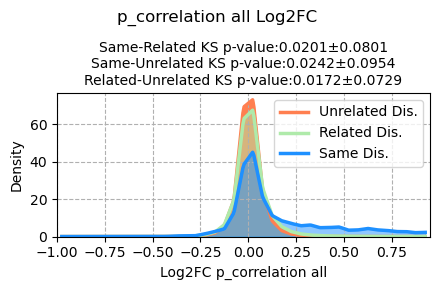

In [ ]:
# pearson correlation all
# Correlation values mean with
value_1 = correlation_values_interest_all
value_2 = correlation_values_related_all
value_3 = correlation_values_unrelated_all
logging.info(f"Nº of values: {len(value_1)} {len(value_2)}")

# Compute KS statistics
ks_p_values_i_u_mean, ks_p_values_i_u_std = get_ks_statistics_all(
    list_matrix_1=correlation_values_interest_all,
    list_matrix_2=correlation_values_unrelated_all,
)

ks_p_values_i_r_mean, ks_p_values_i_r_std = get_ks_statistics_all(
    list_matrix_1=correlation_values_interest_all,
    list_matrix_2=correlation_values_related_all,
)

ks_p_values_r_u_mean, ks_p_values_r_u_std = get_ks_statistics_all(
    list_matrix_1=correlation_values_related_all,
    list_matrix_2=correlation_values_unrelated_all,
)


# Define plotting variables
values_list = [value_3, value_2, value_1]
ks_values_list = [
    [ks_p_values_i_u_mean, ks_p_values_i_u_std],
    [ks_p_values_i_r_mean, ks_p_values_i_r_std],
    [ks_p_values_r_u_mean, ks_p_values_r_u_std],
]

labels = ["Unrelated Dis.", "Related Dis.", "Same Dis."]
fixed_bins = np.arange(-1.001, 1.001, 0.05)

plot_metrics(
    values_list=values_list,
    ks_values_list=ks_values_list,
    labels=labels,
    vector_type=metric_evaluated,
    metric_list=["p_correlation", "all"],
    save=True,
)

2024-04-25 12:45:22,247 - INFO - Nº of values: 209 209


p_correlation
[-1.0000000e+00 -9.5000000e-01 -9.0000000e-01 -8.5000000e-01
 -8.0000000e-01 -7.5000000e-01 -7.0000000e-01 -6.5000000e-01
 -6.0000000e-01 -5.5000000e-01 -5.0000000e-01 -4.5000000e-01
 -4.0000000e-01 -3.5000000e-01 -3.0000000e-01 -2.5000000e-01
 -2.0000000e-01 -1.5000000e-01 -1.0000000e-01 -5.0000000e-02
  8.8817842e-16  5.0000000e-02  1.0000000e-01  1.5000000e-01
  2.0000000e-01  2.5000000e-01  3.0000000e-01  3.5000000e-01
  4.0000000e-01  4.5000000e-01  5.0000000e-01  5.5000000e-01
  6.0000000e-01  6.5000000e-01  7.0000000e-01  7.5000000e-01
  8.0000000e-01  8.5000000e-01  9.0000000e-01  9.5000000e-01]


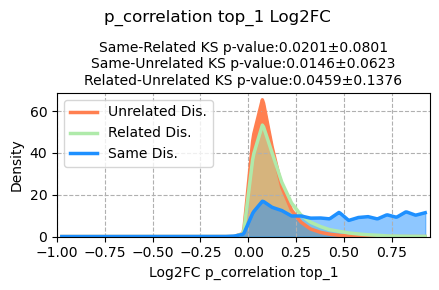

In [ ]:
# pearson correlation top_1
# define values
top_k = 1

value_1 = list()
for matrix in correlation_values_interest_all:
    _matrix_values = np.empty((matrix.shape[0], top_k))
    # iterate through rows
    for i in range(matrix.shape[0]):
        _matrix_values[i] = get_top_k(matrix[i, :], k=top_k, percent=False)
    value_1.append(_matrix_values)

value_2 = list()
for matrix in correlation_values_related_all:
    _matrix_values = np.empty((matrix.shape[0], top_k * 100))
    # iterate through rows
    for i in range(matrix.shape[0]):
        # iterate through samples
        for j in range(100):
            sample = np.array_split(matrix[i, :], 100)[j]
            _matrix_values[i, j * top_k : (1 + j) * top_k] = get_top_k(
                sample, k=top_k, percent=False
            )
    value_2.append(_matrix_values)

value_3 = list()
for matrix in correlation_values_unrelated_all:
    _matrix_values = np.empty((matrix.shape[0], top_k * 100))
    # iterate through rows
    for i in range(matrix.shape[0]):
        # iterate through samples
        for j in range(100):
            sample = np.array_split(matrix[i, :], 100)[j]
            _matrix_values[i, j * top_k : (1 + j) * top_k] = get_top_k(
                sample, k=top_k, percent=False
            )
    value_3.append(_matrix_values)

logging.info(f"Nº of values: {len(value_1)} {len(value_2)}")

# define statistics

ks_p_values_u_r_mean, ks_p_values_u_r_std = get_ks_statistics_all(value_1, value_3)
ks_p_values_i_r_mean, ks_p_values_i_r_std = get_ks_statistics_all(value_1, value_3)
ks_p_values_r_u_mean, ks_p_values_r_u_std = get_ks_statistics_all(value_2, value_3)

# Define plotting variables
values_list = [value_3, value_2, value_1]
ks_values_list = [
    [ks_p_values_i_u_mean, ks_p_values_i_u_std],
    [ks_p_values_i_r_mean, ks_p_values_i_r_std],
    [ks_p_values_r_u_mean, ks_p_values_r_u_std],
]

labels = ["Unrelated Dis.", "Related Dis.", "Same Dis."]

plot_metrics(
    values_list=values_list,
    ks_values_list=ks_values_list,
    labels=labels,
    vector_type=metric_evaluated,
    metric_list=["p_correlation", "top_1"],
    save=True,
)

2024-04-25 12:51:04,443 - INFO - Nº of values: 209 209


p_correlation
[-1.0000000e+00 -9.5000000e-01 -9.0000000e-01 -8.5000000e-01
 -8.0000000e-01 -7.5000000e-01 -7.0000000e-01 -6.5000000e-01
 -6.0000000e-01 -5.5000000e-01 -5.0000000e-01 -4.5000000e-01
 -4.0000000e-01 -3.5000000e-01 -3.0000000e-01 -2.5000000e-01
 -2.0000000e-01 -1.5000000e-01 -1.0000000e-01 -5.0000000e-02
  8.8817842e-16  5.0000000e-02  1.0000000e-01  1.5000000e-01
  2.0000000e-01  2.5000000e-01  3.0000000e-01  3.5000000e-01
  4.0000000e-01  4.5000000e-01  5.0000000e-01  5.5000000e-01
  6.0000000e-01  6.5000000e-01  7.0000000e-01  7.5000000e-01
  8.0000000e-01  8.5000000e-01  9.0000000e-01  9.5000000e-01]


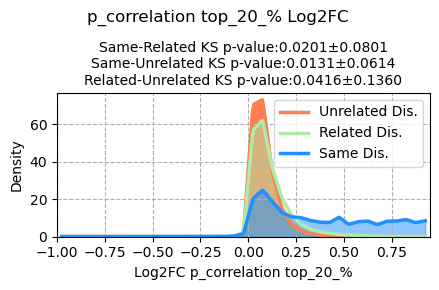

In [ ]:
# pearson correlation top_20_%
# define values
top_k = 0.2

value_1 = list()
for matrix in correlation_values_interest_all:
    n_columns = round(matrix.shape[1] * top_k)
    _matrix_values = np.empty((matrix.shape[0], n_columns))
    # iterate through rows
    for i in range(matrix.shape[0]):
        _matrix_values[i] = get_top_k(matrix[i, :], k=top_k, percent=True)
    value_1.append(_matrix_values)

value_2 = list()
for matrix in correlation_values_related_all:
    n_columns = round(matrix.shape[1] / 100 * top_k)
    _matrix_values = np.empty((matrix.shape[0], n_columns * 100))
    # iterate through rows
    for i in range(matrix.shape[0]):
        # iterate through samples
        for j in range(100):
            sample = np.array_split(matrix[i, :], 100)[j]
            _matrix_values[i, j * n_columns : (1 + j) * n_columns] = get_top_k(
                sample, k=top_k, percent=True
            )
    value_2.append(_matrix_values)

value_3 = list()
for matrix in correlation_values_unrelated_all:
    n_columns = round(matrix.shape[1] / 100 * top_k)
    _matrix_values = np.empty((matrix.shape[0], n_columns * 100))
    # iterate through rows
    for i in range(matrix.shape[0]):
        # iterate through samples
        for j in range(100):
            sample = np.array_split(matrix[i, :], 100)[j]
            _matrix_values[i, j * n_columns : (1 + j) * n_columns] = get_top_k(
                sample, k=top_k, percent=True
            )
    value_3.append(_matrix_values)

logging.info(f"Nº of values: {len(value_1)} {len(value_2)}")

# define statistics

ks_p_values_u_r_mean, ks_p_values_u_r_std = get_ks_statistics_all(value_1, value_3)
ks_p_values_i_r_mean, ks_p_values_i_r_std = get_ks_statistics_all(value_1, value_3)
ks_p_values_r_u_mean, ks_p_values_r_u_std = get_ks_statistics_all(value_2, value_3)

# Define plotting variables
values_list = [value_3, value_2, value_1]
ks_values_list = [
    [ks_p_values_i_u_mean, ks_p_values_i_u_std],
    [ks_p_values_i_r_mean, ks_p_values_i_r_std],
    [ks_p_values_r_u_mean, ks_p_values_r_u_std],
]

labels = ["Unrelated Dis.", "Related Dis.", "Same Dis."]
fixed_bins = np.arange(-1.001, 1.001, 0.05)

plot_metrics(
    values_list=values_list,
    ks_values_list=ks_values_list,
    labels=labels,
    vector_type=metric_evaluated,
    metric_list=["p_correlation", "top_20_%"],
    save=True,
)

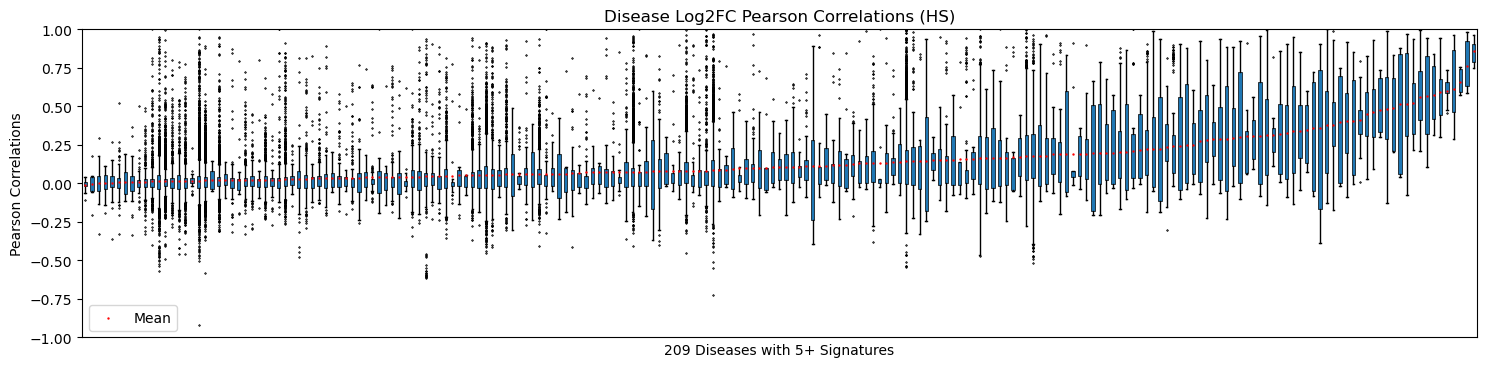

In [ ]:
# Plot Disease Pearson Correlations Boxplots
import matplotlib.pyplot as plt
import numpy as np

# Generate sample data
data = correlation_values_interest_all
# Calculate means and sort data based on these means
means = [np.mean(i) for i in data]
sorted_indices = np.argsort(means)
sorted_data = [data[i].flatten() for i in sorted_indices]
sorted_means = [means[i] for i in sorted_indices]
sorted_diseases = [most_common_diseases[i] for i in sorted_indices]

# Plotting
plt.figure(figsize=(18, 4))  # Adjusted for visibility

flierprops = dict(marker=".", color="black", markersize=0.8)  # Customizing outliers
boxprops = dict(linestyle="solid", linewidth=0.5, color="black")
medianprops = dict(linestyle="-", linewidth=0)
# Boxplot
bp = plt.boxplot(
    sorted_data,
    vert=True,
    patch_artist=True,
    positions=range(1, int(len(sorted_means) / 1) + 1),
    flierprops=flierprops,
    boxprops=boxprops,
    medianprops=medianprops,
    # Apply outlier customization
)  # Adjusted for visibility

# Overlay means
plt.scatter(
    range(1, int(len(sorted_means) / 1) + 1),
    sorted_means,
    color="red",
    zorder=3,
    label="Mean",
    s=0.5,
)  # Adjusted for visibility

# Customization
plt.title(f"Disease {metric_evaluated} Pearson Correlations ({sparsity})")
plt.xlabel(f"{len(means)} Diseases with 5+ Signatures")
plt.ylabel("Pearson Correlations")
plt.xticks([])
plt.legend()
plt.ylim(-1, 1)

plt.savefig(
    os.path.join(
        "..",
        "results",
        "figures",
        "DiSignAtlas",
        f"boxplot.diseases_correlation.{sparsity}.{metric_evaluated}.png",
    ),
    dpi=300,
    bbox_inches="tight",
)

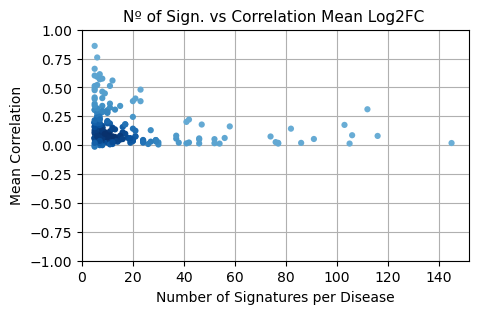

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
from matplotlib.colors import LinearSegmentedColormap, to_rgba_array

values_1 = [np.mean(i) for i in correlation_values_interest_all]

# number of signatures per disease
n_signatures_per_disease = [
    len(disease_2_dsaid_filtered.get(disease)) for disease in most_common_diseases
]

# Calculate the point density
xy = np.vstack([n_signatures_per_disease, values_1])
z = gaussian_kde(xy)(xy)

# Compute R-squared value
slope, intercept = np.polyfit(n_signatures_per_disease, values_1, 1)
r_squared = np.corrcoef(n_signatures_per_disease, values_1)[0, 1] ** 2

# Original Blues colormap
orig_cmap = plt.cm.Blues

# Create a custom colormap from a subset of the original colormap's range
# Adjust start and stop to control the range of colors used
start = 0.5  # Start from a darker shade
stop = 1  # End at the original colormap's maximum value
blues_custom = LinearSegmentedColormap.from_list(
    "Truncated Blues", orig_cmap(np.linspace(start, stop, 256))
)


# Plot
plt.figure(figsize=(5, 3))
scatter = plt.scatter(
    n_signatures_per_disease,
    values_1,
    c=z,
    s=20,
    edgecolor="none",
    cmap=blues_custom,
    zorder=3,
)


# Customization
plt.grid(True, zorder=-1)  # Add gridlines
title_txt = f"Nº of Sign. vs Correlation Mean {metric_evaluated} "
title_txt = title_txt[:35] + "..." if len(title_txt) > 40 else title_txt
plt.title(title_txt, fontsize=11)
# plt.title(f"Scatter Plot Colored by Density with R^2: {r_squared:.2f}")
plt.xlabel("Number of Signatures per Disease")
plt.ylabel("Mean Correlation")

plt.ylim(-1, 1)
plt.xlim(
    0,
)
plt.savefig(
    os.path.join(
        "..",
        "results",
        "figures",
        "DiSignAtlas",
        f"scatter_plot.correlation.mesh.{sparsity}.{metric_evaluated}.png",
    ),
    dpi=300,
    bbox_inches="tight",
)

#### Euclidean Distances

In [ ]:
# define values
step = 25
cap_val = (
    500
    if 500 < np.max(matrix_euclidean_distance)
    else np.max(matrix_euclidean_distance) + 1
)


# Function to cap values at a specific limit
def cap_values_at_limit(values, limit):
    return np.where(values > limit, limit, values)

2024-04-25 12:51:43,754 - INFO - Nº of values: 209 209


euclidean
[  0.   5.  10.  15.  20.  25.  30.  35.  40.  45.  50.  55.  60.  65.
  70.  75.  80.  85.  90.  95. 100. 105. 110. 115. 120. 125. 130. 135.
 140. 145. 150. 155. 160. 165. 170. 175. 180. 185. 190. 195. 200. 205.
 210. 215. 220. 225. 230. 235. 240. 245. 250. 255. 260. 265. 270. 275.
 280. 285. 290. 295. 300. 305. 310. 315. 320. 325. 330. 335. 340. 345.
 350. 355. 360. 365. 370. 375. 380. 385. 390. 395. 400. 405. 410. 415.
 420. 425. 430. 435. 440. 445. 450. 455. 460. 465. 470. 475. 480. 485.
 490. 495.]


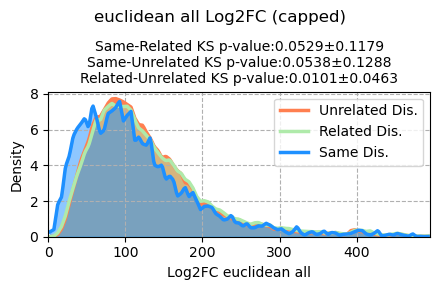

In [ ]:
# euclidean all
value_1 = euclidean_values_interest_all
value_2 = euclidean_values_related_all
value_3 = euclidean_values_unrelated_all
logging.info(f"Nº of values: {len(value_1)} {len(value_2)}")

# Cap the values for each list
capped_value_1 = [cap_values_at_limit(v, cap_val) for v in value_1]
capped_value_2 = [cap_values_at_limit(v, cap_val) for v in value_2]
capped_value_3 = [cap_values_at_limit(v, cap_val) for v in value_3]

# statistics
ks_p_values_i_u_mean, ks_p_values_i_u_std = get_ks_statistics_all(value_1, value_3)
ks_p_values_i_r_mean, ks_p_values_i_r_std = get_ks_statistics_all(value_1, value_2)
ks_p_values_u_r_mean, ks_p_values_u_r_std = get_ks_statistics_all(value_3, value_2)

# Lists to store values for plotting
values_list = [capped_value_3, capped_value_2, capped_value_1]
ks_values_list = [
    [ks_p_values_i_u_mean, ks_p_values_i_u_std],
    [ks_p_values_i_r_mean, ks_p_values_i_r_std],
    [ks_p_values_u_r_mean, ks_p_values_u_r_std],
]
labels = ["Unrelated Dis.", "Related Dis.", "Same Dis."]

plot_metrics(
    values_list=values_list,
    ks_values_list=ks_values_list,
    labels=labels,
    vector_type=metric_evaluated,
    metric_list=["euclidean", "all"],
    cap_value=cap_val,
    save=True,
)

2024-04-25 12:58:27,736 - INFO - Nº of values: 209 209


euclidean
[  0.   5.  10.  15.  20.  25.  30.  35.  40.  45.  50.  55.  60.  65.
  70.  75.  80.  85.  90.  95. 100. 105. 110. 115. 120. 125. 130. 135.
 140. 145. 150. 155. 160. 165. 170. 175. 180. 185. 190. 195. 200. 205.
 210. 215. 220. 225. 230. 235. 240. 245. 250. 255. 260. 265. 270. 275.
 280. 285. 290. 295. 300. 305. 310. 315. 320. 325. 330. 335. 340. 345.
 350. 355. 360. 365. 370. 375. 380. 385. 390. 395. 400. 405. 410. 415.
 420. 425. 430. 435. 440. 445. 450. 455. 460. 465. 470. 475. 480. 485.
 490. 495.]


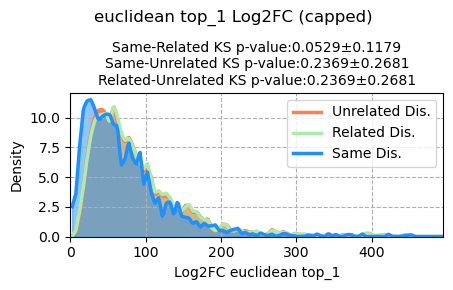

In [ ]:
# pearson euclidean top_1
# define values
top_k = 1

value_1 = list()
for matrix in euclidean_values_interest_all:
    _matrix_values = np.empty((matrix.shape[0], top_k))
    # iterate through rows
    for i in range(matrix.shape[0]):
        _matrix_values[i] = get_top_k(
            matrix[i, :], k=top_k, percent=False, reverse=True
        )
    value_1.append(_matrix_values)

value_2 = list()
for matrix in euclidean_values_related_all:
    _matrix_values = np.empty((matrix.shape[0], top_k * 100))
    # iterate through rows
    for i in range(matrix.shape[0]):
        # iterate through samples
        for j in range(100):
            sample = np.array_split(matrix[i, :], 100)[j]
            _matrix_values[i, j * top_k : (1 + j) * top_k] = get_top_k(
                sample, k=top_k, percent=False, reverse=True
            )
    value_2.append(_matrix_values)

value_3 = list()
for matrix in euclidean_values_unrelated_all:
    _matrix_values = np.empty((matrix.shape[0], top_k * 100))
    # iterate through rows
    for i in range(matrix.shape[0]):
        # iterate through samples
        for j in range(100):
            sample = np.array_split(matrix[i, :], 100)[j]
            _matrix_values[i, j * top_k : (1 + j) * top_k] = get_top_k(
                sample, k=top_k, percent=False, reverse=True
            )
    value_3.append(_matrix_values)

logging.info(f"Nº of values: {len(value_1)} {len(value_2)}")

# Cap the values for each list
capped_value_1 = [cap_values_at_limit(v, cap_val) for v in value_1]
capped_value_2 = [cap_values_at_limit(v, cap_val) for v in value_2]
capped_value_3 = [cap_values_at_limit(v, cap_val) for v in value_3]

# define statistics
ks_p_values_u_r_mean, ks_p_values_u_r_std = get_ks_statistics_all(value_1, value_3)
ks_p_values_i_r_mean, ks_p_values_i_r_std = get_ks_statistics_all(value_1, value_3)
ks_p_values_r_u_mean, ks_p_values_r_u_std = get_ks_statistics_all(value_2, value_3)

# Define plotting variables
values_list = [capped_value_3, capped_value_2, capped_value_1]
ks_values_list = [
    [ks_p_values_i_u_mean, ks_p_values_i_u_std],
    [ks_p_values_i_r_mean, ks_p_values_i_r_std],
    [ks_p_values_r_u_mean, ks_p_values_r_u_std],
]
# Lists to store values for plotting
values_list = [capped_value_3, capped_value_2, capped_value_1]
ks_values_list = [
    [ks_p_values_i_u_mean, ks_p_values_i_u_std],
    [ks_p_values_i_r_mean, ks_p_values_i_r_std],
    [ks_p_values_u_r_mean, ks_p_values_u_r_std],
]
labels = ["Unrelated Dis.", "Related Dis.", "Same Dis."]

plot_metrics(
    values_list=values_list,
    ks_values_list=ks_values_list,
    labels=labels,
    vector_type=metric_evaluated,
    metric_list=["euclidean", "top_1"],
    cap_value=cap_val,
    save=True,
)

In [ ]:
# pearson euclidean top_20_%
# define values
top_k = 0.2

value_1 = list()
for matrix in euclidean_values_interest_all:
    n_columns = round(matrix.shape[1] * top_k)
    _matrix_values = np.empty((matrix.shape[0], n_columns))
    # iterate through rows
    for i in range(matrix.shape[0]):
        _matrix_values[i] = get_top_k(matrix[i, :], k=top_k, percent=True, reverse=True)
    value_1.append(_matrix_values)

value_2 = list()
for matrix in euclidean_values_related_all:
    n_columns = round(matrix.shape[1] / 100 * top_k)
    _matrix_values = np.empty((matrix.shape[0], n_columns * 100))
    # iterate through rows
    for i in range(matrix.shape[0]):
        # iterate through samples
        for j in range(100):
            sample = np.array_split(matrix[i, :], 100)[j]
            _matrix_values[i, j * n_columns : (1 + j) * n_columns] = get_top_k(
                sample, k=top_k, percent=True, reverse=True
            )
    value_2.append(_matrix_values)

value_3 = list()
for matrix in euclidean_values_unrelated_all:
    n_columns = round(matrix.shape[1] / 100 * top_k)
    _matrix_values = np.empty((matrix.shape[0], n_columns * 100))
    # iterate through rows
    for i in range(matrix.shape[0]):
        # iterate through samples
        for j in range(100):
            sample = np.array_split(matrix[i, :], 100)[j]
            _matrix_values[i, j * n_columns : (1 + j) * n_columns] = get_top_k(
                sample, k=top_k, percent=True, reverse=True
            )
    value_3.append(_matrix_values)

logging.info(f"Nº of values: {len(value_1)} {len(value_2)}")

# Cap the values for each list
capped_value_1 = [cap_values_at_limit(v, cap_val) for v in value_1]
capped_value_2 = [cap_values_at_limit(v, cap_val) for v in value_2]
capped_value_3 = [cap_values_at_limit(v, cap_val) for v in value_3]

# define statistics
ks_p_values_u_r_mean, ks_p_values_u_r_std = get_ks_statistics_all(value_1, value_3)
ks_p_values_i_r_mean, ks_p_values_i_r_std = get_ks_statistics_all(value_1, value_3)
ks_p_values_r_u_mean, ks_p_values_r_u_std = get_ks_statistics_all(value_2, value_3)

# Define plotting variables
values_list = [capped_value_3, capped_value_2, capped_value_1]
ks_values_list = [
    [ks_p_values_i_u_mean, ks_p_values_i_u_std],
    [ks_p_values_i_r_mean, ks_p_values_i_r_std],
    [ks_p_values_r_u_mean, ks_p_values_r_u_std],
]
# Lists to store values for plotting
values_list = [capped_value_3, capped_value_2, capped_value_1]
ks_values_list = [
    [ks_p_values_i_u_mean, ks_p_values_i_u_std],
    [ks_p_values_i_r_mean, ks_p_values_i_r_std],
    [ks_p_values_u_r_mean, ks_p_values_u_r_std],
]
labels = ["Unrelated Dis.", "Related Dis.", "Same Dis."]

plot_metrics(
    values_list=values_list,
    ks_values_list=ks_values_list,
    labels=labels,
    vector_type=metric_evaluated,
    metric_list=["euclidean", "top_20_%"],
    cap_value=cap_val,
    save=True,
)


KeyboardInterrupt



In [ ]:
len(values)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
from matplotlib.colors import LinearSegmentedColormap, to_rgba_array

values_1 = list()
n_signatures_per_disease = list()

for i in range(len(euclidean_values_interest_all)):
    value = np.mean(euclidean_values_interest_all[i])
    if value < cap_val:
        values_1.append(value)
        n_signatures_per_disease.append(
            len(disease_2_dsaid_filtered.get(most_common_diseases[i]))
        )


# Calculate the point density
xy = np.vstack([n_signatures_per_disease, values_1])
z = gaussian_kde(xy)(xy)

# Compute R-squared value
slope, intercept = np.polyfit(n_signatures_per_disease, values_1, 1)
r_squared = np.corrcoef(n_signatures_per_disease, values_1)[0, 1] ** 2

# Original Blues colormap
orig_cmap = plt.cm.Blues

# Create a custom colormap from a subset of the original colormap's range
# Adjust start and stop to control the range of colors used
start = 0.5  # Start from a darker shade
stop = 1  # End at the original colormap's maximum value
blues_custom = LinearSegmentedColormap.from_list(
    "Truncated Blues", orig_cmap(np.linspace(start, stop, 256))
)

# Plot
plt.figure(figsize=(5, 3))
scatter = plt.scatter(
    n_signatures_per_disease,
    values_1,
    c=z,
    s=20,
    edgecolor="none",
    cmap=blues_custom,
    zorder=3,
)

# Customization
plt.grid(True, zorder=-1)  # Add gridlines
plt.title(f"Nº of Sign. vs {metric_evaluated} ({sparsity}) Euclidean", fontsize=11)
# plt.title(f"Scatter Plot Colored by Density with R^2: {r_squared:.2f}")
plt.xlabel("Number of Signatures per Disease")
plt.ylabel("Mean Euclidean Values")
plt.xlim(
    0,
)
plt.ylim(
    0,
)
plt.savefig(
    os.path.join(
        "..",
        "results",
        "figures",
        "DiSignAtlas",
        f"scatter_plot.euclidean.mesh.{sparsity}.{metric_evaluated}.png",
    ),
    dpi=300,
    bbox_inches="tight",
)

#### Cosine Distances

In [ ]:
def get_ks_statistics_all(list_matrix_1, list_matrix_2):
    """Get KS Statistics All
    Arguments:
        - list_matrix_1 (list): list of matrices
        - list_matrix_2 (list): list of matrices
    Returns:
        - ks_p_values_mean (float): mean p-values
        - ks_p_values_std (float): std p-values
    """
    ks_p_values_mean = np.mean(
        [
            ks_2samp(p_1.flatten(), p_2.flatten())[1]
            for p_1, p_2 in zip(list_matrix_1, list_matrix_2)
        ]
    )
    ks_p_values_std = np.std(
        [
            ks_2samp(p_1.flatten(), p_2.flatten())[1]
            for p_1, p_2 in zip(list_matrix_1, list_matrix_2)
        ]
    )

    return ks_p_values_mean, ks_p_values_std

In [ ]:
# plot cosine all
# get values
value_1 = cosine_values_interest_all
value_2 = cosine_values_related_all
value_3 = cosine_values_unrelated_all
logging.info(f"Nº of values: {len(value_1)} {len(value_2)}")

# Compute KS statistics
ks_p_values_i_u_mean, ks_p_values_i_u_std = get_ks_statistics_all(value_1, value_3)
ks_p_values_i_r_mean, ks_p_values_i_r_std = get_ks_statistics_all(value_1, value_2)
ks_p_values_r_u_mean, ks_p_values_r_u_std = get_ks_statistics_all(value_2, value_3)

# Define plotting variables
values_list = [value_3, value_2, value_1]
ks_values_list = [
    [ks_p_values_i_u_mean, ks_p_values_i_u_std],
    [ks_p_values_i_r_mean, ks_p_values_i_r_std],
    [ks_p_values_r_u_mean, ks_p_values_r_u_std],
]
labels = ["Unrelated Dis.", "Related Dis.", "Same Dis."]


plot_metrics(
    values_list=values_list,
    ks_values_list=ks_values_list,
    labels=labels,
    vector_type=metric_evaluated,
    metric_list=["cosine", "all"],
    save=True,
)

In [ ]:
# plot cosine top_1
# get values
top_k = 1

value_1 = list()
for matrix in cosine_values_interest_all:
    _matrix_values = np.empty((matrix.shape[0], top_k))
    # iterate through rows
    for i in range(matrix.shape[0]):
        _matrix_values[i] = get_top_k(
            matrix[i, :], k=top_k, percent=False, reverse=True
        )
    value_1.append(_matrix_values)

value_2 = list()
for matrix in cosine_values_related_all:
    _matrix_values = np.empty((matrix.shape[0], top_k * 100))
    # iterate through rows
    for i in range(matrix.shape[0]):
        # iterate through samples
        for j in range(100):
            sample = np.array_split(matrix[i, :], 100)[j]
            _matrix_values[i, j * top_k : (1 + j) * top_k] = get_top_k(
                sample, k=top_k, percent=False, reverse=True
            )
    value_2.append(_matrix_values)

value_3 = list()
for matrix in cosine_values_unrelated_all:
    _matrix_values = np.empty((matrix.shape[0], top_k * 100))
    # iterate through rows
    for i in range(matrix.shape[0]):
        # iterate through samples
        for j in range(100):
            sample = np.array_split(matrix[i, :], 100)[j]
            _matrix_values[i, j * top_k : (1 + j) * top_k] = get_top_k(
                sample, k=top_k, percent=False, reverse=True
            )
    value_3.append(_matrix_values)

logging.info(f"Nº of values: {len(value_1)} {len(value_2)}")

# Compute KS statistics
ks_p_values_i_u_mean, ks_p_values_i_u_std = get_ks_statistics_all(value_1, value_3)
ks_p_values_i_r_mean, ks_p_values_i_r_std = get_ks_statistics_all(value_1, value_2)
ks_p_values_r_u_mean, ks_p_values_r_u_std = get_ks_statistics_all(value_2, value_3)

# Define plotting variables
values_list = [value_3, value_2, value_1]
ks_values_list = [
    [ks_p_values_i_u_mean, ks_p_values_i_u_std],
    [ks_p_values_i_r_mean, ks_p_values_i_r_std],
    [ks_p_values_r_u_mean, ks_p_values_r_u_std],
]
labels = ["Unrelated Dis.", "Related Dis.", "Same Dis."]


plot_metrics(
    values_list=values_list,
    ks_values_list=ks_values_list,
    labels=labels,
    vector_type=metric_evaluated,
    metric_list=["cosine", "top_1"],
    save=True,
)

In [ ]:
# plot cosine top_20_%
# get values
top_k = 0.2

value_1 = list()
for matrix in cosine_values_interest_all:
    n_columns = round(matrix.shape[1] * top_k)
    _matrix_values = np.empty((matrix.shape[0], n_columns))
    # iterate through rows
    for i in range(matrix.shape[0]):
        _matrix_values[i] = get_top_k(matrix[i, :], k=top_k, percent=True, reverse=True)
    value_1.append(_matrix_values)

value_2 = list()
for matrix in cosine_values_related_all:
    n_columns = round(matrix.shape[1] / 100 * top_k)
    _matrix_values = np.empty((matrix.shape[0], n_columns * 100))
    # iterate through rows
    for i in range(matrix.shape[0]):
        # iterate through samples
        for j in range(100):
            sample = np.array_split(matrix[i, :], 100)[j]
            _matrix_values[i, j * n_columns : (1 + j) * n_columns] = get_top_k(
                sample, k=top_k, percent=True, reverse=True
            )
    value_2.append(_matrix_values)

value_3 = list()
for matrix in cosine_values_unrelated_all:
    n_columns = round(matrix.shape[1] / 100 * top_k)
    _matrix_values = np.empty((matrix.shape[0], n_columns * 100))
    # iterate through rows
    for i in range(matrix.shape[0]):
        # iterate through samples
        for j in range(100):
            sample = np.array_split(matrix[i, :], 100)[j]
            _matrix_values[i, j * n_columns : (1 + j) * n_columns] = get_top_k(
                sample, k=top_k, percent=True, reverse=True
            )
    value_3.append(_matrix_values)

logging.info(f"Nº of values: {len(value_1)} {len(value_2)}")
logging.info(f"Nº of values: {len(value_1)} {len(value_2)}")

# Compute KS statistics
ks_p_values_i_u_mean, ks_p_values_i_u_std = get_ks_statistics_all(value_1, value_3)
ks_p_values_i_r_mean, ks_p_values_i_r_std = get_ks_statistics_all(value_1, value_2)
ks_p_values_r_u_mean, ks_p_values_r_u_std = get_ks_statistics_all(value_2, value_3)

# Define plotting variables
values_list = [value_3, value_2, value_1]
ks_values_list = [
    [ks_p_values_i_u_mean, ks_p_values_i_u_std],
    [ks_p_values_i_r_mean, ks_p_values_i_r_std],
    [ks_p_values_r_u_mean, ks_p_values_r_u_std],
]
labels = ["Unrelated Dis.", "Related Dis.", "Same Dis."]


plot_metrics(
    values_list=values_list,
    ks_values_list=ks_values_list,
    labels=labels,
    vector_type=metric_evaluated,
    metric_list=["cosine", "top_20_%"],
    save=True,
)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
from matplotlib.colors import LinearSegmentedColormap, to_rgba_array

values_1 = [np.mean(i) for i in cosine_values_interest_all]

# number of signatures per disease
n_signatures_per_disease = [
    len(disease_2_dsaid_filtered.get(disease)) for disease in most_common_diseases
]

# Calculate the point density
xy = np.vstack([n_signatures_per_disease, values_1])
z = gaussian_kde(xy)(xy)

# Compute R-squared value
slope, intercept = np.polyfit(n_signatures_per_disease, values_1, 1)
r_squared = np.corrcoef(n_signatures_per_disease, values_1)[0, 1] ** 2

# Original Blues colormap
orig_cmap = plt.cm.Blues

# Create a custom colormap from a subset of the original colormap's range
# Adjust start and stop to control the range of colors used
start = 0.5  # Start from a darker shade
stop = 1  # End at the original colormap's maximum value
blues_custom = LinearSegmentedColormap.from_list(
    "Truncated Blues", orig_cmap(np.linspace(start, stop, 256))
)


# Plot
plt.figure(figsize=(5, 3))
scatter = plt.scatter(
    n_signatures_per_disease,
    values_1,
    c=z,
    s=20,
    edgecolor="none",
    cmap=blues_custom,
    zorder=3,
)


# Customization
plt.grid(True, zorder=-1)  # Add gridlines
title_txt = f"Nº of Sign. vs Cosine Mean {metric_evaluated} "
title_txt = title_txt[:35] + "..." if len(title_txt) > 40 else title_txt
plt.title(title_txt, fontsize=11)
# plt.title(f"Scatter Plot Colored by Density with R^2: {r_squared:.2f}")
plt.xlabel("Number of Signatures per Disease")
plt.ylabel("Mean Cosine")

plt.ylim(0, 2)
plt.xlim(
    0,
)
plt.savefig(
    os.path.join(
        "..",
        "results",
        "figures",
        "DiSignAtlas",
        f"scatter_plot.cosine.mesh.{sparsity}.{metric_evaluated}.png",
    ),
    dpi=300,
    bbox_inches="tight",
)

#### Cherry-picked diseases: tSNE & Pearson Correlations

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from scipy.stats import gaussian_kde

single_disease_examples = [
    # "COVID-19",
    "Obesity",
    "Lung Adenocarcinoma",
    "Influenza",
]

colors = ["#4169E1", "#DC143C", "#228B22", "#FFD700"]

# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=2, random_state=0, perplexity=30, learning_rate=10)
embedded_data = tsne.fit_transform(data_matrix)


# Standardize the t-SNE embeddings (important for density calculation)
scaler = StandardScaler()
scaled_embedded_data = scaler.fit_transform(embedded_data)

# Calculate the density of points in the t-SNE space using Gaussian KDE
bandwidth = 0.3  # Bandwidth parameter for KDE
kde = gaussian_kde(scaled_embedded_data.T, bw_method=bandwidth)
density = kde(scaled_embedded_data.T)

# Create a scatter plot with colors based on local density
plt.figure(figsize=(8, 8))
scatter = plt.scatter(
    embedded_data[:, 0],
    embedded_data[:, 1],
    c=density,
    cmap="grey",
    s=25,
    edgecolor="none",
)

# specific indexes
d_disease_2_index = dict()
for i, disease in enumerate(single_disease_examples):
    # dsaids w/ diseases of interest
    dsaids_interest = disease_2_dsaid_filtered.get(disease)

    # Extract the specific vectors using the list of indexes
    interest_idxs = np.array([dsaids_matrix.index(d) for d in dsaids_interest])

    plt.scatter(
        embedded_data[interest_idxs, 0],
        embedded_data[interest_idxs, 1],
        color=colors[i],
        label=f"{disease}({len(interest_idxs)})",
        s=20,
        alpha=0.8,
    )

plt.legend()
# plt.colorbar(scatter, label="Local Density")
plt.title(f"t-SNE {metric_evaluated} ({sparsity}) Signatures")
# plt.xlabel("t-SNE Dimension 1")
# plt.ylabel("t-SNE Dimension 2")
plt.xticks([])
plt.yticks([])

plt.savefig(
    os.path.join(
        "..",
        "results",
        "figures",
        "DiSignAtlas",
        f"tsne.{sparsity}.{metric_evaluated}.png",
    ),
    dpi=300,
    bbox_inches="tight",
)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Assuming 'data_matrix' is defined elsewhere and contains your data

# Standardize the dataset
scaler = StandardScaler()
data_matrix_standardized = scaler.fit_transform(data_matrix)

# Perform PCA
pca = PCA(
    n_components=200
)  # Use 3 components for 3D visualization and explained variance plot
pca_result = pca.fit_transform(data_matrix_standardized)

# 2D PCA plot
plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5)
plt.title("2D PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()

# 3D PCA plot
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2], alpha=0.5)
ax.set_title("3D PCA")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3")
plt.show()

# Plot Explained Variance
# Corrected Plot Explained Variance to match n_components=20
plt.figure(figsize=(10, 7))
plt.bar(
    range(1, 201),  # Adjust range to match the number of components
    pca.explained_variance_ratio_,
    alpha=0.5,
    align="center",
    label="Individual explained variance",
)
plt.step(
    range(1, 201),  # Adjust range
    np.cumsum(pca.explained_variance_ratio_),
    where="mid",
    label="Cumulative explained variance",
)
plt.ylabel("Explained variance ratio")
plt.xlabel("Principal components")
plt.legend(loc="best")
plt.tight_layout()
plt.xticks(range(1, 21))  # Ensure x-ticks for all components
plt.title("PCA Explained Variance")
plt.show()

In [ ]:
# Plot distribution of means

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

single_disease_examples = [
    # "COVID-19",
    "Obesity",
    "Lung Adenocarcinoma",
    "Influenza",
]

# colors = ["#4169E1", "#DC143C", "#228B22", "#FFD700"]
colors = ["#DC143C", "#228B22", "#FFD700"]

# get index for diseases of interest

for i, disease in enumerate(tqdm(single_disease_examples)):
    # get index of the disease
    disease_index = most_common_diseases.index(disease)

    # # dsaids w/ diseases of interest
    # dsaids_interest = disease_2_dsaid_filtered.get(disease)

    # # Extract the specific vectors using the list of indexes
    # interest_idxs = np.array([dsaids_matrix.index(d) for d in dsaids_interest])

    # # random indexes withtout replacement - appear once
    # random_rest_indexes = get_rest_indexes(
    #     interest_idxs=interest_idxs, all_indexes=all_indexes, proportion=50
    # )

    # # matrix interest
    # matrix_interest = data_matrix[interest_idxs]

    # # matrix rest
    # matrix_rest = data_matrix[random_rest_indexes]

    # # compute correlation
    # correlation_values_interest = compute_pearson_correlation(matrix_interest)
    # correlation_values_rest = compute_pearson_correlation(matrix_interest, matrix_rest)

    # value_1 = correlation_values_interest
    # value_2 = correlation_values_rest

    value_1 = correlation_values_interest_all[disease_index].flatten()
    value_2 = correlation_values_related_all[disease_index].flatten()
    value_3 = correlation_values_unrelated_all[disease_index].flatten()

    # Plot setup
    plt.figure(figsize=(4, 4))

    # Plot distribution for value_3
    density_3 = stats.gaussian_kde(value_3)
    x_3 = np.linspace(min(value_2), max(value_3), 100)
    plt.plot(x_3, density_3(x_3), linewidth=1, label="Unrelated Disease", color="grey")
    plt.fill_between(x_3, density_3(x_3), alpha=0.3, color="grey")

    # Plot distribution for value_2
    density_2 = stats.gaussian_kde(value_2)
    x_2 = np.linspace(min(value_2), max(value_2), 100)
    plt.plot(x_2, density_2(x_2), linewidth=1, label="Related Disease", color="peru")
    plt.fill_between(x_2, density_2(x_2), alpha=0.3, color="peru")

    # Plot distribution for value_1
    density_1 = stats.gaussian_kde(value_1)
    x_1 = np.linspace(min(value_1), max(value_1), 100)
    plt.plot(x_1, density_1(x_1), linewidth=1, label=f"{disease}", color=colors[i])
    plt.fill_between(x_1, density_1(x_1), alpha=0.3, color=colors[i])

    # Finalizing plot
    title_example = f"{disease} {metric_evaluated} ({sparsity}) correlation "
    title_example = (
        title_example[:36] + "..." if len(title_example) > 40 else title_example
    )

    plt.title(title_example)
    plt.legend()
    plt.xlabel("Pearson Correlation")
    plt.xlim(-1, 1)
    plt.ylim(0, max(density_1(x_1)) * 1.2)
    plt.ylabel("Density")
    plt.grid(linestyle="--")
    plt.tight_layout()

    # save
    plt.savefig(
        os.path.join(
            "..",
            "results",
            "figures",
            "DiSignAtlas",
            f"distribution.mesh.diseases_correlation.{sparsity}.{metric_evaluated}.{disease}.png",
        ),
        dpi=300,
        bbox_inches="tight",
    )

In [ ]:
# Corrected function name and variable names for clarity
def get_top_k_library_strategies(disease, k=2, df_matrix=df_matrix):
    """Get Top K Library Strategies for a specific disease
    Args:
        disease (str): disease of interest
        k (int): top k most common values
        df_matrix (DataFrame): DataFrame containing the data
    Returns:
        list: list of k most common library strategies
    """
    # Filter DataFrame for the specified disease
    df_filtered = df_matrix[df_matrix["disease"] == disease]

    # Get the top k library strategies
    top_k_strategies = df_filtered["library_strategy"].value_counts().head(k).index

    # Initialize list to store lists of DSAIDs for each library strategy
    dsaids_per_strategy = []

    # Iterate through top k library strategies and collect corresponding DSAIDs
    for strategy in top_k_strategies:
        dsaids = df_filtered[df_filtered["library_strategy"] == strategy][
            "dsaid"
        ].tolist()
        dsaids_per_strategy.append(dsaids)

    return (top_k_strategies.tolist(), dsaids_per_strategy)


def get_top_k_tissues(disease, k=4, df_matrix=df_matrix):
    """Get Top K Tissues for a specific disease
    Args:
        disease (str): disease of interest
        k (int): top k most common values
    Returns
        tissues (list): list of k most common tissues
    """
    # Filter DataFrame for the specified disease
    df_filtered = df_matrix[df_matrix["disease"] == disease]

    # Get the top k library strategies
    top_k_strategies = df_filtered["tissue"].value_counts().head(k).index

    # Initialize list to store lists of DSAIDs for each library strategy
    dsaids_per_strategy = []

    # Iterate through top k library strategies and collect corresponding DSAIDs
    for strategy in top_k_strategies:
        dsaids = df_filtered[df_filtered["tissue"] == strategy]["dsaid"].tolist()
        dsaids_per_strategy.append(dsaids)

    return (top_k_strategies.tolist(), dsaids_per_strategy)


# Assuming 'df_data_info_processed_filtered' is your DataFrame and you want to find top 4 library strategies for "Covid-19"
top_k_library_strategies, dsaids_library_stratergies = get_top_k_library_strategies(
    "COVID-19", 2, df_matrix
)
print(top_k_library_strategies)

top_k_tissues, dsaids_tissues = get_top_k_tissues("COVID-19", 6, df_matrix)
print(top_k_tissues)

top_k_accessions, dsaids_accessions = get_top_k_accessions("COVID-19", 4, df_matrix)
print(top_k_accessions)

In [ ]:
def get_top_k(disease, field, k=4, df_matrix=df_matrix):
    """Get Top K Tissues for a specific disease
    Args:
        disease (str): disease of interest
        k (int): top k most common values
    Returns
        tissues (list): list of k most common tissues
    """
    # Filter DataFrame for the specified disease
    df_filtered = df_matrix[df_matrix["disease"] == disease]

    # Get the top k library strategies
    top_k = df_filtered[field].value_counts().head(k).index

    # Initialize list to store lists of DSAIDs for each library strategy
    dsaids_interest = []

    # Iterate through top k library strategies and collect corresponding DSAIDs
    for strategy in top_k:
        dsaids = df_filtered[df_filtered[field] == strategy]["dsaid"].tolist()
        dsaids_interest.append(dsaids)

    return (top_k.tolist(), dsaids_interest)

In [ ]:
df_matrix[df_matrix["disease"] == "COVID-19"]["library_strategy"].value_counts()

In [ ]:
top_k, top_k_dsaids = get_top_k(disease=disease, field=field, k=k, df_matrix=df_matrix)

In [ ]:
# Tissue Bias
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from scipy.stats import gaussian_kde

disease = "COVID-19"
k = 4
field = "accession"
colors = ["#4169E1", "#DC143C", "#228B22", "#FFD700"]

plt.figure(figsize=(8, 8))
scatter = plt.scatter(
    embedded_data[:, 0],
    embedded_data[:, 1],
    c=density,
    cmap="grey",
    s=20,
    edgecolor="none",
    alpha=0.8,
)


# get specific tissues for disease
top_ks, top_k_dsaids = get_top_k(disease=disease, field=field, k=k, df_matrix=df_matrix)

for i, top_k in enumerate(top_ks):
    # dsaids for specific tissue
    dsaids_interest = top_k_dsaids[i]

    # Extract the specific vectors using the list of indexes
    interest_idxs = np.array([dsaids_matrix.index(d) for d in dsaids_interest])

    if field == "accession":
        label_text = f"{disease}: Dataset {i+1} ({len(interest_idxs)})"

    else:
        label_text = f"{disease}: {top_k}"

    plt.scatter(
        embedded_data[interest_idxs, 0],
        embedded_data[interest_idxs, 1],
        color=colors[i],
        label=label_text,
        s=40,
        alpha=0.8,
    )

plt.legend()
# plt.colorbar(scatter, label="Local Density")
plt.title(f"t-SNE {disease} {field} ( {metric_evaluated} {sparsity} Signatures )")
# plt.xlabel("t-SNE Dimension 1")
# plt.ylabel("t-SNE Dimension 2")
plt.xticks([])
plt.yticks([])

plt.savefig(
    os.path.join(
        "..",
        "results",
        "figures",
        "DiSignAtlas",
        f"tsne.{disease}.{field}.{sparsity}.{metric_evaluated}.png",
    ),
    dpi=300,
    bbox_inches="tight",
)

In [ ]:
# Plot distribution of means

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

disease = "COVID-19"
k = 4
field = "accession"
colors = ["#4169E1", "#DC143C", "#228B22", "#FFD700"]

# get specific tissues for disease
top_ks, top_k_dsaids = get_top_k(disease=disease, field=field, k=k, df_matrix=df_matrix)

for i, top_k in enumerate(top_ks):
    # dsaids for specific tissue
    dsaids_interest = top_k_dsaids[i]

    # Extract the specific vectors using the list of indexes
    interest_idxs = np.array([dsaids_matrix.index(d) for d in dsaids_interest])

    # random indexes withtout replacement - appear once
    random_rest_indexes = get_rest_indexes(
        interest_idxs=interest_idxs, all_indexes=all_indexes, proportion=50
    )

    # matrix interest
    matrix_interest = data_matrix[interest_idxs]

    # matrix rest
    matrix_rest = data_matrix[random_rest_indexes]

    # compute correlation
    correlation_values_interest = compute_pearson_correlation(matrix_interest)
    correlation_values_rest = compute_pearson_correlation(matrix_interest, matrix_rest)

    value_1 = correlation_values_interest
    value_2 = correlation_values_rest

    # Plot setup
    plt.figure(figsize=(4, 4))

    # Plot distribution for value_1
    density_1 = stats.gaussian_kde(value_1)
    x_1 = np.linspace(min(value_1), max(value_1), 100)
    plt.plot(x_1, density_1(x_1), linewidth=1, label=f"{disease}", color=colors[i])
    plt.fill_between(x_1, density_1(x_1), alpha=0.3, color=colors[i])

    # Plot distribution for value_2
    density_2 = stats.gaussian_kde(value_2)
    x_2 = np.linspace(min(value_2), max(value_2), 100)
    plt.plot(x_2, density_2(x_2), linewidth=1, label="Other Disease", color="grey")
    plt.fill_between(x_2, density_2(x_2), alpha=0.3, color="grey")

    # Finalizing plot
    if field == "accession":
        title_example = (
            f"{disease} Dataset {i+1} {metric_evaluated} ({sparsity}) correlation"
        )
    else:
        title_example = (
            f"{disease} {top_k} {metric_evaluated} ({sparsity}) correlation "
        )

    title_example = (
        title_example[:36] + "..." if len(title_example) > 40 else title_example
    )

    plt.title(title_example)
    plt.legend()
    plt.xlabel("Pearson Correlation")
    plt.xlim(-1, 1)
    plt.ylim(0, max(density_1(x_1)) * 1.2)
    plt.ylabel("Density")
    plt.grid(linestyle="--")
    plt.tight_layout()

    # save
    plt.savefig(
        os.path.join(
            "..",
            "results",
            "figures",
            "DiSignAtlas",
            f"distribution.diseases_correlation.{disease}.{field}.{i}.{sparsity}.{metric_evaluated}.{disease}.png",
        ),
        dpi=300,
        bbox_inches="tight",
    )

In [ ]:
# Plot distribution of means

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

single_disease_examples = [
    "Colon Cancer",
]

colors = ["#4169E1", "#DC143C", "#228B22", "#FFD700"]

for i, disease in enumerate(tqdm(single_disease_examples)):

    # dsaids w/ diseases of interest
    dsaids_interest = disease_2_dsaid_filtered.get(disease)

    # Extract the specific vectors using the list of indexes
    interest_idxs = np.array([dsaids_matrix.index(d) for d in dsaids_interest])

    # random indexes withtout replacement - appear once
    random_rest_indexes = get_rest_indexes(
        interest_idxs=interest_idxs, all_indexes=all_indexes, proportion=50
    )

    # matrix interest
    matrix_interest = data_matrix[interest_idxs]

    # matrix rest
    matrix_rest = data_matrix[random_rest_indexes]

    # compute correlation
    correlation_values_interest = compute_pearson_correlation(matrix_interest)
    correlation_values_rest = compute_pearson_correlation(matrix_interest, matrix_rest)

    value_1 = correlation_values_interest
    value_2 = correlation_values_rest

    # Plot setup
    plt.figure(figsize=(4, 4))

    # Plot distribution for value_1
    density_1 = stats.gaussian_kde(value_1)
    x_1 = np.linspace(min(value_1), max(value_1), 100)
    plt.plot(x_1, density_1(x_1), linewidth=1, label=f"{disease}", color=colors[i])
    plt.fill_between(x_1, density_1(x_1), alpha=0.3, color=colors[i])

    # Plot distribution for value_2
    density_2 = stats.gaussian_kde(value_2)
    x_2 = np.linspace(min(value_2), max(value_2), 100)
    plt.plot(x_2, density_2(x_2), linewidth=1, label="Other Disease", color="grey")
    plt.fill_between(x_2, density_2(x_2), alpha=0.3, color="grey")

    # Finalizing plot
    title_example = f"{disease} {metric_evaluated} ({sparsity}) correlation "
    title_example = (
        title_example[:36] + "..." if len(title_example) > 40 else title_example
    )

    plt.title(title_example)
    plt.legend()
    plt.xlabel("Pearson Correlation")
    plt.xlim(-1, 1)
    plt.ylim(0, max(density_1(x_1)) * 1.2)
    plt.ylabel("Density")
    plt.grid(linestyle="--")
    plt.tight_layout()

    # save
    plt.savefig(
        os.path.join(
            "..",
            "results",
            "figures",
            "DiSignAtlas",
            f"distribution.diseases_correlation.{sparsity}.{metric_evaluated}.{disease}.png",
        ),
        dpi=300,
        bbox_inches="tight",
    )

###  Check Lowest Correlation

In [ ]:
# imports

# variables


# functions
def sort_values(reference, labels, values, default_value=np.nan):
    """Sort values by reference"""

    values = np.array(values)
    d = dict(zip(labels, values))
    return [d.get(k, default_value) for k in reference]


# get lowest correlation diseases
list_of_min = [min(i) for i in correlation_values_interest_all]
idx_min_value = list_of_min.index(min(list_of_min))

dsaids_interest = disease_2_dsaid_filtered.get(most_common_diseases[idx_min_value])
interest_idxs = np.array([dsaids_matrix.index(d) for d in dsaids_interest])
matrix_interest = data_matrix[interest_idxs]

logging.info(
    f"Lowest correlation found for disease: {most_common_diseases[idx_min_value]}"
)

logging.info(f"Nº signatures: {df_matrix[df_matrix['disease']==disease].shape[0]}")

for row_i in range(matrix_interest.shape[0]):

    for row_j in range(row_i + 1, matrix_interest.shape[0]):
        if row_i != row_j:

            _value = np.corrcoef(matrix_interest[row_i], matrix_interest[row_j])
            indxs = np.triu_indices_from(_value, k=1)
            _value = _value[indxs][0]
            if _value < -0.5:
                logging.info(
                    f"Low correlation between {dsaids_interest[row_i]} and {dsaids_interest[row_j]} {_value}"
                )
            # if row_j == 76:
            #     logging.info(f"{_value}")
            # if row_j == 55:
            #     logging.info(f"{_value}")

In [ ]:
# Quality check
"""
Here we will from scratch get the correlation from the specified datasets
First approach will be to use entire data without any gene filtering

"""
# get specific DE data from dsaids of interest
de_values = list()
p_values = list()
genes_list = list()
for dsaid in ["DSA03750", "DSA03751"]:
    dsaid, n_deleted_duplicates, genes, p_values, adj_p_values, log2fc = get_signatures(
        dsaid, remove_duplicates=True
    )
    de_values.append(log2fc)
    p_values.append(p_values)
    genes_list.append(genes)

logging.info(f"Nº of genes: {len(set(genes_list[0])&set(genes_list[1]))}")
logging.info(
    f"Nº of genes in common: {len(set(genes_list[0]).intersection(set(genes_list[1])))}"
)

# compute correlation

sorted_values_2 = sort_values(
    reference=genes_list[0],
    labels=genes_list[1],
    values=de_values[1],
    default_value=0,
)

np.corrcoef(de_values[0], sorted_values_2)[0, 1]

## Testing Area